#MIT 6.036 Spring 2019: Homework 3#

This colab notebook provides code and a framework for problems 1-7 of [the homework](https://openlearninglibrary.mit.edu/courses/course-v1:MITx+6.036+1T2019/courseware/Week3/week3_homework/).  You can work out your solutions here, then submit your results back on the homework page when ready.

## <section>**Setup**</section>

First, download the code distribution for this homework that contains test cases and helper functions.

Run the next code block to download and import the code for this lab.


In [3]:
!pwd

/Users/friend/Desktop/OCW/Intro_To_Machine_Learning_6036/hw3


In [2]:
!rm -rf code_and_data_for_hw3*
!rm -rf mnist
!wget --no-check-certificate https://introml_oll.odl.mit.edu/6.036/static/homework/hw03/code_and_data_for_hw3.zip
!unzip code_and_data_for_hw3.zip
!mv code_and_data_for_hw3/* .
  
from code_for_hw3_part1 import *
import code_for_hw3_part2 as hw3

--2023-03-13 15:19:44--  https://introml_oll.odl.mit.edu/6.036/static/homework/hw03/code_and_data_for_hw3.zip
Resolving introml_oll.odl.mit.edu (introml_oll.odl.mit.edu)... 3.226.240.108
Connecting to introml_oll.odl.mit.edu (introml_oll.odl.mit.edu)|3.226.240.108|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://introml_oll.odl.mit.edu/cat-soop/_static/6.036/homework/hw03/code_and_data_for_hw3.zip [following]
--2023-03-13 15:19:44--  https://introml_oll.odl.mit.edu/cat-soop/_static/6.036/homework/hw03/code_and_data_for_hw3.zip
Reusing existing connection to introml_oll.odl.mit.edu:443.
HTTP request sent, awaiting response... 200 OK
Length: 25045923 (24M) [application/zip]
Saving to: ‘code_and_data_for_hw3.zip’

code_and_data_for_h 100%[===================>]  23.88M  7.27MB/s    in 3.3s    

2023-03-13 15:19:47 (7.27 MB/s) - ‘code_and_data_for_hw3.zip’ saved [25045923/25045923]

Archive:

In [5]:
help(tidy_plot)

Help on function tidy_plot in module code_for_hw3_part1:

tidy_plot(xmin, xmax, ymin, ymax, center=False, title=None, xlabel=None, ylabel=None)



# Feature Transformation

## <section>**Running Perceptron**</section>

In problems 1,2 and 3, you will have to run the Perceptron algorithm several times to obtain linear classifiers.
We provide you with an implementation of the algorithm which you can use to obtain your results.

The specifications for the `perceptron`method provided are:
* `data` is a numpy array of dimension $d$ by $n$
* `labels` is numpy array of dimension $1$ by $n$
* `params` is a dictionary specifying extra parameters to this algorithm; your algorithm runs a number of iterations equal to $T$
* `hook` is either None or a function that takes the tuple `(th, th0)` as an argument and displays the separator graphically. 

It should return a tuple of $\theta$ (a $d$ by 1 array) and $\theta_0$ (a 1 by 1 array).

Note that you are free to modify the method. For example, a useful modification for this homework would be to make the method return the number of mistakes made on the input data, while it runs.

In [5]:
# Perceptron algorithm with offset.
# data is dimension d by n
# labels is dimension 1 by n
# T is a positive integer number of steps to run
def perceptron(data, labels, params = {}, hook = None):
    # if T not in params, default to 100
    T = params.get('T', 50)
    (d, n) = data.shape

    theta = np.zeros((d, 1))
    theta_0 = np.zeros((1, 1))
    for t in range(T):
        for i in range(n):
            x = data[:, i:i+1]
            y = labels[:, i:i+1]
            if y * positive(x, theta, theta_0) <= 0.0:
                theta += y * x
                theta_0 += y
                if hook: hook((theta, theta_0))
    return theta, theta_0

def averaged_perceptron(data, labels, params = {}, hook = None):
    T = params.get('T', 50)
    (d, n) = data.shape

    theta = np.zeros((d, 1))
    theta_0 = np.zeros((1, 1))
    theta_sum = theta.copy()
    theta_0_sum = theta_0.copy()
    for t in range(T):
        for i in range(n):
            x = data[:, i:i+1]
            y = labels[:, i:i+1]
            if y * positive(x, theta, theta_0) <= 0.0:
                theta += y * x
                theta_0 += y
                if hook: hook((theta, theta_0))
            theta_sum += theta
            theta_0_sum += theta_0
    theta_avg = theta_sum / (T*n)
    theta_0_avg = theta_0_sum / (T*n)
    if hook: hook((theta_avg, theta_0_avg))
    return theta_avg, theta_0_avg

  
def eval_classifier(learner, data_train, labels_train, data_test, labels_test):
    th, th0 = learner(data_train, labels_train)
    return score(data_test, labels_test, th, th0)/data_test.shape[1]

def positive(x, th, th0):
    return np.sign(th.T@x + th0)

def score(data, labels, th, th0):
    return np.sum(positive(data, th, th0) == labels)

def xval_learning_alg(learner, data, labels, k):
    _, n = data.shape
    idx = list(range(n))
    np.random.seed(0)
    np.random.shuffle(idx)
    data, labels = data[:,idx], labels[:,idx]

    score_sum = 0
    s_data = np.array_split(data, k, axis=1)
    s_labels = np.array_split(labels, k, axis=1)
    for i in range(k):
        data_train = np.concatenate(s_data[:i] + s_data[i+1:], axis=1)
        labels_train = np.concatenate(s_labels[:i] + s_labels[i+1:], axis=1)
        data_test = np.array(s_data[i])
        labels_test = np.array(s_labels[i])
        score_sum += eval_classifier(learner, data_train, labels_train,
                                              data_test, labels_test)
    return score_sum/k

# 1) Scaling
Consider a linearly separable dataset with two features:
```
    data = ([[200, 800, 200, 800],
             [0.2,  0.2,  0.8,  0.8]])
    labels = [[-1, -1, 1, 1]]
```
Consider the separator defined by $\theta = (0,1),\ \theta_0 = -0.5.$

In order to apply the perceptron mistake bound (__[see notes](https://openlearninglibrary.mit.edu/courses/course-v1:MITx+6.036+1T2019/courseware/Week2/perceptron/3)__), we transform our problem from 
$\theta^T x + \theta_0 = 0$ to some $\theta^{rT} x = 0$. We do this by appending $\theta_0$ to $\theta$, and appending $1$ to $x$, as follows:

$$
    \theta^{rT} x 
    = \begin{bmatrix} \theta_1 & \theta_2 & \dots & \theta_0 \end{bmatrix} 
    \cdot \begin{bmatrix} x_1 \\ x_2 \\ \vdots \\ 1 \end{bmatrix} 
    = 0
$$

In this phrasing, our new $"\theta"$ is $(0, 1, -0.5)$. For a separator through the origin, recall that the margin of the data set is the minimum of $\gamma = \frac{y_i(\theta^Tx_i)}{\lVert \theta \rVert}$ over all data points $(x_i, y_i ).$

For the following questions, assume we are working in the transformed (3d) feature space, with perceptron through the origin, and where if the data has bounded magnitude $R$, then the theoretical upper bound on mistakes made by perceptron is $(\frac{R}{\gamma})^2$ , for a separable data set.

You are free to use your perceptron algorithm implemented in the previous homework to answer the following questions. (Some parts require more runs of the perceptron algorithm than one could reasonably perform by hand.)

## 1A)

What is the margin $\gamma$ of this data set with respect to that separator (up to 3 decimal places)?

$0.2683281572999747$

## 1B)

What is the theoretical bound on the number of mistakes perceptron will make on this problem?

$8888911.666666672$

## 1C)

How many mistakes does perceptron through origin have to make in order to find a perfect separator on the data provided above, in the order given? (Try it on your computer, not by hand!)

$666696$

## 1D)

If we were to multiply both original features of all of the points by $0.001$, and considered the separator through origin $\theta = (0,1,-0.0005)$,what would the margin of the new dataset be?

$0.00029999996250000706$

## 1E)

How would the performance of the perceptron (as predicted by the mistake bound) change?

More mistakes.

## 1F)

If we multiplied just the first original feature (first row of the data) by $.001$, and used our original separator, what would the new margin be?

$0.2683281572999747$

## 1G)

What would the mistake bound be in this case?

$31.666666666666686$

## 1H)

Run the perceptron algorithm on this data; how many mistakes does it make?

$7$

In [6]:
data = np.array([[200, 800, 200, 800],
             [0.2,  0.2,  0.8,  0.8]])
labels = np.array([[-1, -1, 1, 1]])

theta = np.array([[0, 1]]).reshape((2,1))
theta_0 = np.array([[-0.5]])

d, n = data.shape
ones = np.ones((1, n))
transformed_theta = np.concatenate((theta, theta_0))
transformed_data = np.concatenate((data, ones))

def get_margin_of_data_set(data, theta, labels):
    gamma = np.min(labels * (theta.T@data) / np.linalg.norm(theta))
    return gamma

# 1A
# gamma = get_margin_of_data_set(transformed_data, transformed_theta, labels)
# print(gamma)

# 1B
def get_R(data):
    return np.max(np.linalg.norm(data, axis=0))

# R = get_R(transformed_data)
# print((R/gamma)**2)

# 1C
def perceptron_with_mistake_count(data, labels, params = {}, hook = None):
    (d, n) = data.shape
    
    mistake_count = 0
    theta = np.zeros((d, 1))
    theta_0 = np.zeros((1, 1))
    while True:
        no_mistakes = True
        for i in range(n):
            x = data[:, i:i+1]
            y = labels[:, i:i+1]
            if y * positive(x, theta, theta_0) <= 0.0:
                mistake_count += 1
                theta += y * x
                no_mistakes = False
                if hook: hook((theta, theta_0))
        if no_mistakes:
            break
    return theta, theta_0, mistake_count

# _, _, perceptron_mistake_count = perceptron_with_mistake_count(transformed_data, labels)
# print(perceptron_mistake_count)

# 1D
data = np.array([[200, 800, 200, 800],
             [0.2,  0.2,  0.8,  0.8]])
labels = np.array([[-1, -1, 1, 1]])

theta = np.array([[0, 1]]).reshape((2,1))
theta_0 = np.array([[-0.0005]])

d, n = data.shape
ones = np.ones((1, n))
transformed_theta = np.concatenate((theta, theta_0))
transformed_data = np.concatenate((data*0.001, ones))
# gamma = get_margin_of_data_set(transformed_data, transformed_theta, labels)
# print(gamma)

# 1E
# R = get_R(transformed_data)
# print((R/gamma)**2)
# _, _, perceptron_mistake_count = perceptron_with_mistake_count(transformed_data, labels)
# print(perceptron_mistake_count)

# 1F
data = np.array([[0.2, 0.8, 0.2, 0.8],
             [0.2,  0.2,  0.8,  0.8]])
labels = np.array([[-1, -1, 1, 1]])

theta = np.array([[0, 1]]).reshape((2,1))
theta_0 = np.array([[-0.5]])

d, n = data.shape
ones = np.ones((1, n))
transformed_theta = np.concatenate((theta, theta_0))
transformed_data = np.concatenate((data, ones))
gamma = get_margin_of_data_set(transformed_data, transformed_theta, labels)
# print(gamma)

# 1G
# R = get_R(transformed_data)
# print((R/gamma)**2)

# 1H
# _, _, perceptron_mistake_count = perceptron_with_mistake_count(transformed_data, labels)
# print(perceptron_mistake_count)

7


# 2) Encoding Discrete Values

Some data sets have features that take on discrete values drawn from a set. Examples might be:

- which section of a class a student is in (1, 2, 3, 4)
- item manufacturer of a cell phone (Samsung, Xiaomi, Sony, Apple, LG, Nokia)
- item which laboratory performed a particular medical test

Sometimes they already have an obvious encoding into integers; other times, they don't but it's easy to make one (e.g., Samsung = 1, Xiaomi = 2, Sony = 3, Apple = 4, LG = 5, Nokia = 6)

## 2A) 
Let's consider the case of the cell phones, using the encoding above, and imagine there is some prediction problem, such as predicting whether the phone will last three years, for which we have the data set:

```
data =   [[2, 3,  4,  5]]
labels = [[1, 1, -1, -1]]
```
What value of $\theta$ and $\theta_0$ would we get when running perceptron on this data? You are free to use the perceptron implemented in homework 2.

$[-2., 7.]$

## 2B)
What prediction would we make about other phone types based on this classifier?

$[1, -1]$

## 2C)
Are these predictions meaningful given the training data we used?

No.

## 2D)
It is common to encode sets of discrete values, for machine learning, not as a single multi-valued feature, but using a *one hot* encoding. 
Here, assume you have a feature $f$ which can take on any value from the set $\{1,2,\cdots,k\}$. If $f$ takes on value $i$, then we represent it as a vector of length $k$ of all zeros, except for a $+1$ at the $i$th coordinate.

Write a function `one_hot` that takes as input $x$, a single feature value (between $1$ and $k$), and $k$, the total possible number of values this feature can take on, and transform it to a numpy column vector of $k$ binary features using a one-hot encoding (remember vectors have zero-based indexing).

For example, `one_hot(3,7)` should return a column vector of length $7$ with the entry at index $2$ taking value $1$ (indices start at 0) and other entries taking value.

## 2E)
What happens if we use one-hot encoding on the data set part 2A) above, and put it into the perceptron? Recall that for a classifier $h(x)$, the prediction is $+1$ if $h(x) > 0$ and $-1$ otherwise. Further note that the perceptron algorithm makes an update whenever $y_i(\theta^Tx_i + \theta_0) \leq 0$.

What is the separator produced by the perceptron algorithm?

$[0., 2., 1., -2., -1., 0., 0.]$

What are the predictions for Samsung and Nokia?

$[-1,-1]$

What are the distances for the Samsung and Nokia data points from the separator?

$[0, 0]$

## 2F)
Now, what if we have this dataset:

```
data =   [[1, 2, 3, 4, 5, 6]]
labels = [[1, 1, -1, -1, 1, 1]]
```

Is it linearly separable in the original encoding?

No.

## 2G)
Is it linearly separable in the one-hot encoding? If so, provide the separator found by the perceptron.

$[1., 1., -2., -2., 1., 1., 0.]$

## 2H)
Enter an assignment of data values to labels (with distinct data points) that is not linearly separable using the one-hot encoding, or enter None if no such assignment exists.

'none'

In [7]:
# 2A
Samsung = np.array([[1]])
Xiaomi = np.array([[2]])
Sony = np.array([[3]])
Apple = np.array([[4]])
LG = np.array([[5]])
Nokia = np.array([[6]])
data = np.array([[2, 3,  4,  5]])
labels = np.array([[1, 1, -1, -1]])
theta, theta_0 = perceptron(data, labels)
# print(theta, theta_0)

# 2B
samsung_pred = positive(Samsung, theta, theta_0)
nokia_pred = positive(Nokia, theta, theta_0)
# print(samsung_pred, nokia_pred)

# 2D
def one_hot(x, k):
    one_hot_encoding = np.zeros((k, 1))
    one_hot_encoding[x-1] = 1
    return one_hot_encoding

# test_one_hot(one_hot)

# 2E
d, n = data.shape
k = 6

data_one_hot_encoding = np.concatenate(np.array([one_hot(x, k) for x in data.reshape(n,)]), axis=1)
theta, theta_0 = perceptron(data_one_hot_encoding, labels)
# print(theta, theta_0)

Samsung = one_hot(1, k)
Nokia = one_hot(6, k)
samsung_one_hot_pred = positive(Samsung, theta, theta_0)
nokia_one_hot_pred = positive(Nokia, theta, theta_0)
# print(samsung_one_hot_pred, nokia_one_hot_pred)

def get_distance_from_separator(x, theta, theta_0):
    return (theta.T@x + theta_0) / np.linalg.norm(theta)

samsung_dist = get_distance_from_separator(Samsung, theta, theta_0)
nokia_dist = get_distance_from_separator(Nokia, theta, theta_0)
# print(samsung_dist, nokia_dist)

data = np.array([[1, 2, 3, 4, 5, 6]])
labels = np.array([[1, 1, -1, -1, 1, 1]])
d, n = data.shape
k = 6

data_one_hot_encoding = np.concatenate(np.array([one_hot(x, k) for x in data.reshape(n,)]), axis=1)
theta, theta_0 = perceptron(data_one_hot_encoding, labels)
# print(theta, theta_0)

## 3) Polynomial Features

One systematic way of generating non-linear transformations of your input features is to consider the polynomials of increasing order.  Given a feature vector $x = [x_1, x_2, ..., x_d]^T$, we can map it into a new feature vector that contains all the factors in a polynomial of order $d$. For example, for $x = [x_1, x_2]^T$ and order 2, we get $$\phi(x) = [1, x_1, x_2, x_1x_2, x_1^2, x_2^2]^T$$ and for order 3, we get $$\phi(x) = [1, x_1, x_2, x_1x_2, x_1^2, x_2^2, x_1^2x_2, x_1x_2^2, x_1^3, x_2^3]^T.$$  

In the code that has been loaded, we have defined `make_polynomial_feature_fun` that, given the order, returns a feature transformation function (analogous to $\phi$ in the description).  You should use it in doing this problem.

## 3A)
Enter a list of 6 integers indicating the number of polynomial features of degrees $[1, 10, 20, 30, 40, 50]$ for a 2-dimensional feature vector.

$[3, 66, 231, 496, 861, 1326]$

## 3B)
Consider this data-set of four points in two-dimensional space:

```
data = ([[1, 1, 2, 2],
         [1, 2, 1, 2]])
labels = [[-1, 1, 1, -1]]
```

It is standardly called the "exclusive-or" or "xor" problem. These points are not linearly separable, and you could interpret each point as being a pair of truth values, with their label being the XOR of the values.
In the code file, we have defined 4 sample data sets, (1) `super_simple_separable_through_origin`, (2) `super_simple_separable`, (3) `xor`, and (4) `xor_more`. On your own machine, you should run the code we have provided (`test_with_features`) for various orders of polynomial features and enter below the order of the smallest feature that separates the data. Make sure that you have included your implementation of `perceptron` in that file or you can use the implementation we have provided. You may need to adjust the number of iterations that the perceptron runs.

The separators are displayed when the code runs; it's instructive to watch them to see the range of separators that these non-linear transformations produce. Note that the separators are drawn by evaluating the feature transformations on a grid of points in the feature space and using the separator to classify them. (Note: If you have issues with the graphic not moving forward, try pressing the keys within your terminal.)

Enter a Python list of integers indicating the smallest polynomial order for which a separator exists for each of the four datasets in the code file (in order).



In [10]:
## For example, make_polynomial_feature_fun could be used as follows:
import numpy as np

# Data
data = np.zeros((5,1))

# Generate transformation of order 2
transformation = make_polynomial_feature_fun(2)

# Use transformation on data
print(transformation(data))

In [9]:
# 3A
degree = [1, 10, 20, 30, 40, 50]
d_polynomial_features = list(map(lambda degree: make_polynomial_feature_fun(degree)(np.zeros((2, 1))).shape[0], degree))
# print(d_polynomial_features)

[3, 66, 231, 496, 861, 1326]


Note that iterative animations, which update a plot within a loop, don't work the same way in colab, as with a local python console installation.  One workaround for colab to be able to show such plot iterations is to show all the plots, and this can be done for the test code using this patched function:

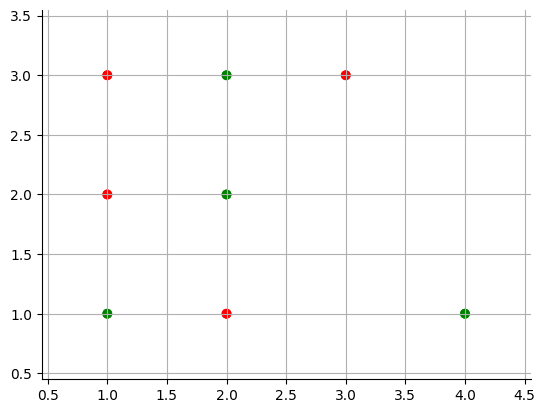

th [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]] th0 [[1.]]


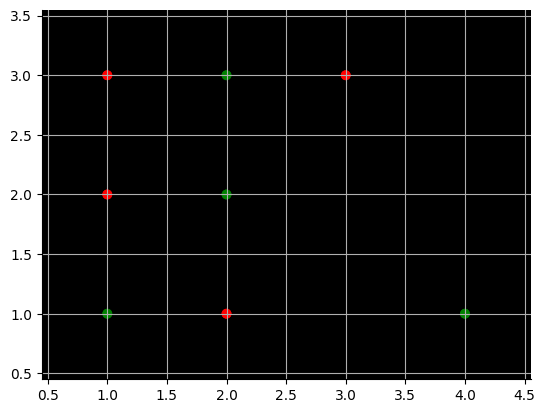

th [[ 0.  0. -1.  0. -1. -3.  0. -1. -3. -7.]] th0 [[0.]]


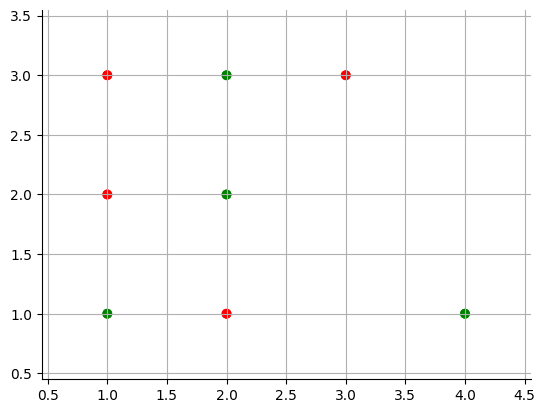

th [[ 1.  2.  2.  4.  5.  6.  8. 11. 15. 20.]] th0 [[1.]]


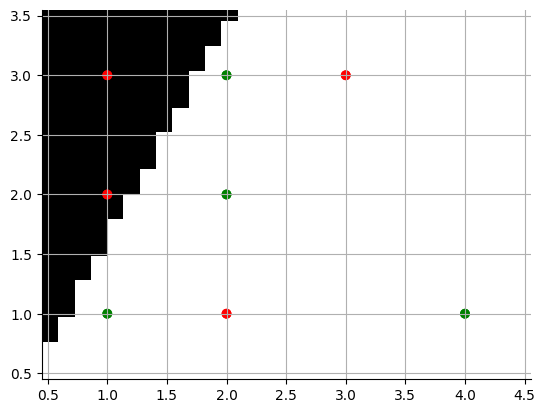

th [[ 0.  1. -1.  3.  2. -3.  7.  8.  6. -7.]] th0 [[0.]]


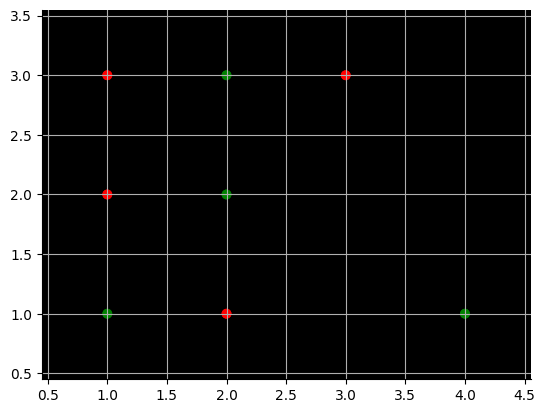

th [[ -1.  -2.  -4.  -6.  -7. -12. -20. -19. -21. -34.]] th0 [[-1.]]


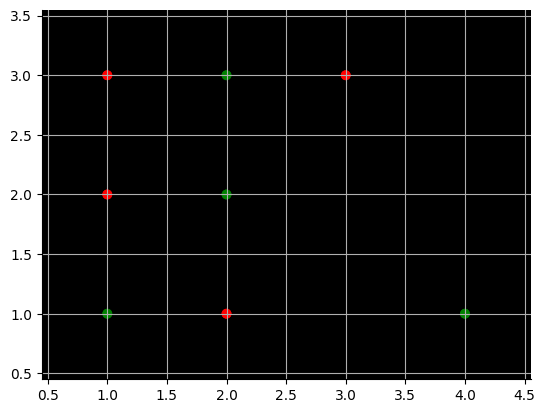

th [[  0.  -1.  -3.  -5.  -6. -11. -19. -18. -20. -33.]] th0 [[0.]]


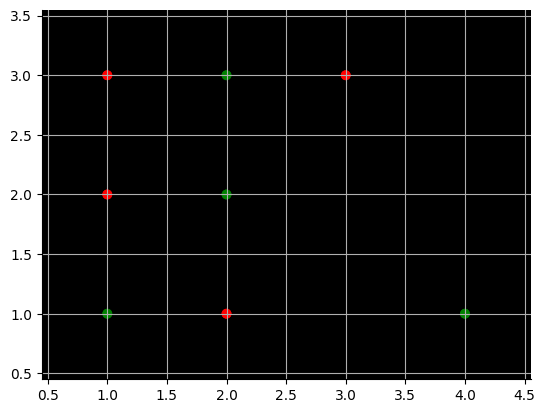

th [[  1.   1.  -1.  -1.  -2.  -7. -11. -10. -12. -25.]] th0 [[1.]]


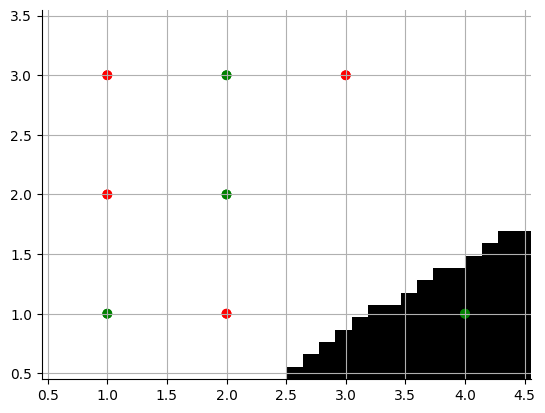

th [[ 2.  3.  2.  3.  4.  2. -3.  2.  6.  2.]] th0 [[2.]]


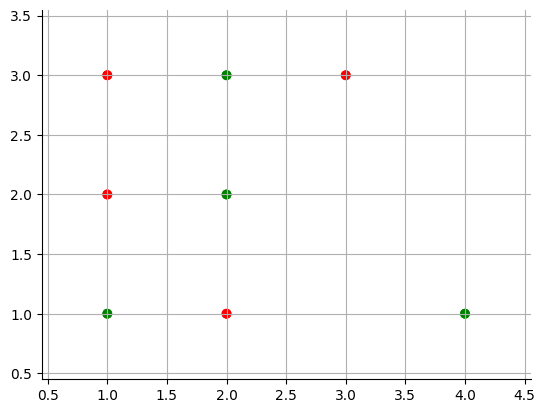

th [[ 3.  7.  3. 19.  8.  3. 61. 18. 10.  3.]] th0 [[3.]]


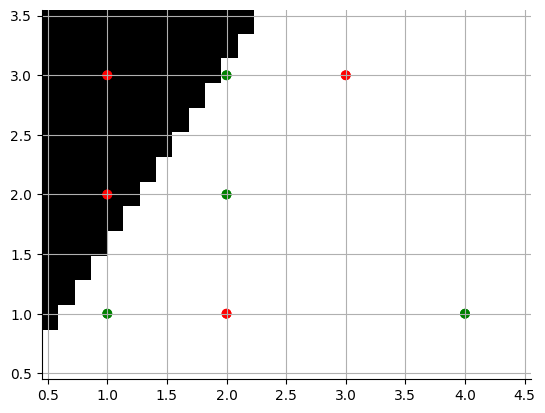

th [[  2.   6.   0.  18.   5.  -6.  60.  15.   1. -24.]] th0 [[2.]]


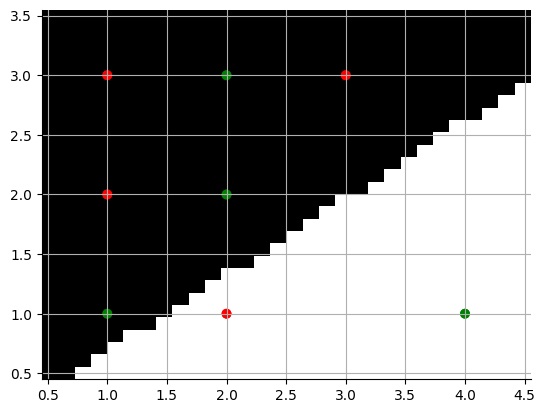

th [[  1.   3.  -3.   9.  -4. -15.  33. -12. -26. -51.]] th0 [[1.]]


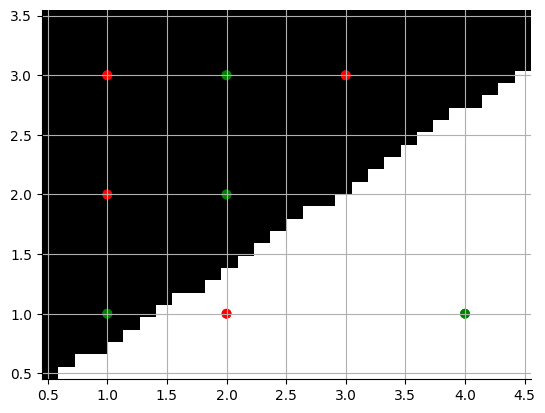

th [[  2.   4.  -2.  10.  -3. -14.  34. -11. -25. -50.]] th0 [[2.]]


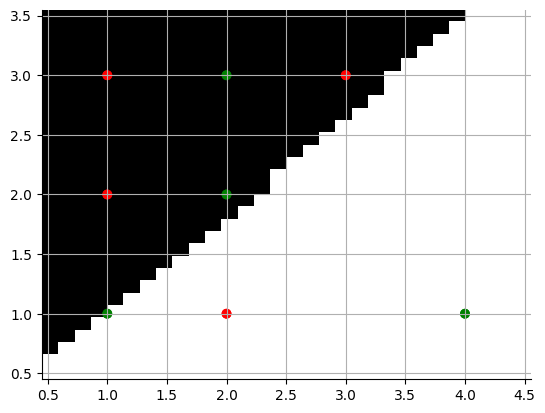

th [[  3.   6.   0.  14.   1. -10.  42.  -3. -17. -42.]] th0 [[3.]]


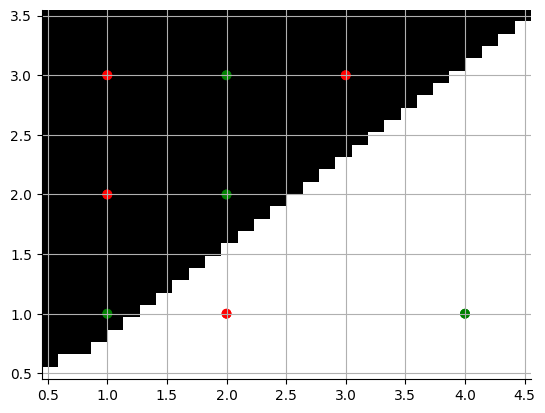

th [[  2.   4.  -1.  10.  -1. -11.  34.  -7. -19. -43.]] th0 [[2.]]


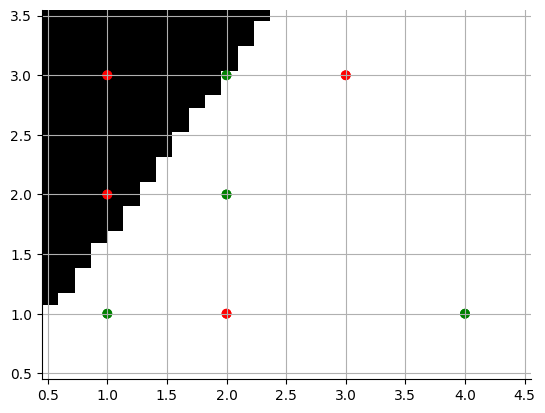

th [[  3.   6.   2.  14.   5.  -2.  42.   5.  -1. -16.]] th0 [[3.]]


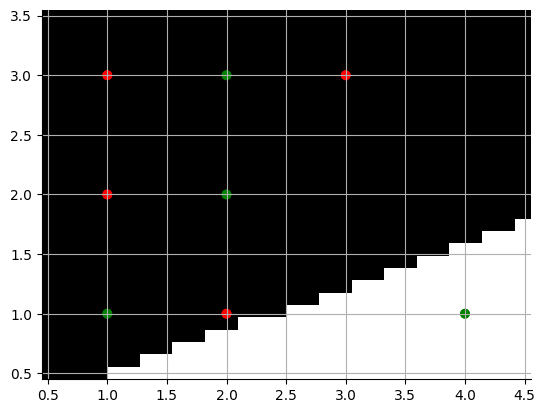

th [[  2.   3.  -1.   5.  -4. -11.  15. -22. -28. -43.]] th0 [[2.]]


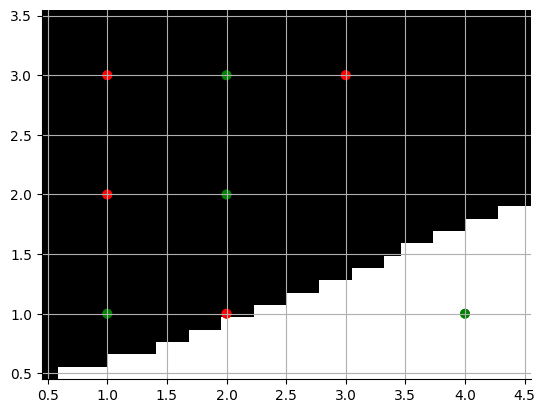

th [[  3.   4.   0.   6.  -3. -10.  16. -21. -27. -42.]] th0 [[3.]]


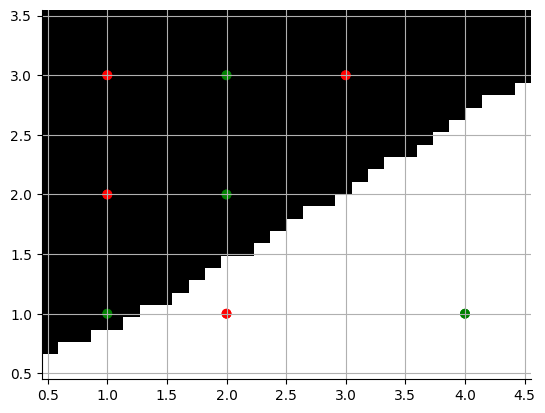

th [[  4.   6.   2.  10.   1.  -6.  24. -13. -19. -34.]] th0 [[4.]]


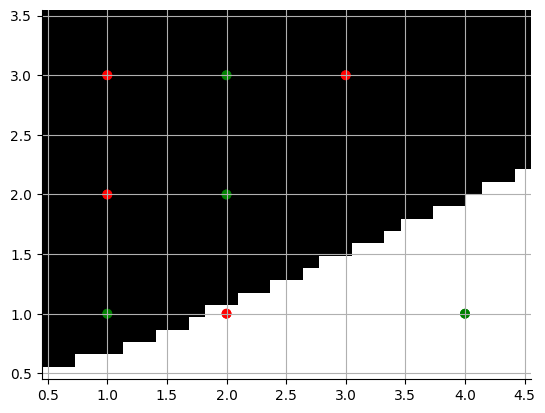

th [[  3.   4.   1.   6.  -1.  -7.  16. -17. -21. -35.]] th0 [[3.]]


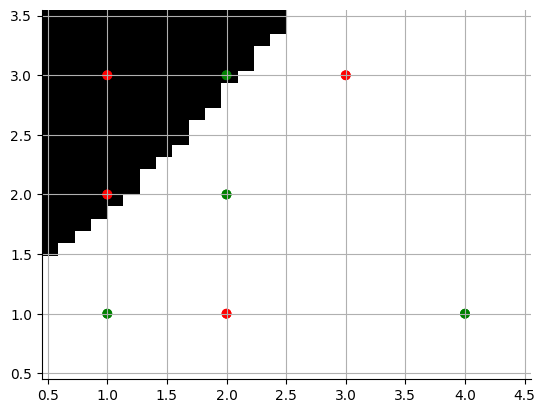

th [[ 4.  6.  4. 10.  5.  2. 24. -5. -3. -8.]] th0 [[4.]]


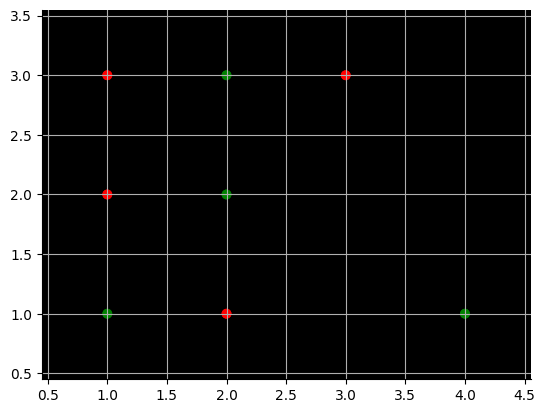

th [[  3.   3.   1.   1.  -4.  -7.  -3. -32. -30. -35.]] th0 [[3.]]


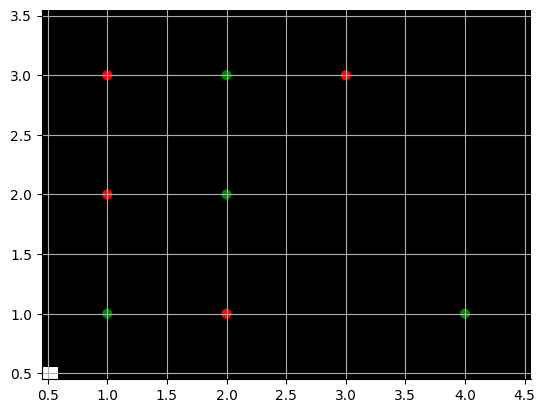

th [[  4.   4.   2.   2.  -3.  -6.  -2. -31. -29. -34.]] th0 [[4.]]


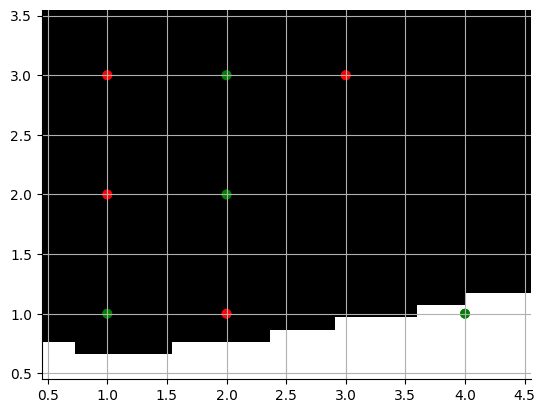

th [[  5.   6.   4.   6.   1.  -2.   6. -23. -21. -26.]] th0 [[5.]]


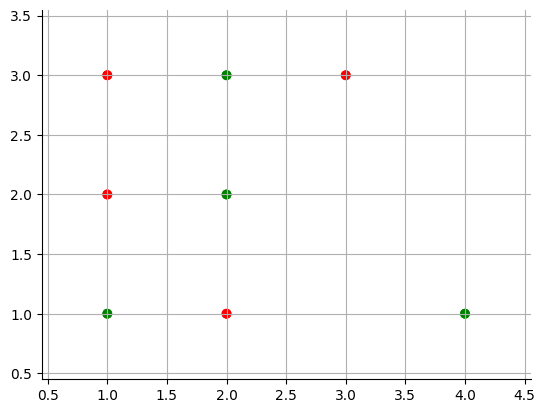

th [[  6.   8.   7.  10.   7.   7.  14. -11.  -3.   1.]] th0 [[6.]]


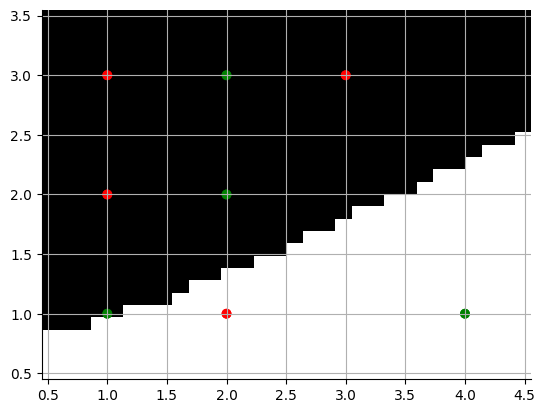

th [[  5.   7.   4.   9.   4.  -2.  13. -14. -12. -26.]] th0 [[5.]]


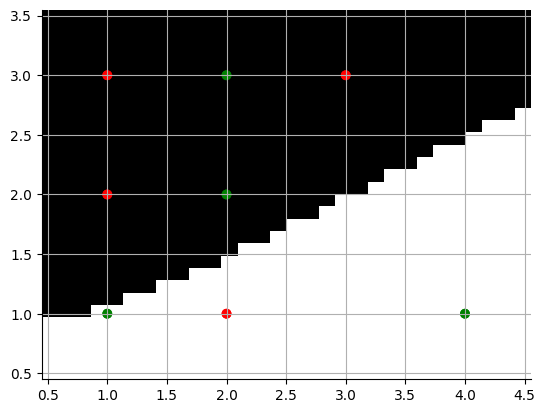

th [[  6.   8.   5.  10.   5.  -1.  14. -13. -11. -25.]] th0 [[6.]]


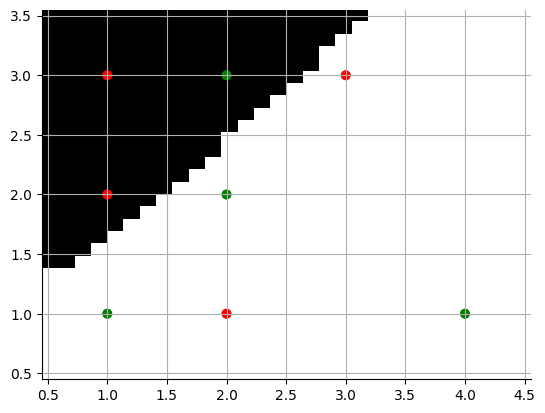

th [[  7.  10.   7.  14.   9.   3.  22.  -5.  -3. -17.]] th0 [[7.]]


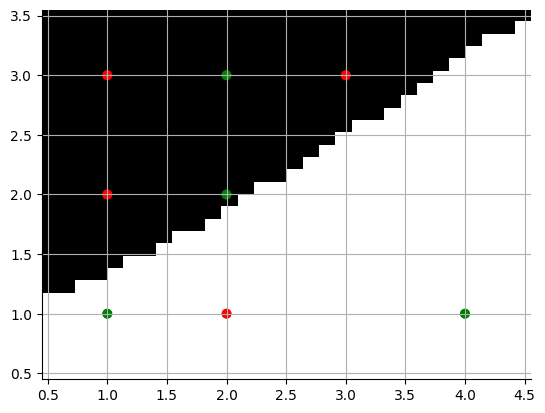

th [[  6.   8.   6.  10.   7.   2.  14.  -9.  -5. -18.]] th0 [[6.]]


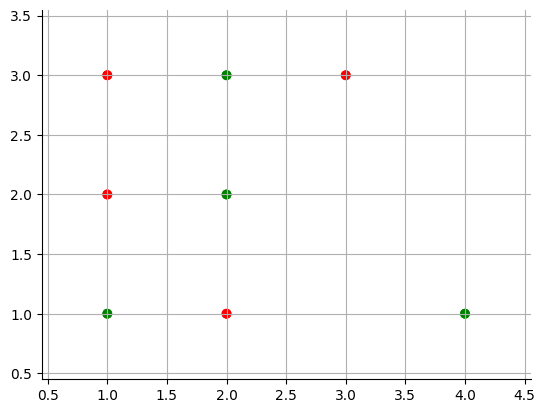

th [[ 7. 10.  9. 14. 13. 11. 22.  3. 13.  9.]] th0 [[7.]]


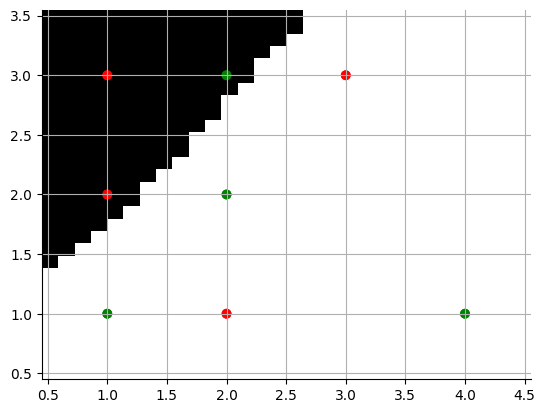

th [[  6.   9.   6.  13.  10.   2.  21.   0.   4. -18.]] th0 [[6.]]


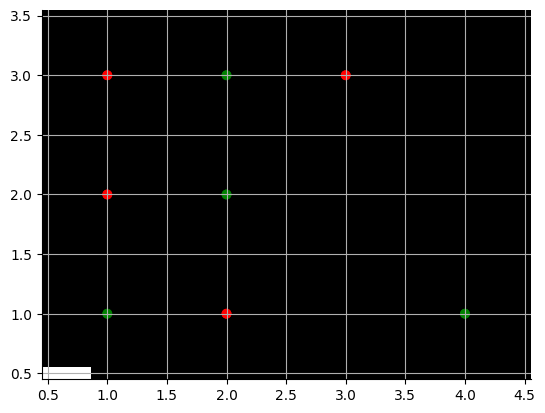

th [[  5.   6.   3.   4.   1.  -7.  -6. -27. -23. -45.]] th0 [[5.]]


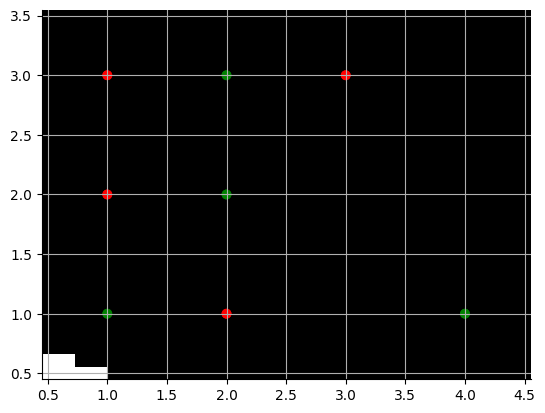

th [[  6.   7.   4.   5.   2.  -6.  -5. -26. -22. -44.]] th0 [[6.]]


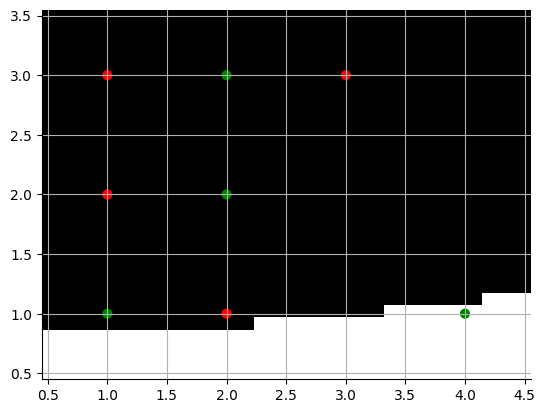

th [[  7.   9.   6.   9.   6.  -2.   3. -18. -14. -36.]] th0 [[7.]]


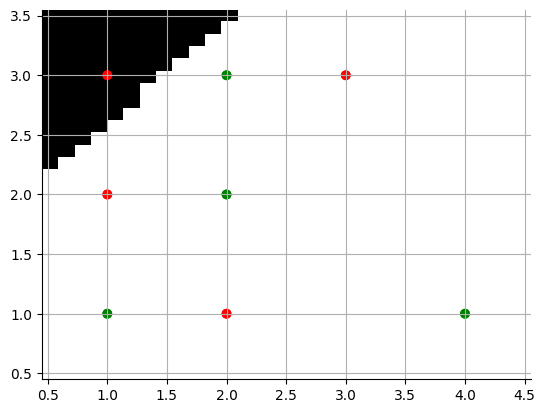

th [[ 8. 11.  9. 13. 12.  7. 11. -6.  4. -9.]] th0 [[8.]]


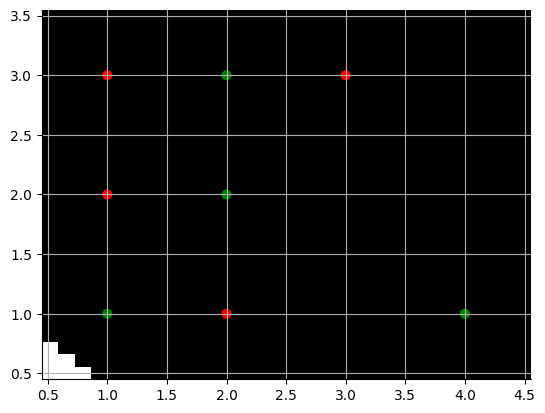

th [[  7.   8.   6.   4.   3.  -2. -16. -33. -23. -36.]] th0 [[7.]]


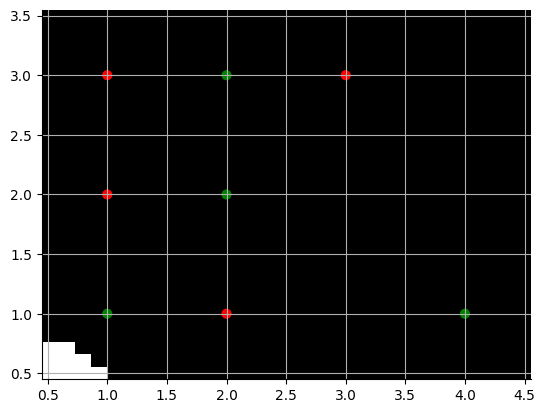

th [[  8.   9.   7.   5.   4.  -1. -15. -32. -22. -35.]] th0 [[8.]]


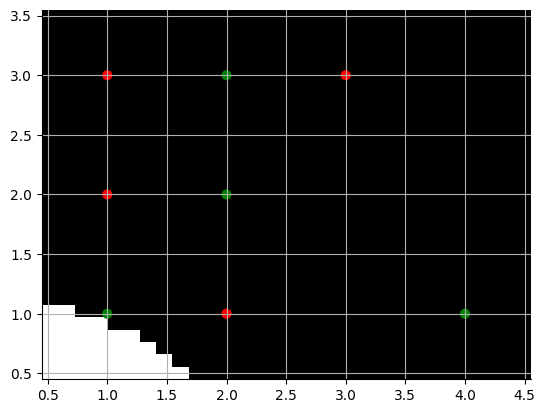

th [[  9.  11.   9.   9.   8.   3.  -7. -24. -14. -27.]] th0 [[9.]]


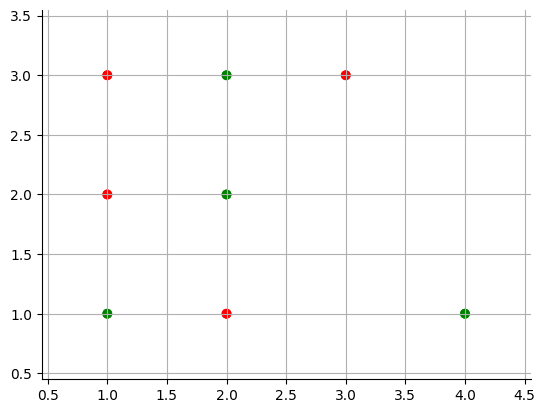

th [[ 10.  13.  12.  13.  14.  12.   1. -12.   4.   0.]] th0 [[10.]]


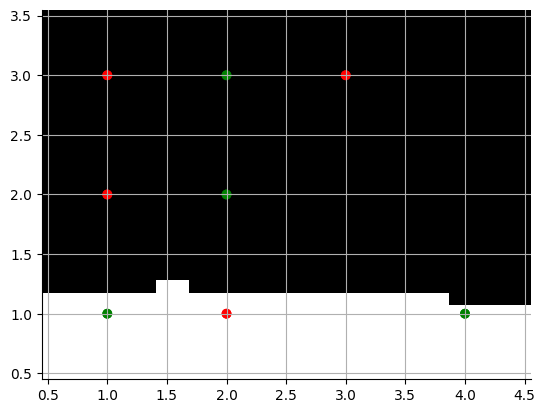

th [[  9.  12.   9.  12.  11.   3.   0. -15.  -5. -27.]] th0 [[9.]]


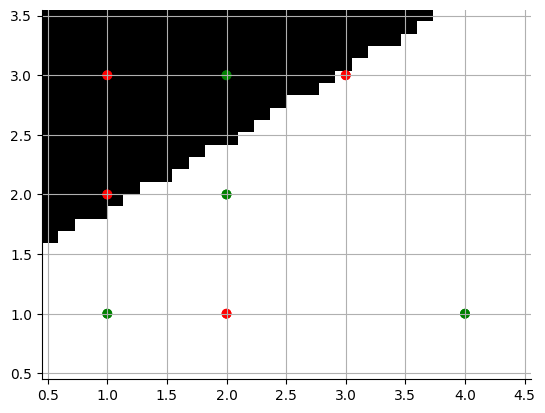

th [[ 10.  14.  11.  16.  15.   7.   8.  -7.   3. -19.]] th0 [[10.]]


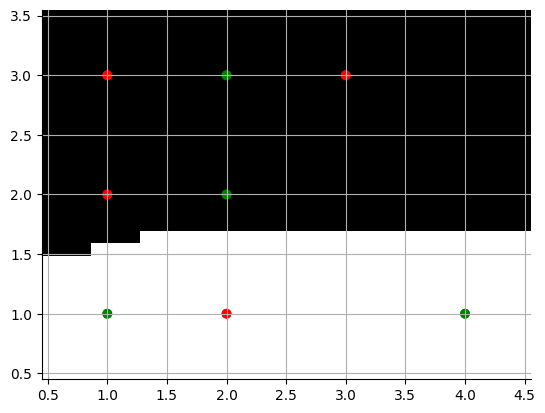

th [[  9.  12.  10.  12.  13.   6.   0. -11.   1. -20.]] th0 [[9.]]


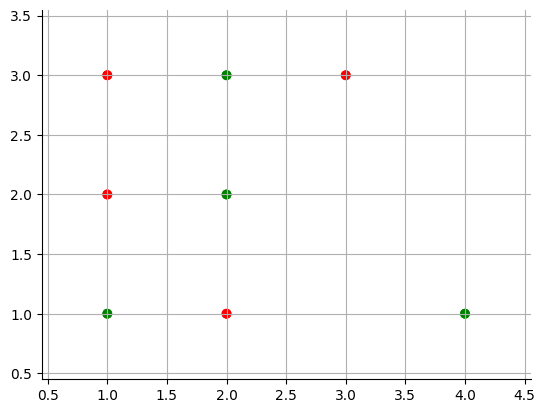

th [[10. 14. 13. 16. 19. 15.  8.  1. 19.  7.]] th0 [[10.]]


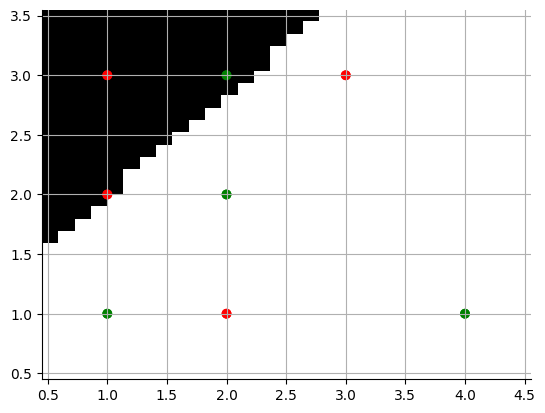

th [[  9.  13.  10.  15.  16.   6.   7.  -2.  10. -20.]] th0 [[9.]]


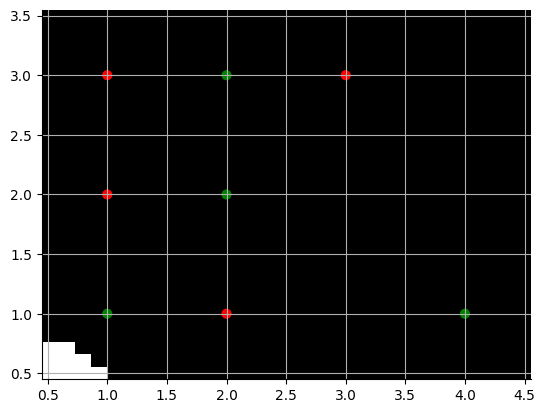

th [[  8.  10.   7.   6.   7.  -3. -20. -29. -17. -47.]] th0 [[8.]]


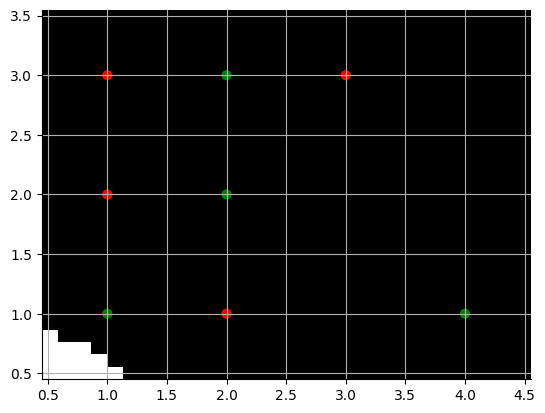

th [[  9.  11.   8.   7.   8.  -2. -19. -28. -16. -46.]] th0 [[9.]]


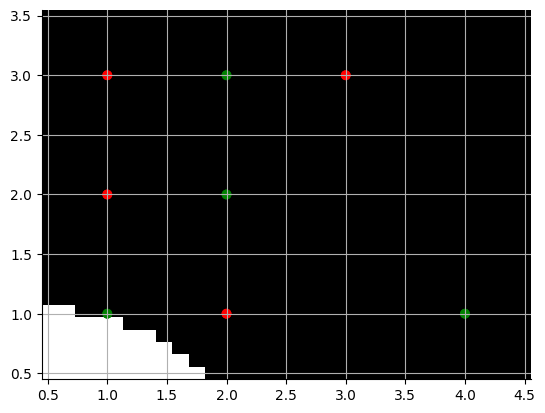

th [[ 10.  13.  10.  11.  12.   2. -11. -20.  -8. -38.]] th0 [[10.]]


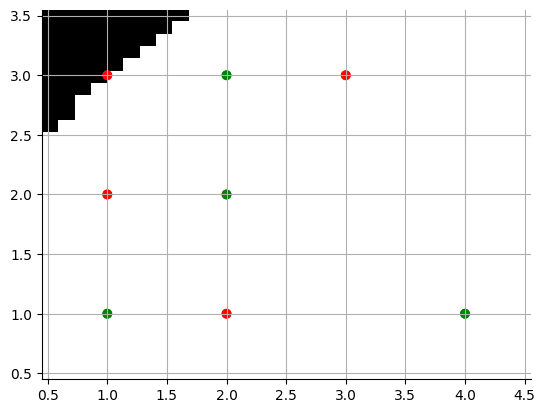

th [[ 11.  15.  13.  15.  18.  11.  -3.  -8.  10. -11.]] th0 [[11.]]


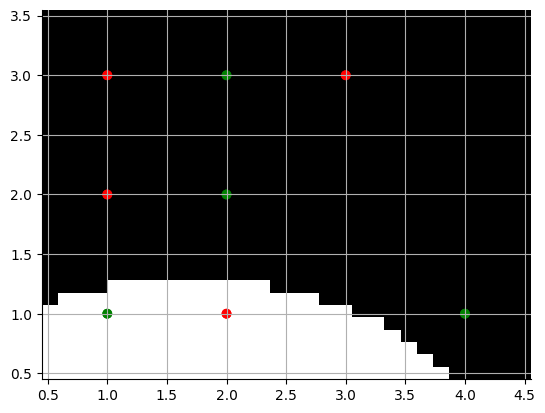

th [[ 10.  14.  10.  14.  15.   2.  -4. -11.   1. -38.]] th0 [[10.]]


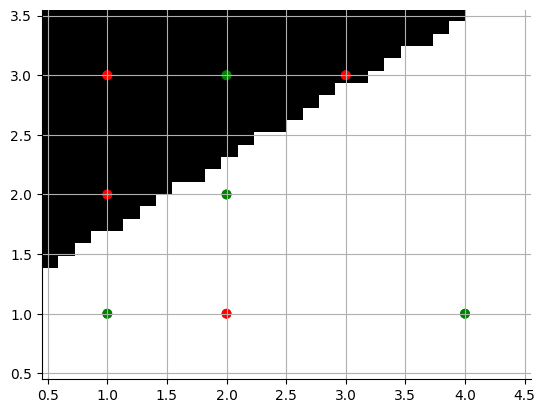

th [[ 11.  16.  12.  18.  19.   6.   4.  -3.   9. -30.]] th0 [[11.]]


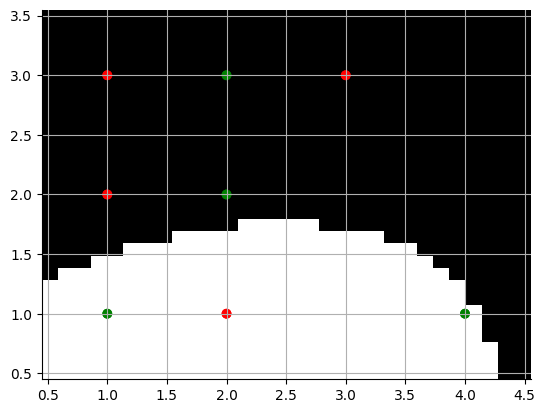

th [[ 10.  14.  11.  14.  17.   5.  -4.  -7.   7. -31.]] th0 [[10.]]


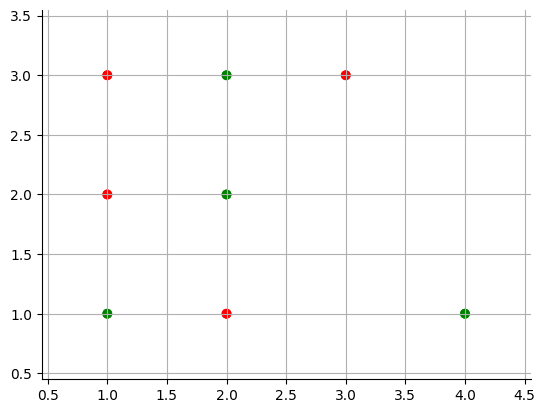

th [[11. 16. 14. 18. 23. 14.  4.  5. 25. -4.]] th0 [[11.]]


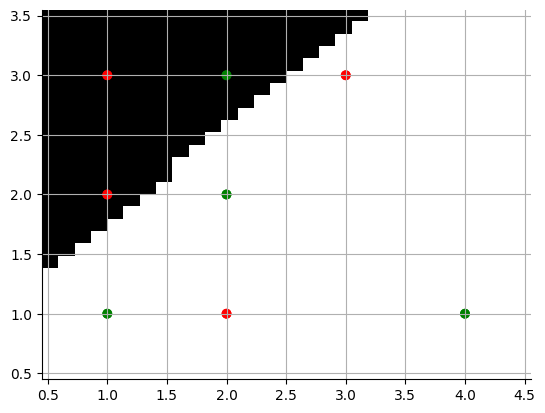

th [[ 10.  15.  11.  17.  20.   5.   3.   2.  16. -31.]] th0 [[10.]]


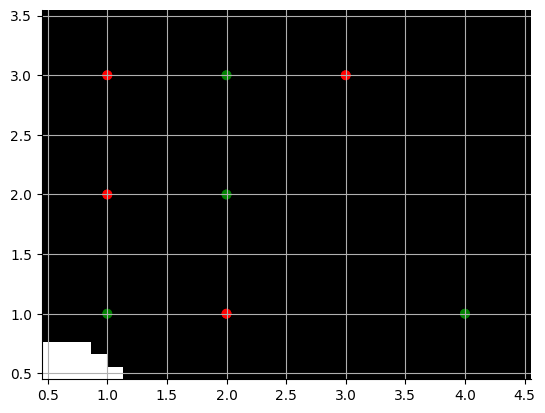

th [[  9.  12.   8.   8.  11.  -4. -24. -25. -11. -58.]] th0 [[9.]]


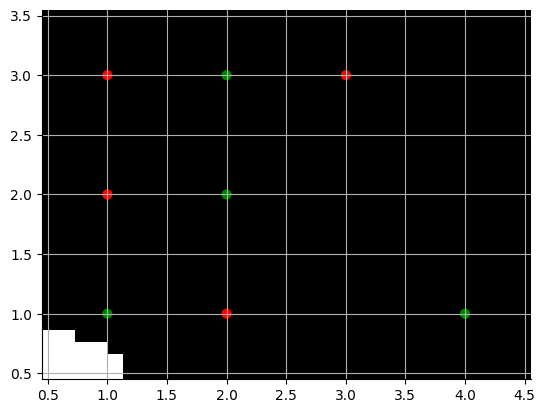

th [[ 10.  13.   9.   9.  12.  -3. -23. -24. -10. -57.]] th0 [[10.]]


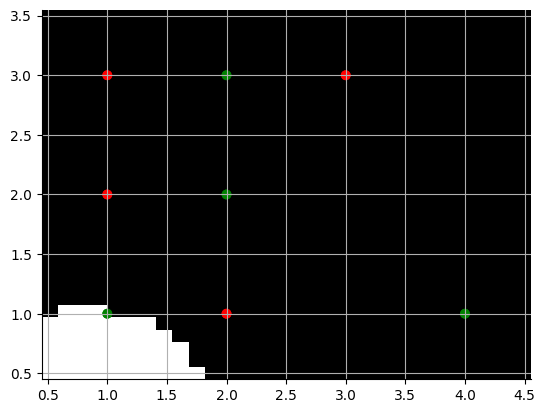

th [[ 11.  15.  11.  13.  16.   1. -15. -16.  -2. -49.]] th0 [[11.]]


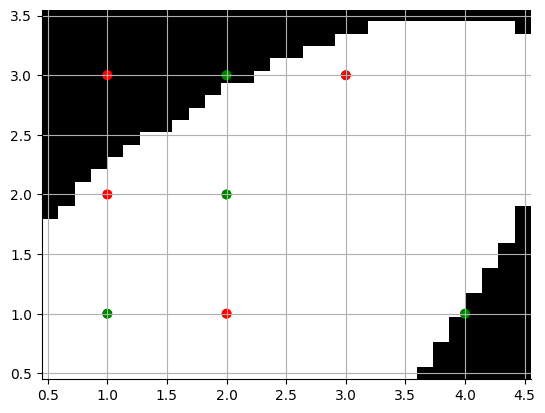

th [[ 12.  17.  14.  17.  22.  10.  -7.  -4.  16. -22.]] th0 [[12.]]


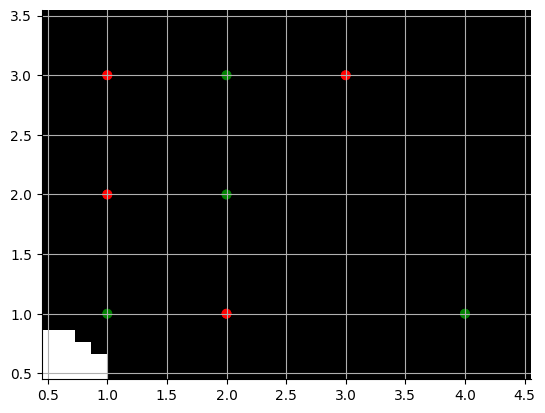

th [[ 11.  14.  11.   8.  13.   1. -34. -31. -11. -49.]] th0 [[11.]]


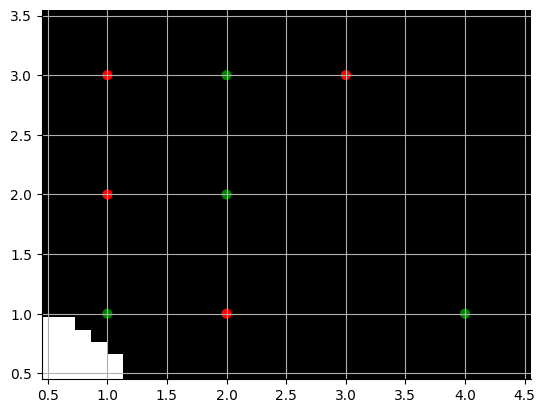

th [[ 12.  15.  12.   9.  14.   2. -33. -30. -10. -48.]] th0 [[12.]]


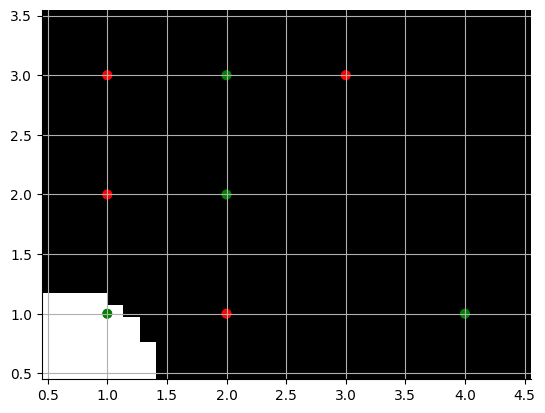

th [[ 13.  17.  14.  13.  18.   6. -25. -22.  -2. -40.]] th0 [[13.]]


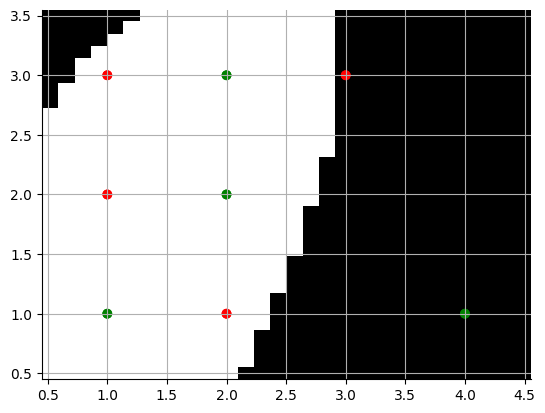

th [[ 14.  19.  17.  17.  24.  15. -17. -10.  16. -13.]] th0 [[14.]]


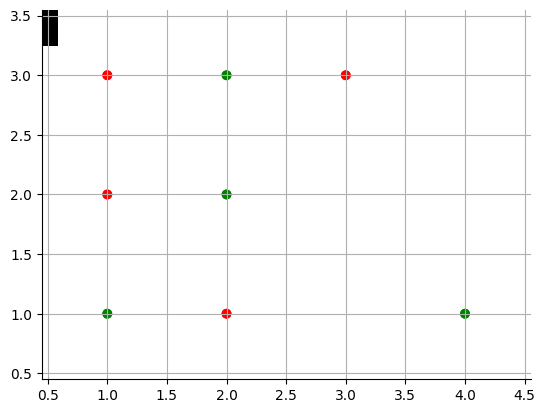

th [[ 15.  23.  18.  33.  28.  16.  47.   6.  20. -12.]] th0 [[15.]]


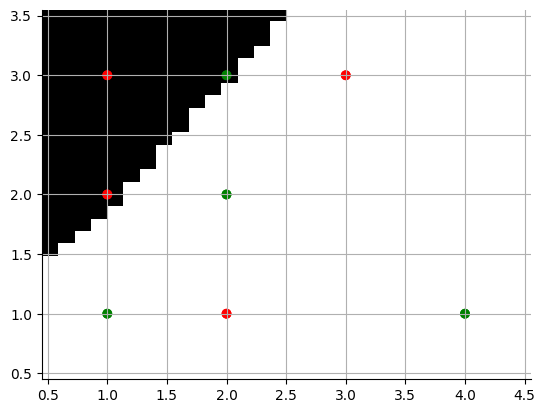

th [[ 14.  22.  15.  32.  25.   7.  46.   3.  11. -39.]] th0 [[14.]]


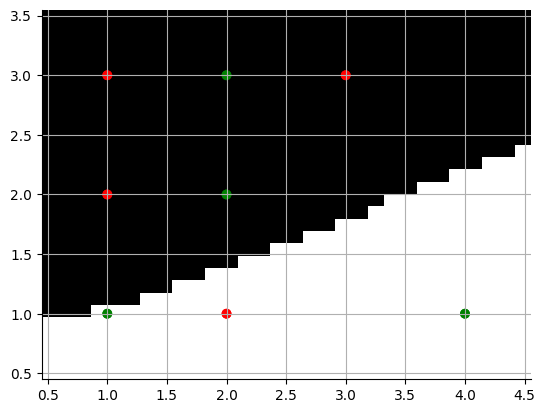

th [[ 13.  19.  12.  23.  16.  -2.  19. -24. -16. -66.]] th0 [[13.]]


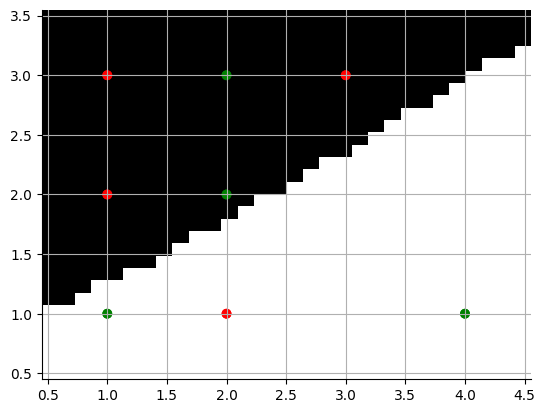

th [[ 14.  21.  14.  27.  20.   2.  27. -16.  -8. -58.]] th0 [[14.]]


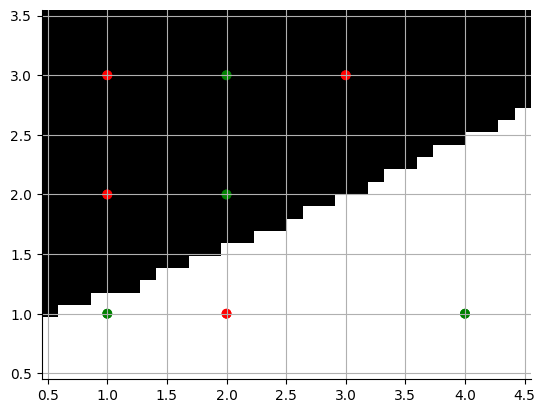

th [[ 13.  19.  13.  23.  18.   1.  19. -20. -10. -59.]] th0 [[13.]]


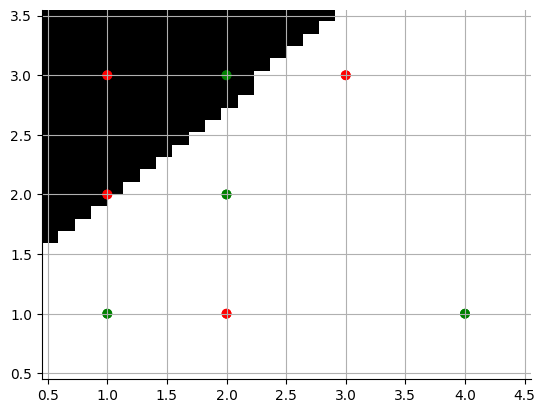

th [[ 14.  21.  16.  27.  24.  10.  27.  -8.   8. -32.]] th0 [[14.]]


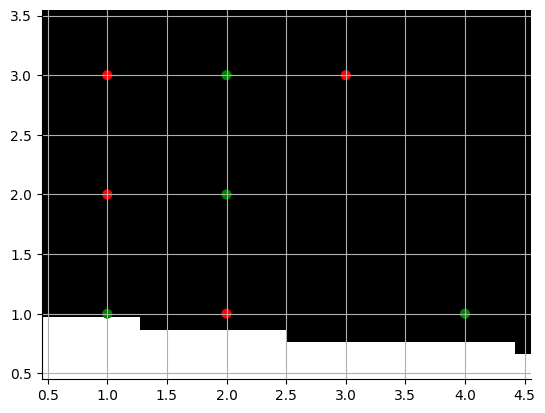

th [[ 13.  18.  13.  18.  15.   1.   0. -35. -19. -59.]] th0 [[13.]]


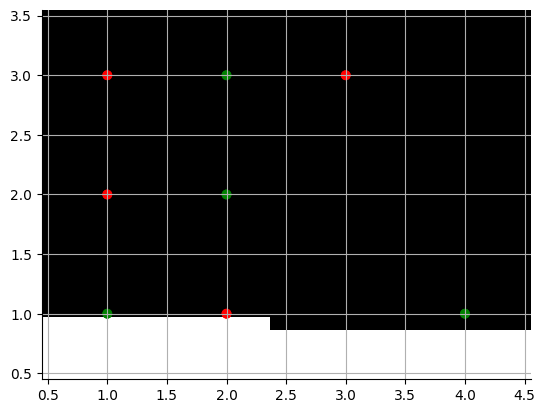

th [[ 14.  19.  14.  19.  16.   2.   1. -34. -18. -58.]] th0 [[14.]]


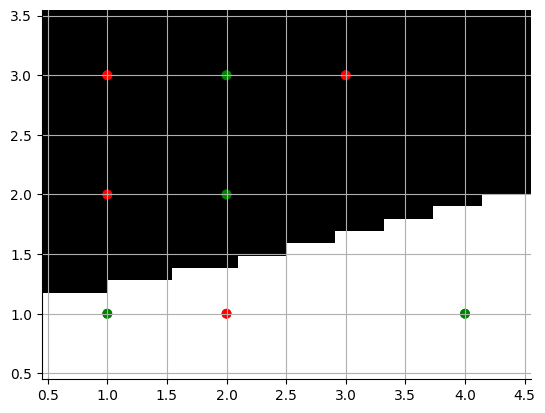

th [[ 15.  21.  16.  23.  20.   6.   9. -26. -10. -50.]] th0 [[15.]]


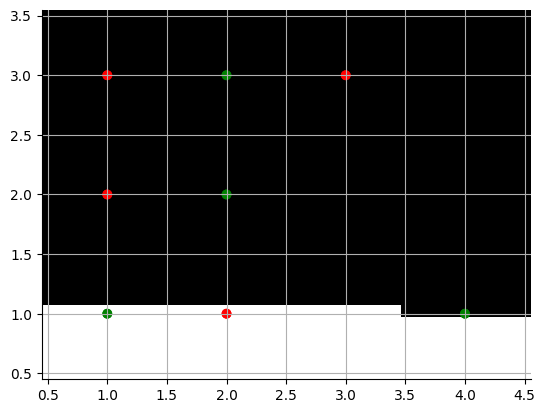

th [[ 14.  19.  15.  19.  18.   5.   1. -30. -12. -51.]] th0 [[14.]]


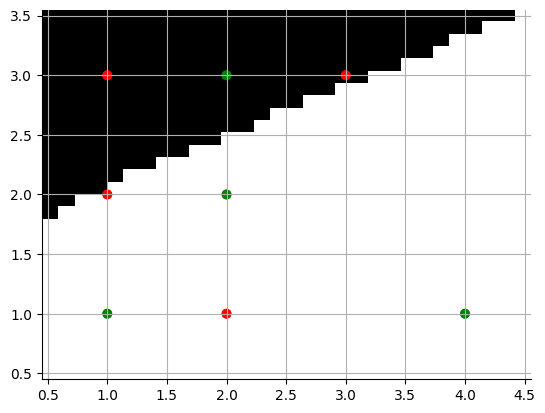

th [[ 15.  21.  18.  23.  24.  14.   9. -18.   6. -24.]] th0 [[15.]]


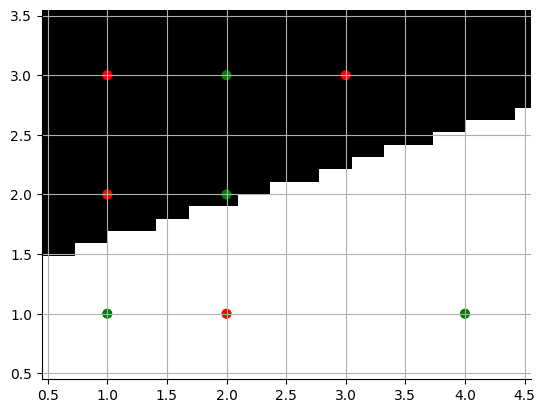

th [[ 14.  20.  16.  22.  22.  10.   8. -20.   2. -32.]] th0 [[14.]]


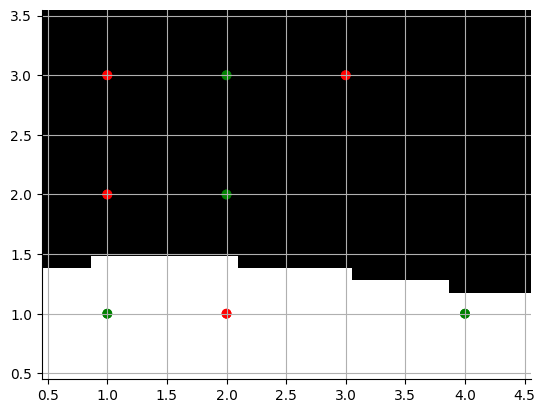

th [[ 13.  18.  15.  18.  20.   9.   0. -24.   0. -33.]] th0 [[13.]]


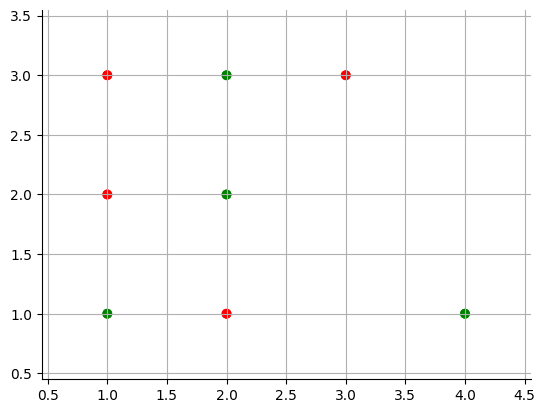

th [[ 14.  20.  18.  22.  26.  18.   8. -12.  18.  -6.]] th0 [[14.]]


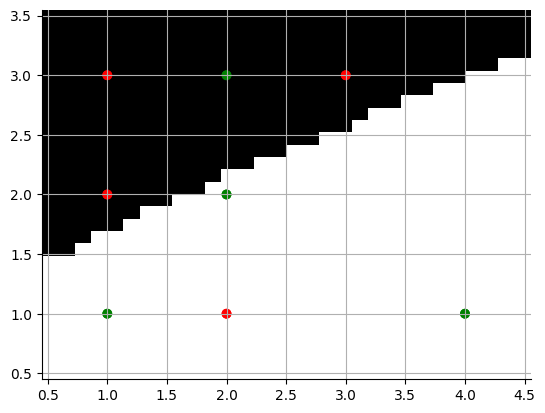

th [[ 13.  19.  15.  21.  23.   9.   7. -15.   9. -33.]] th0 [[13.]]


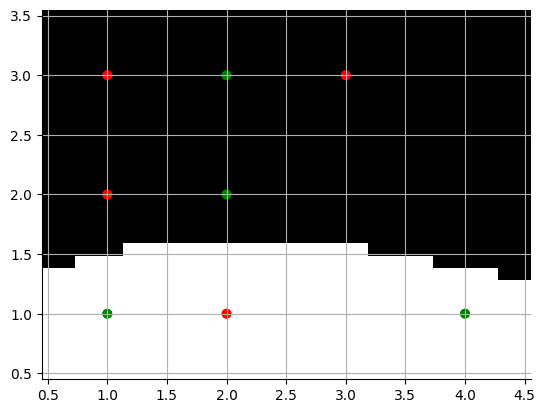

th [[ 12.  17.  14.  17.  21.   8.  -1. -19.   7. -34.]] th0 [[12.]]


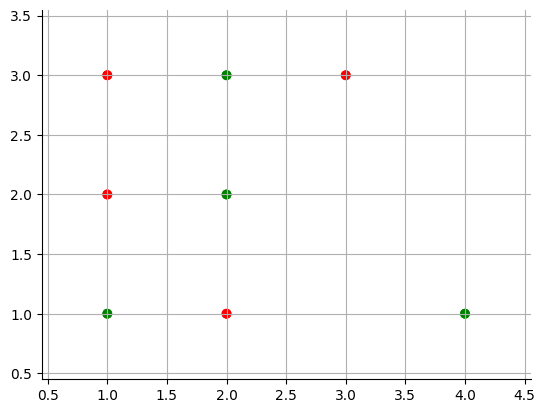

th [[13. 19. 17. 21. 27. 17.  7. -7. 25. -7.]] th0 [[13.]]


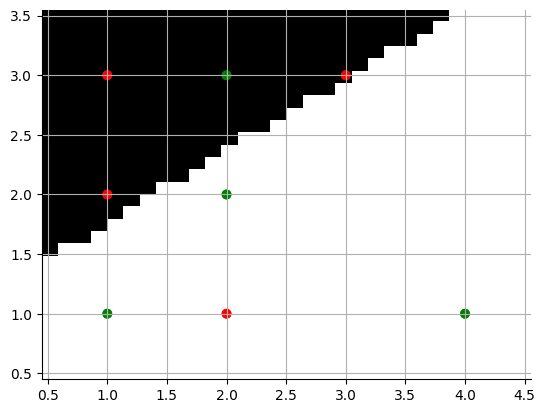

th [[ 12.  18.  14.  20.  24.   8.   6. -10.  16. -34.]] th0 [[12.]]


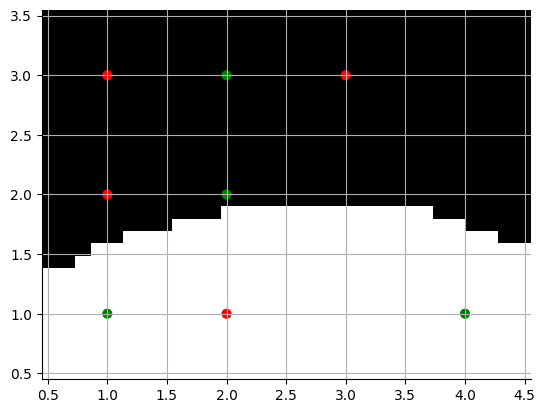

th [[ 11.  16.  13.  16.  22.   7.  -2. -14.  14. -35.]] th0 [[11.]]


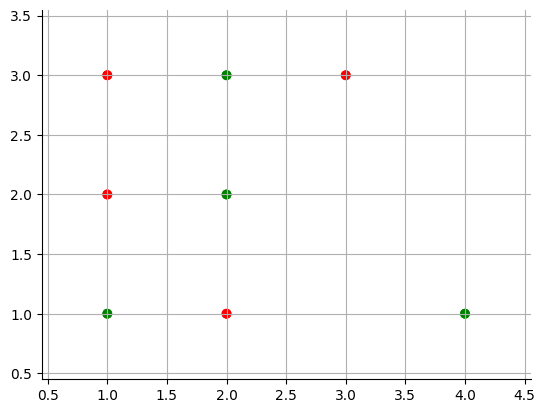

th [[12. 18. 16. 20. 28. 16.  6. -2. 32. -8.]] th0 [[12.]]


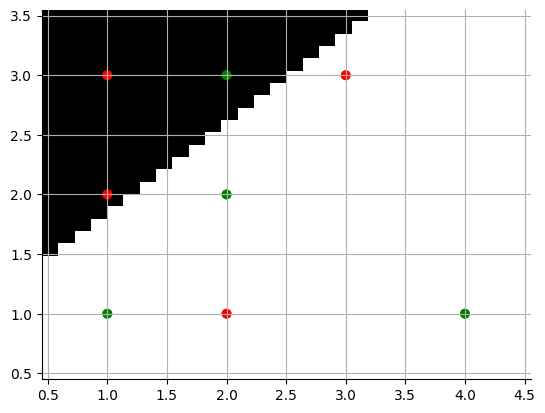

th [[ 11.  17.  13.  19.  25.   7.   5.  -5.  23. -35.]] th0 [[11.]]


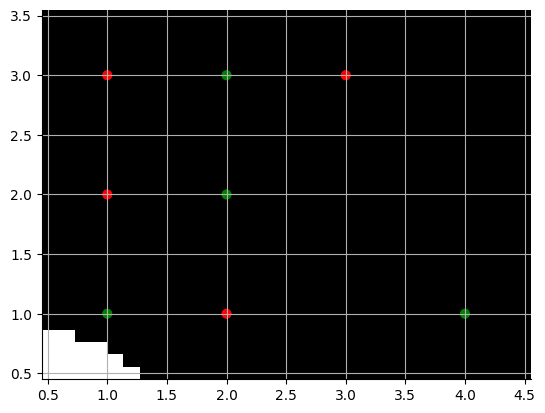

th [[ 10.  14.  10.  10.  16.  -2. -22. -32.  -4. -62.]] th0 [[10.]]


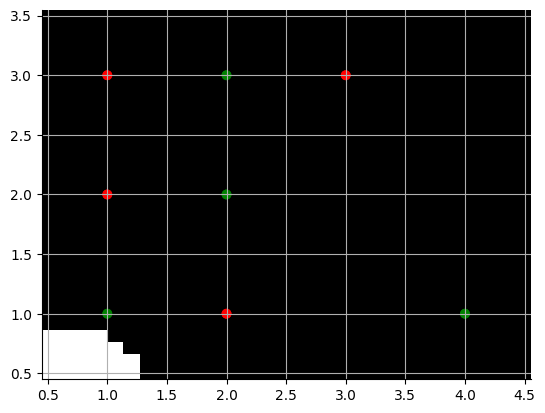

th [[ 11.  15.  11.  11.  17.  -1. -21. -31.  -3. -61.]] th0 [[11.]]


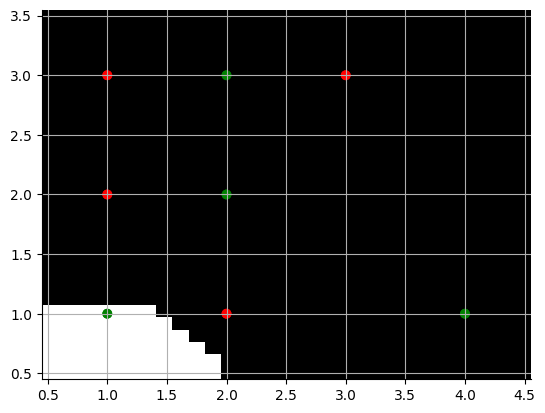

th [[ 12.  17.  13.  15.  21.   3. -13. -23.   5. -53.]] th0 [[12.]]


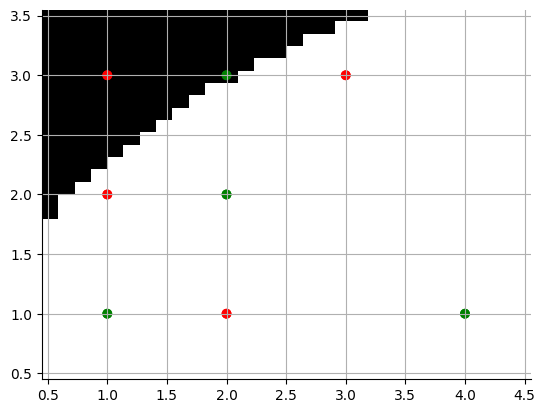

th [[ 13.  19.  16.  19.  27.  12.  -5. -11.  23. -26.]] th0 [[13.]]


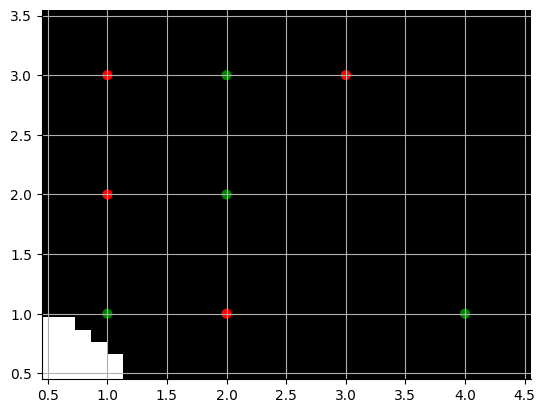

th [[ 12.  16.  13.  10.  18.   3. -32. -38.  -4. -53.]] th0 [[12.]]


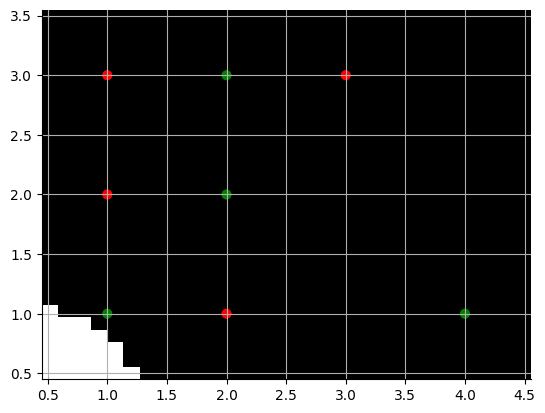

th [[ 13.  17.  14.  11.  19.   4. -31. -37.  -3. -52.]] th0 [[13.]]


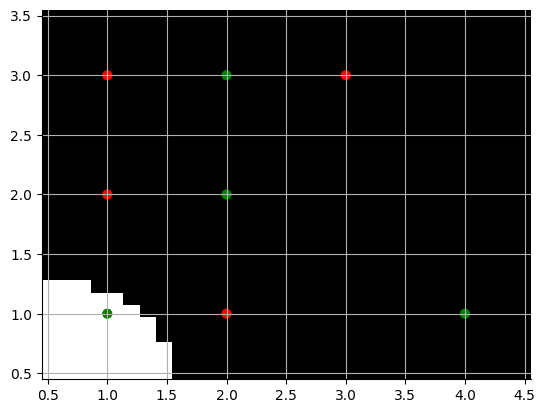

th [[ 14.  19.  16.  15.  23.   8. -23. -29.   5. -44.]] th0 [[14.]]


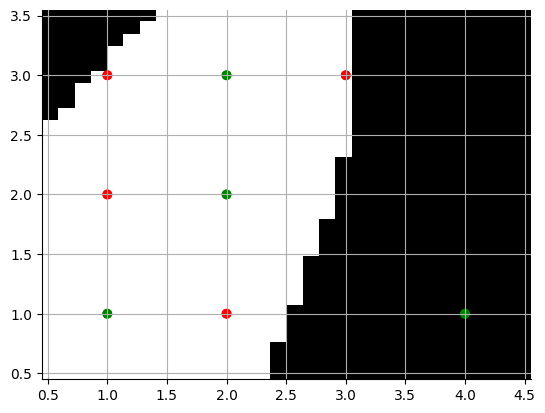

th [[ 15.  21.  19.  19.  29.  17. -15. -17.  23. -17.]] th0 [[15.]]


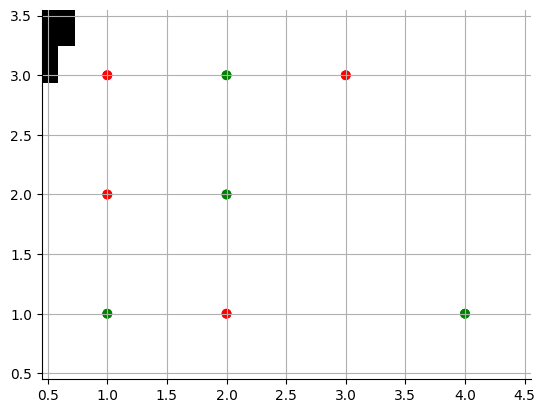

th [[ 16.  25.  20.  35.  33.  18.  49.  -1.  27. -16.]] th0 [[16.]]


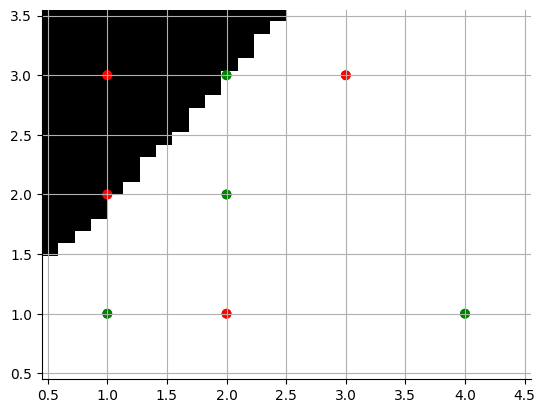

th [[ 15.  24.  17.  34.  30.   9.  48.  -4.  18. -43.]] th0 [[15.]]


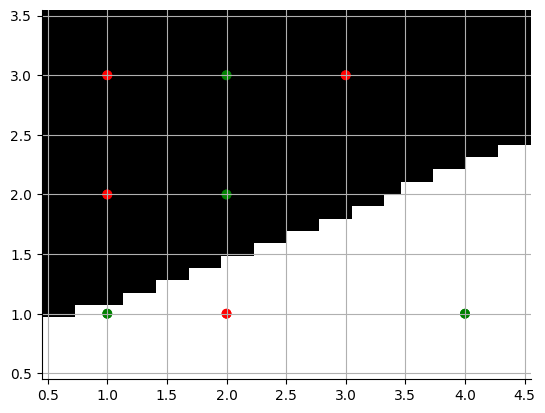

th [[ 14.  21.  14.  25.  21.   0.  21. -31.  -9. -70.]] th0 [[14.]]


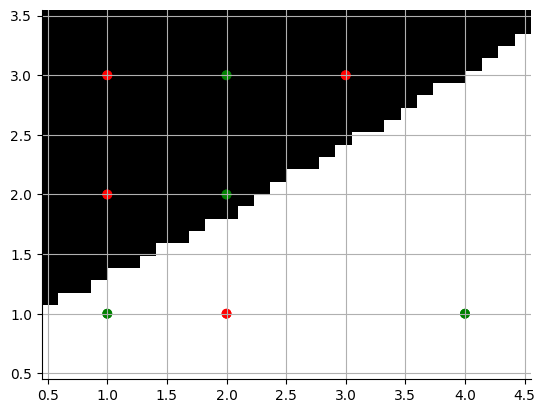

th [[ 15.  23.  16.  29.  25.   4.  29. -23.  -1. -62.]] th0 [[15.]]


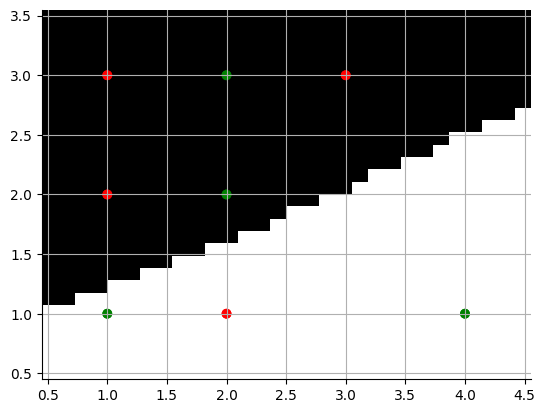

th [[ 14.  21.  15.  25.  23.   3.  21. -27.  -3. -63.]] th0 [[14.]]


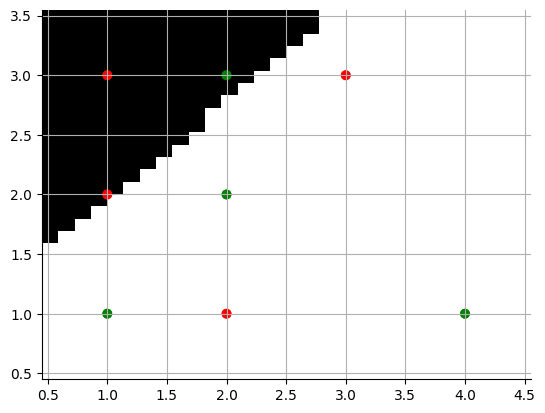

th [[ 15.  23.  18.  29.  29.  12.  29. -15.  15. -36.]] th0 [[15.]]


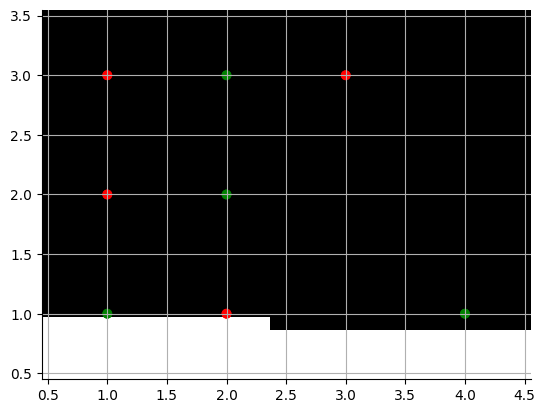

th [[ 14.  20.  15.  20.  20.   3.   2. -42. -12. -63.]] th0 [[14.]]


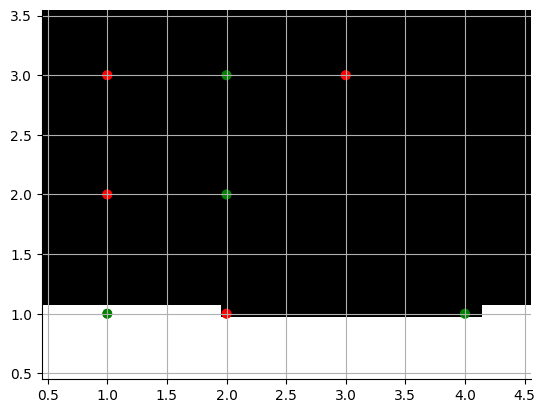

th [[ 15.  21.  16.  21.  21.   4.   3. -41. -11. -62.]] th0 [[15.]]


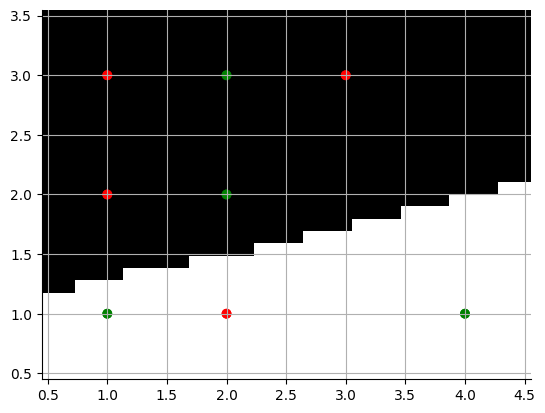

th [[ 16.  23.  18.  25.  25.   8.  11. -33.  -3. -54.]] th0 [[16.]]


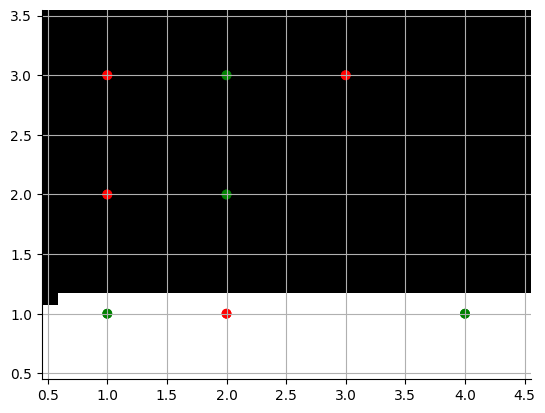

th [[ 15.  21.  17.  21.  23.   7.   3. -37.  -5. -55.]] th0 [[15.]]


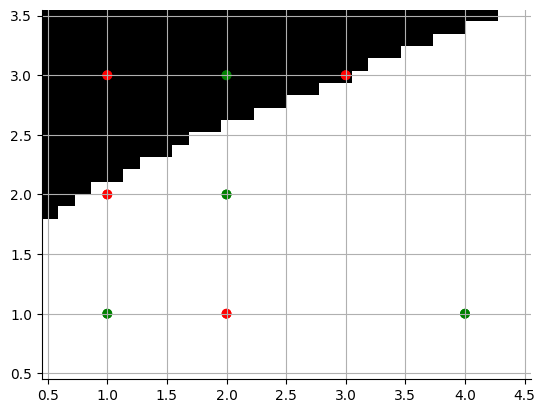

th [[ 16.  23.  20.  25.  29.  16.  11. -25.  13. -28.]] th0 [[16.]]


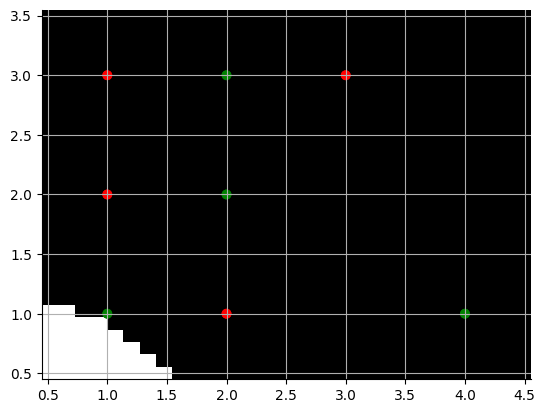

th [[ 15.  20.  17.  16.  20.   7. -16. -52. -14. -55.]] th0 [[15.]]


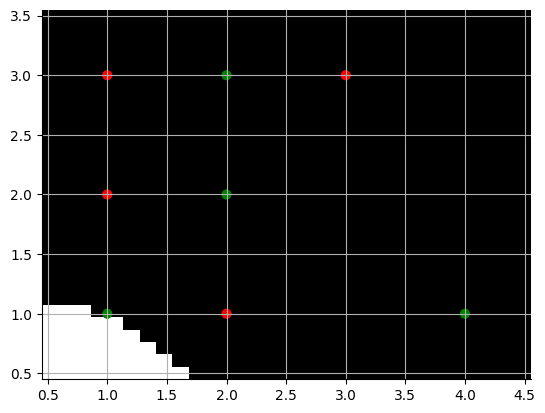

th [[ 16.  21.  18.  17.  21.   8. -15. -51. -13. -54.]] th0 [[16.]]


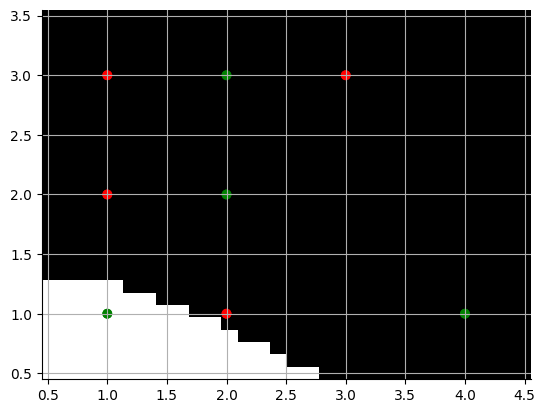

th [[ 17.  23.  20.  21.  25.  12.  -7. -43.  -5. -46.]] th0 [[17.]]


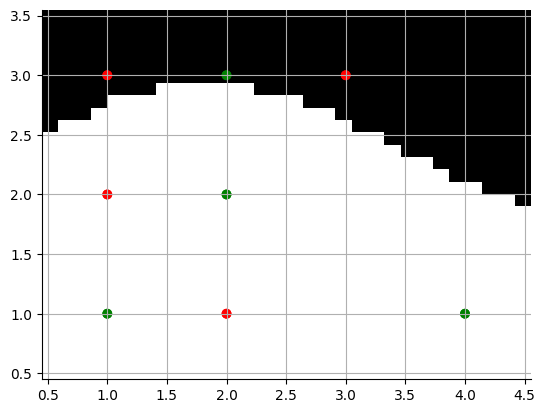

th [[ 18.  25.  23.  25.  31.  21.   1. -31.  13. -19.]] th0 [[18.]]


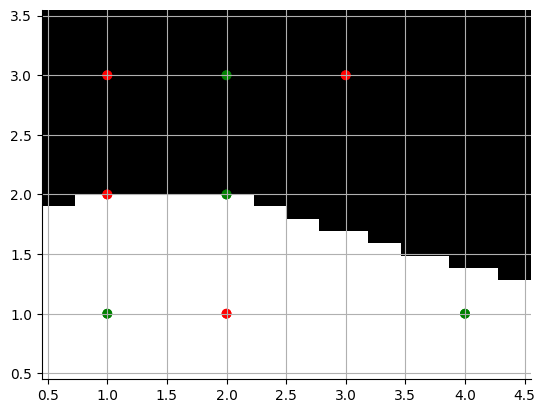

th [[ 17.  24.  21.  24.  29.  17.   0. -33.   9. -27.]] th0 [[17.]]


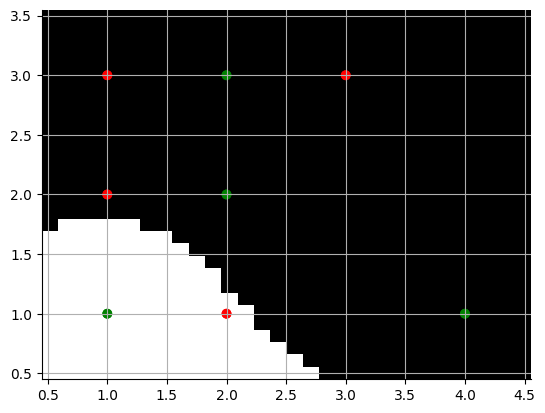

th [[ 16.  22.  20.  20.  27.  16.  -8. -37.   7. -28.]] th0 [[16.]]


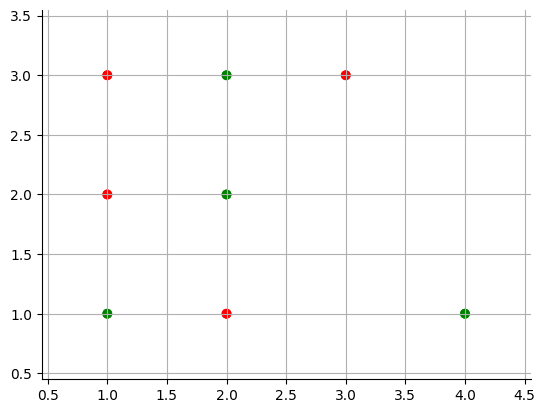

th [[ 17.  24.  23.  24.  33.  25.   0. -25.  25.  -1.]] th0 [[17.]]


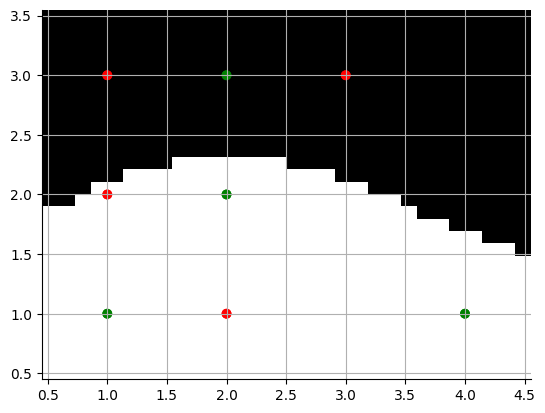

th [[ 16.  23.  20.  23.  30.  16.  -1. -28.  16. -28.]] th0 [[16.]]


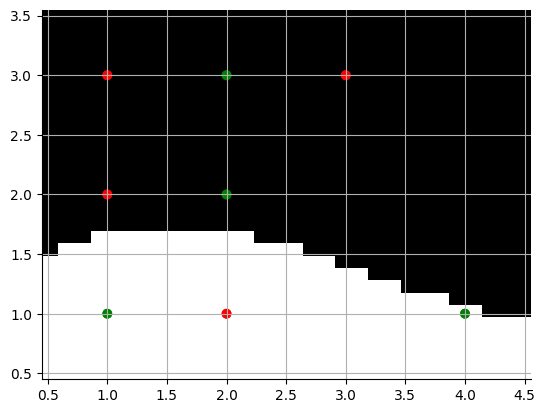

th [[ 15.  22.  18.  22.  28.  12.  -2. -30.  12. -36.]] th0 [[15.]]


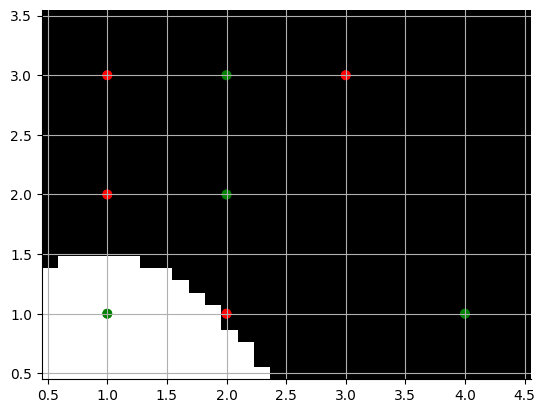

th [[ 14.  20.  17.  18.  26.  11. -10. -34.  10. -37.]] th0 [[14.]]


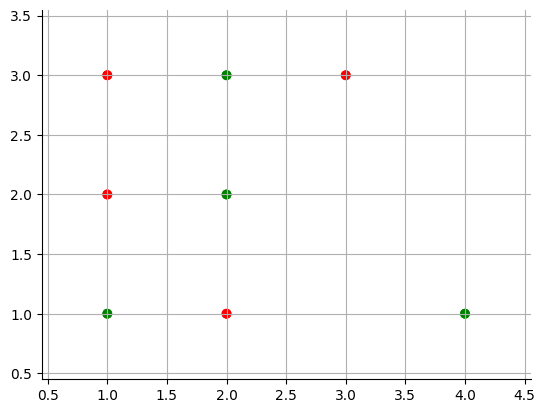

th [[ 15.  22.  20.  22.  32.  20.  -2. -22.  28. -10.]] th0 [[15.]]


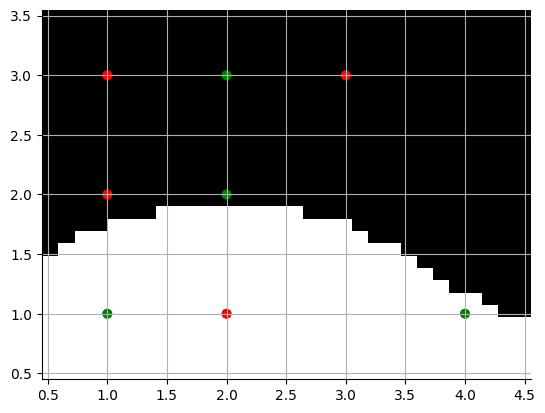

th [[ 14.  21.  17.  21.  29.  11.  -3. -25.  19. -37.]] th0 [[14.]]


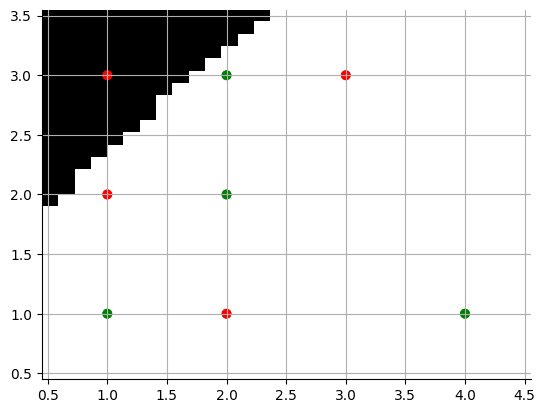

th [[ 15.  23.  19.  25.  33.  15.   5. -17.  27. -29.]] th0 [[15.]]


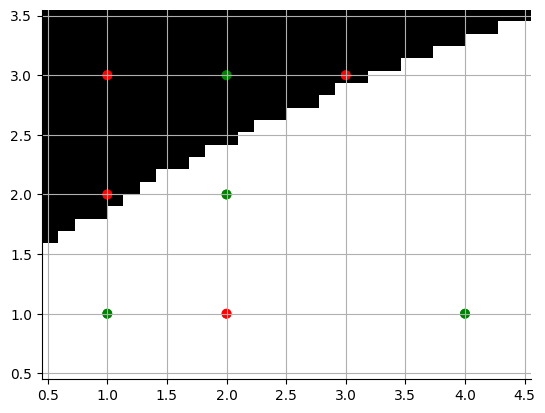

th [[ 14.  22.  17.  24.  31.  11.   4. -19.  23. -37.]] th0 [[14.]]


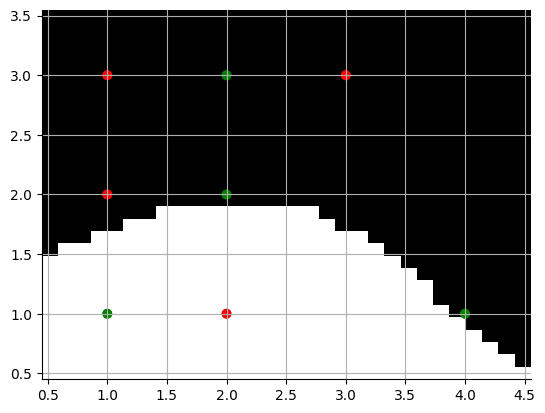

th [[ 13.  20.  16.  20.  29.  10.  -4. -23.  21. -38.]] th0 [[13.]]


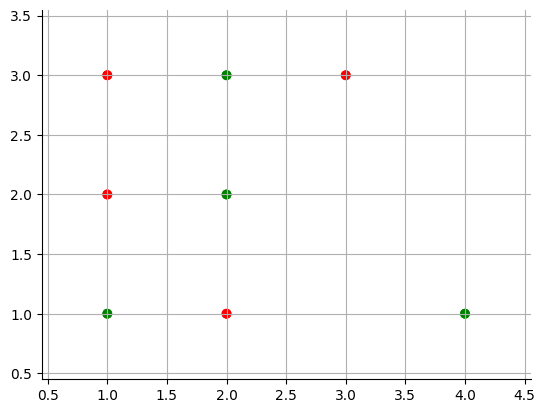

th [[ 14.  22.  19.  24.  35.  19.   4. -11.  39. -11.]] th0 [[14.]]


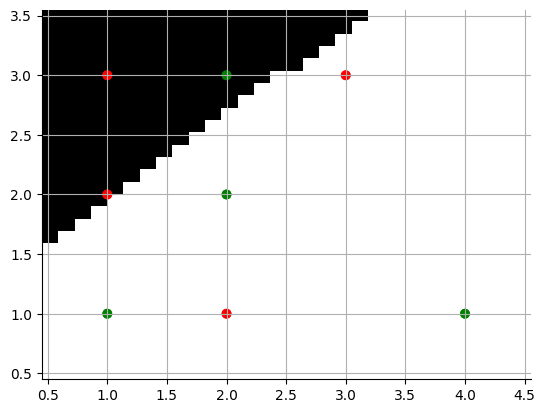

th [[ 13.  21.  16.  23.  32.  10.   3. -14.  30. -38.]] th0 [[13.]]


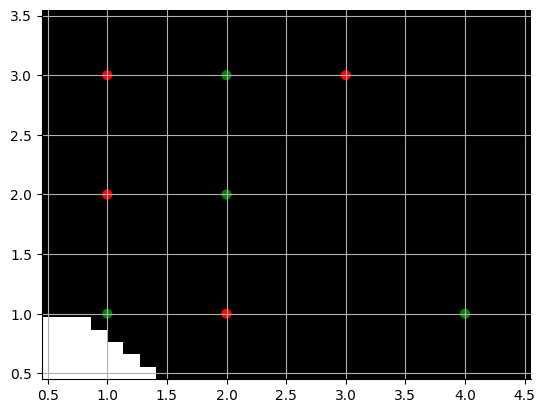

th [[ 12.  18.  13.  14.  23.   1. -24. -41.   3. -65.]] th0 [[12.]]


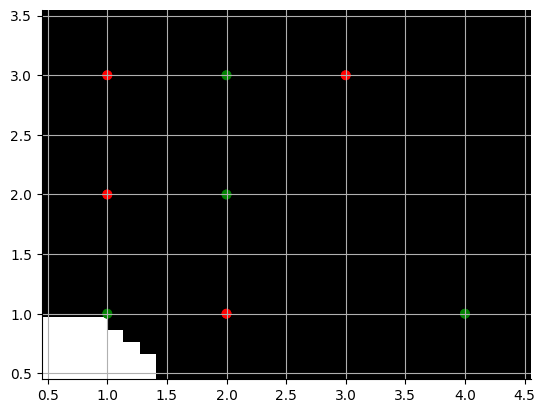

th [[ 13.  19.  14.  15.  24.   2. -23. -40.   4. -64.]] th0 [[13.]]


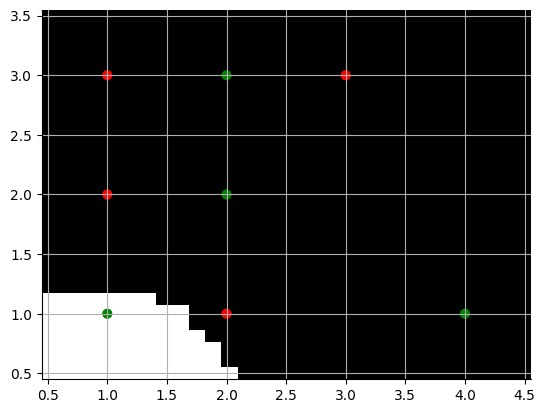

th [[ 14.  21.  16.  19.  28.   6. -15. -32.  12. -56.]] th0 [[14.]]


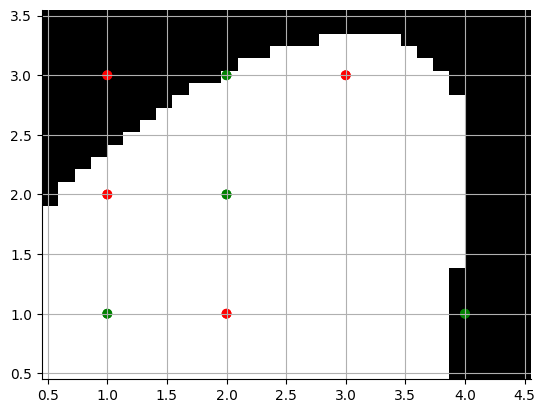

th [[ 15.  23.  19.  23.  34.  15.  -7. -20.  30. -29.]] th0 [[15.]]


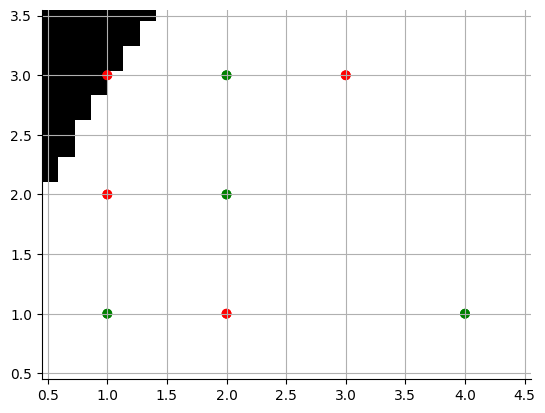

th [[ 16.  27.  20.  39.  38.  16.  57.  -4.  34. -28.]] th0 [[16.]]


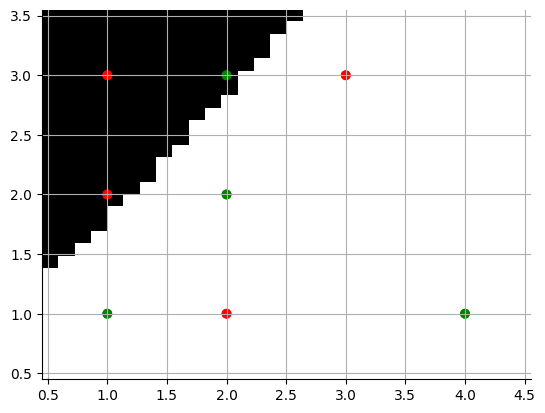

th [[ 15.  26.  17.  38.  35.   7.  56.  -7.  25. -55.]] th0 [[15.]]


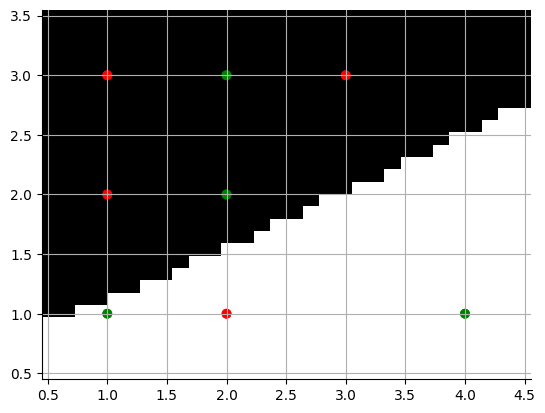

th [[ 14.  23.  14.  29.  26.  -2.  29. -34.  -2. -82.]] th0 [[14.]]


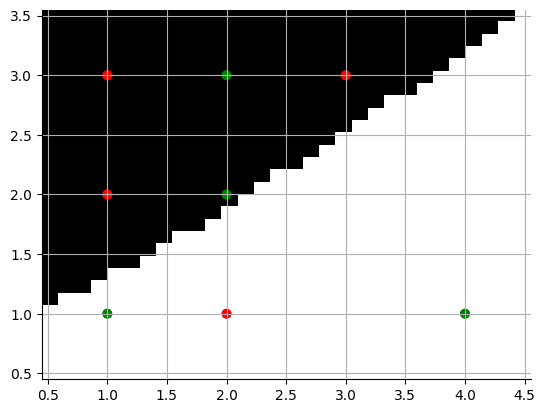

th [[ 15.  25.  16.  33.  30.   2.  37. -26.   6. -74.]] th0 [[15.]]


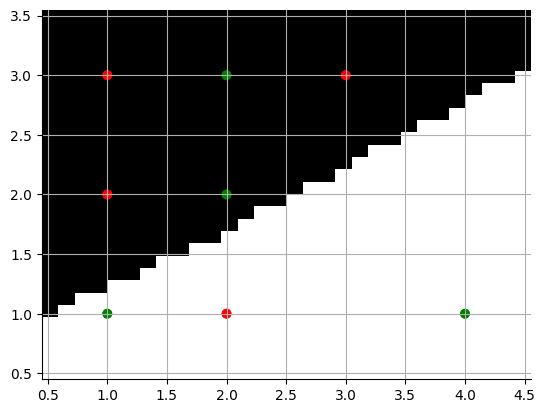

th [[ 14.  23.  15.  29.  28.   1.  29. -30.   4. -75.]] th0 [[14.]]


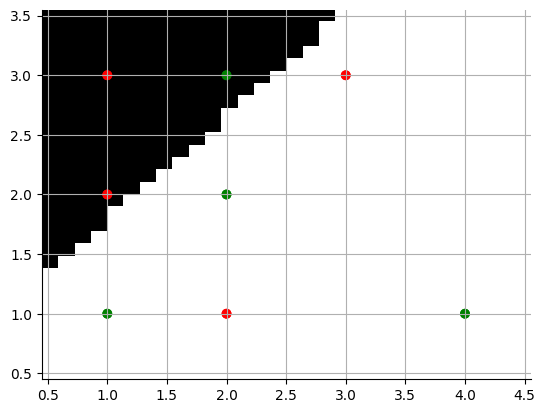

th [[ 15.  25.  18.  33.  34.  10.  37. -18.  22. -48.]] th0 [[15.]]


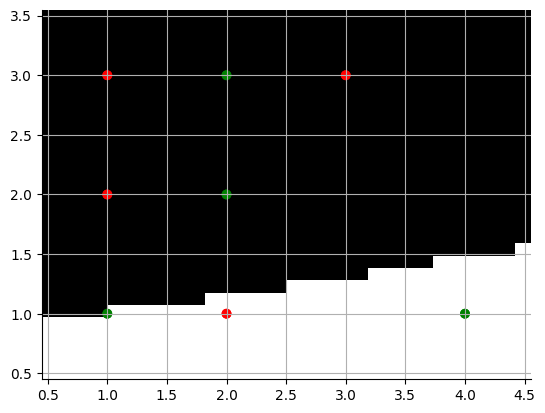

th [[ 14.  22.  15.  24.  25.   1.  10. -45.  -5. -75.]] th0 [[14.]]


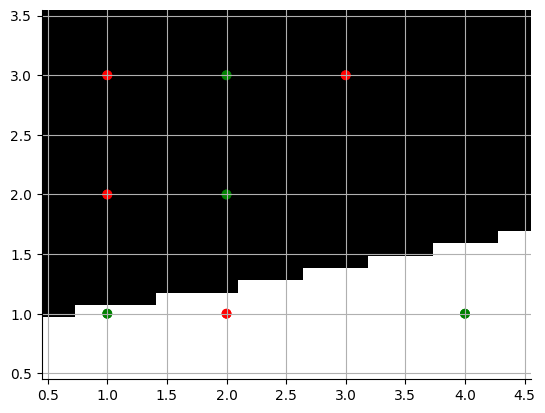

th [[ 15.  23.  16.  25.  26.   2.  11. -44.  -4. -74.]] th0 [[15.]]


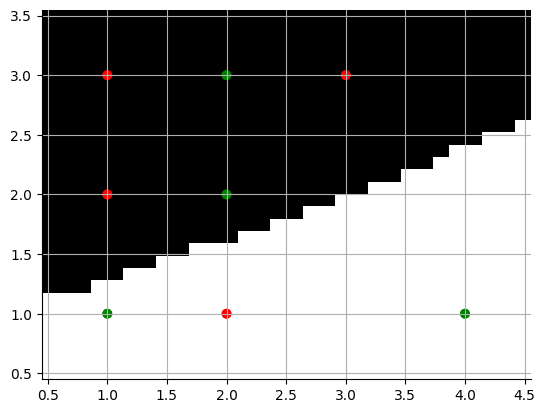

th [[ 16.  25.  18.  29.  30.   6.  19. -36.   4. -66.]] th0 [[16.]]


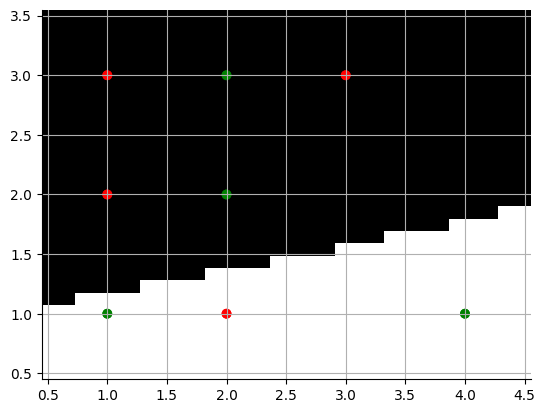

th [[ 15.  23.  17.  25.  28.   5.  11. -40.   2. -67.]] th0 [[15.]]


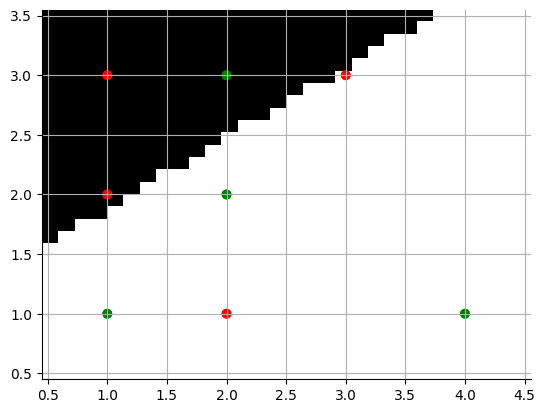

th [[ 16.  25.  20.  29.  34.  14.  19. -28.  20. -40.]] th0 [[16.]]


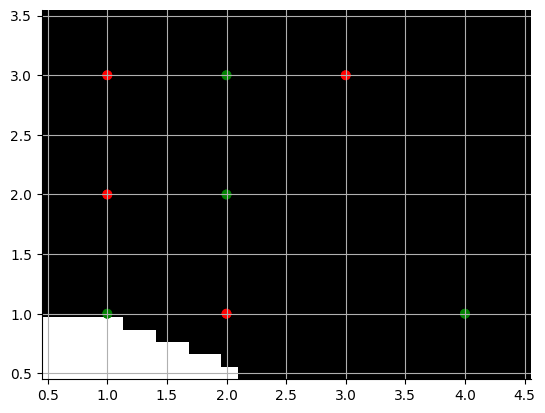

th [[ 15.  22.  17.  20.  25.   5.  -8. -55.  -7. -67.]] th0 [[15.]]


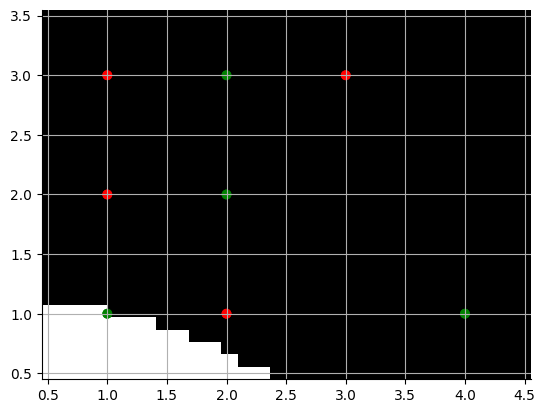

th [[ 16.  23.  18.  21.  26.   6.  -7. -54.  -6. -66.]] th0 [[16.]]


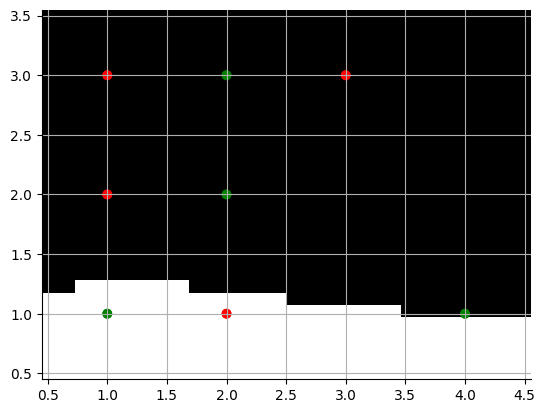

th [[ 17.  25.  20.  25.  30.  10.   1. -46.   2. -58.]] th0 [[17.]]


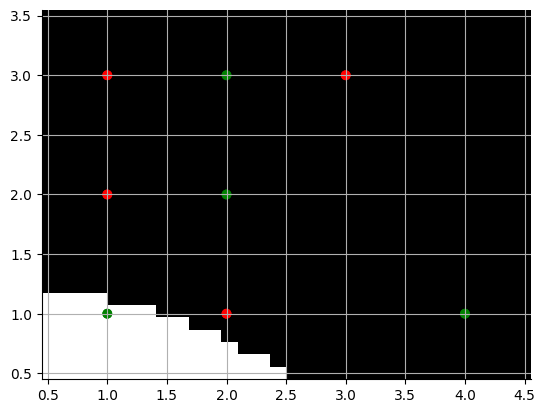

th [[ 16.  23.  19.  21.  28.   9.  -7. -50.   0. -59.]] th0 [[16.]]


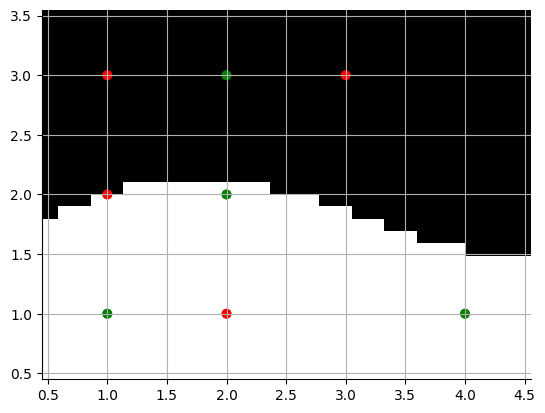

th [[ 17.  25.  22.  25.  34.  18.   1. -38.  18. -32.]] th0 [[17.]]


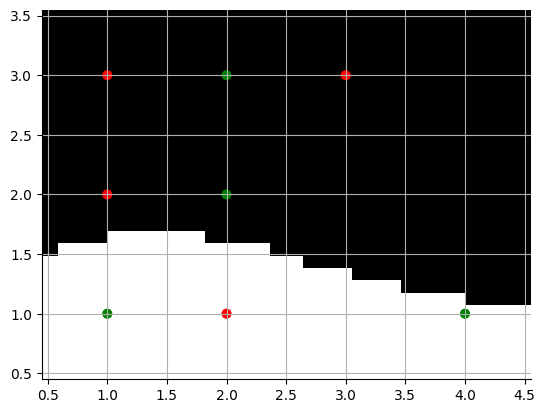

th [[ 16.  24.  20.  24.  32.  14.   0. -40.  14. -40.]] th0 [[16.]]


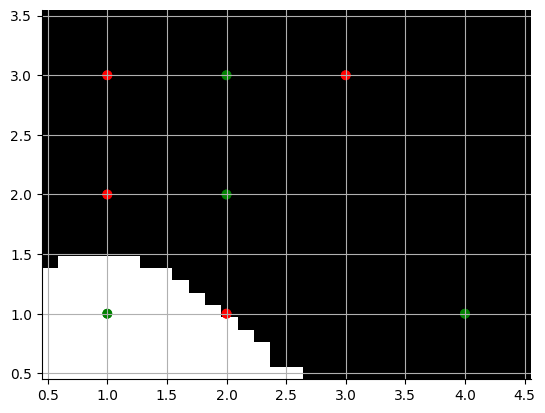

th [[ 15.  22.  19.  20.  30.  13.  -8. -44.  12. -41.]] th0 [[15.]]


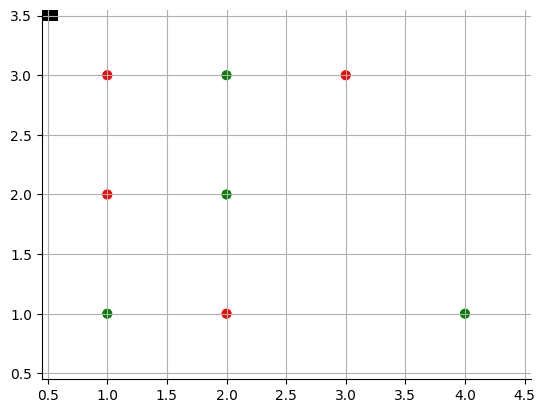

th [[ 16.  24.  22.  24.  36.  22.   0. -32.  30. -14.]] th0 [[16.]]


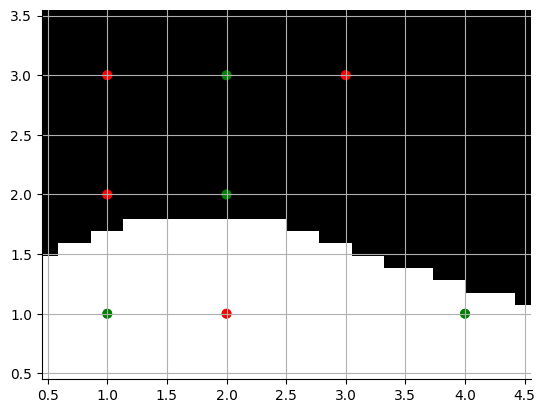

th [[ 15.  23.  19.  23.  33.  13.  -1. -35.  21. -41.]] th0 [[15.]]


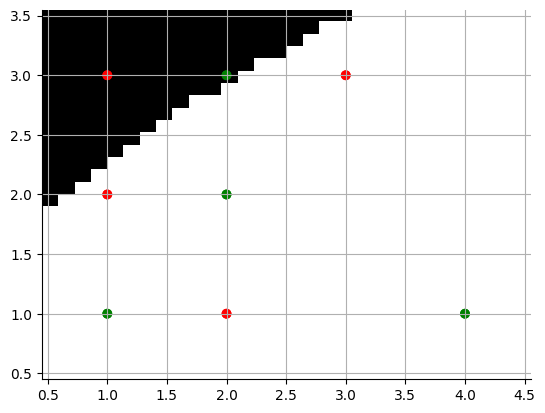

th [[ 16.  25.  21.  27.  37.  17.   7. -27.  29. -33.]] th0 [[16.]]


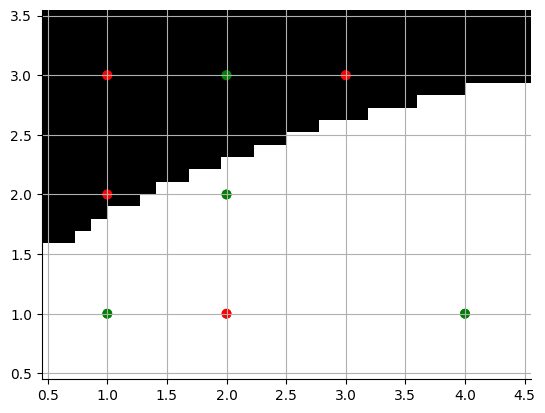

th [[ 15.  24.  19.  26.  35.  13.   6. -29.  25. -41.]] th0 [[15.]]


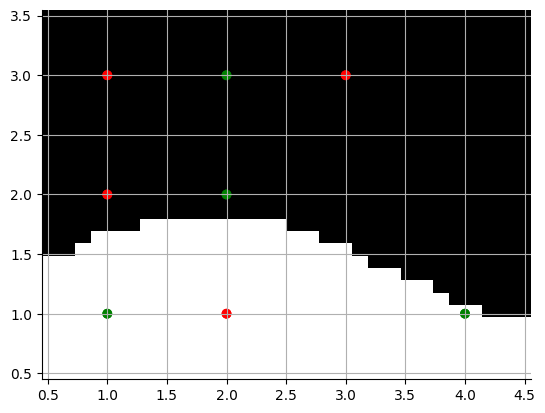

th [[ 14.  22.  18.  22.  33.  12.  -2. -33.  23. -42.]] th0 [[14.]]


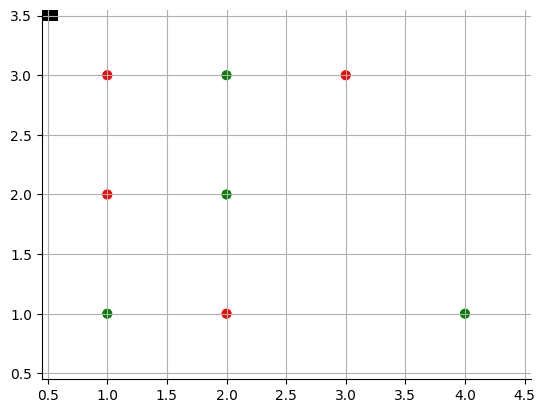

th [[ 15.  24.  21.  26.  39.  21.   6. -21.  41. -15.]] th0 [[15.]]


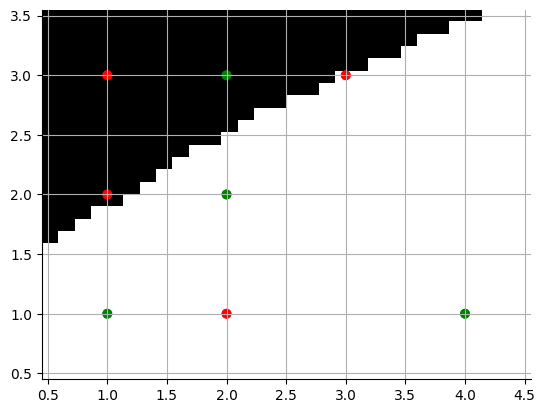

th [[ 14.  23.  18.  25.  36.  12.   5. -24.  32. -42.]] th0 [[14.]]


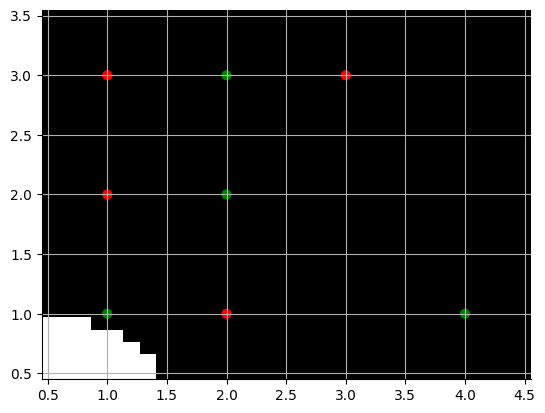

th [[ 13.  20.  15.  16.  27.   3. -22. -51.   5. -69.]] th0 [[13.]]


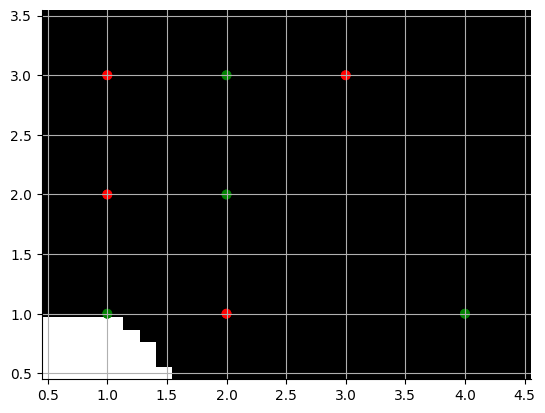

th [[ 14.  21.  16.  17.  28.   4. -21. -50.   6. -68.]] th0 [[14.]]


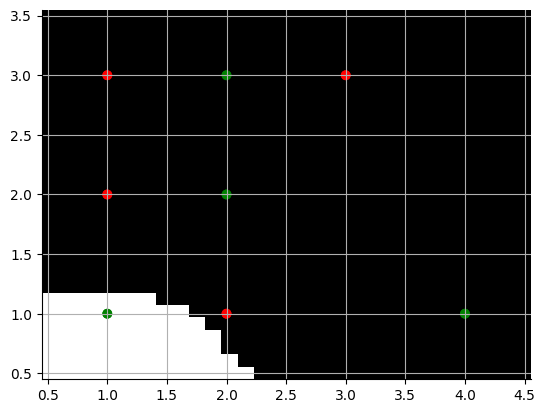

th [[ 15.  23.  18.  21.  32.   8. -13. -42.  14. -60.]] th0 [[15.]]


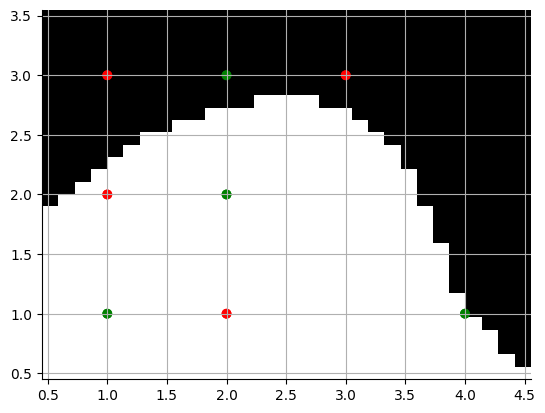

th [[ 16.  25.  21.  25.  38.  17.  -5. -30.  32. -33.]] th0 [[16.]]


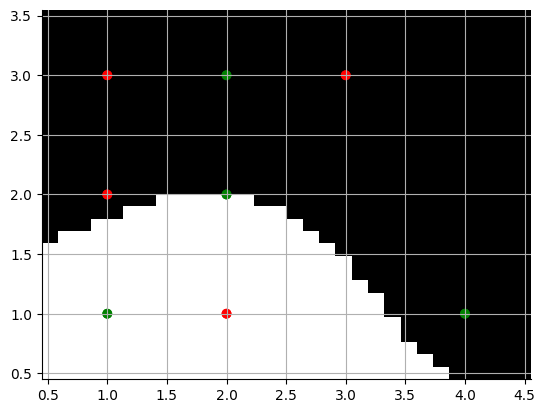

th [[ 15.  24.  19.  24.  36.  13.  -6. -32.  28. -41.]] th0 [[15.]]


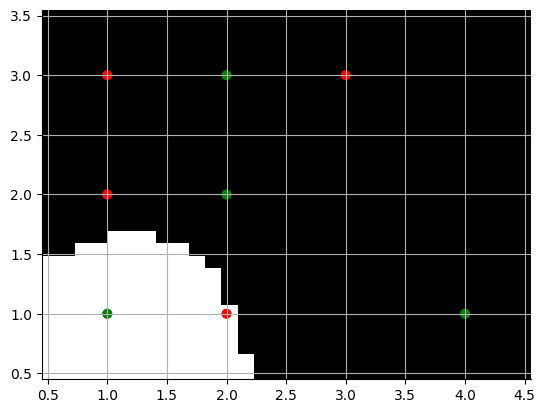

th [[ 14.  22.  18.  20.  34.  12. -14. -36.  26. -42.]] th0 [[14.]]


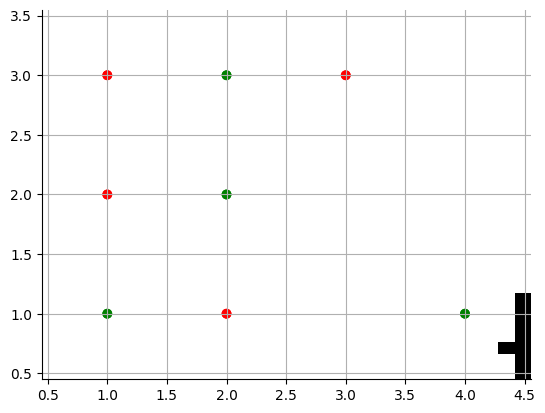

th [[ 15.  24.  21.  24.  40.  21.  -6. -24.  44. -15.]] th0 [[15.]]


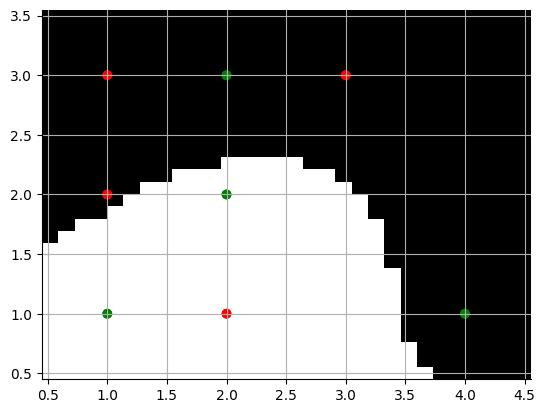

th [[ 14.  23.  18.  23.  37.  12.  -7. -27.  35. -42.]] th0 [[14.]]


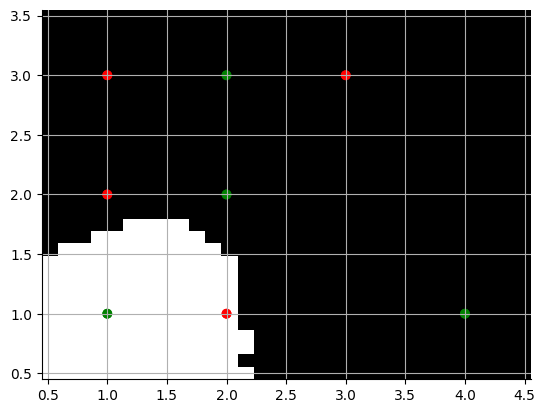

th [[ 13.  21.  17.  19.  35.  11. -15. -31.  33. -43.]] th0 [[13.]]


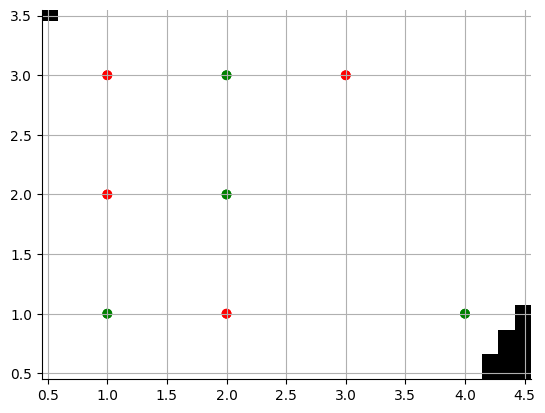

th [[ 14.  23.  20.  23.  41.  20.  -7. -19.  51. -16.]] th0 [[14.]]


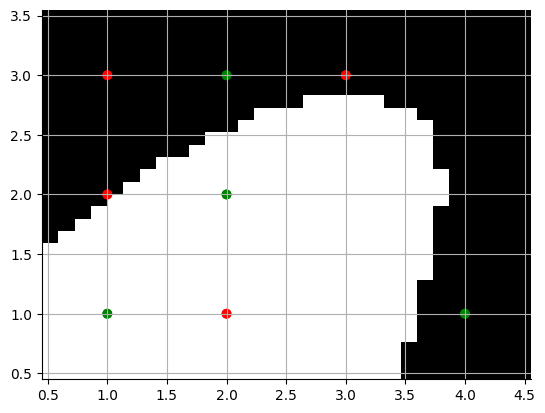

th [[ 13.  22.  17.  22.  38.  11.  -8. -22.  42. -43.]] th0 [[13.]]


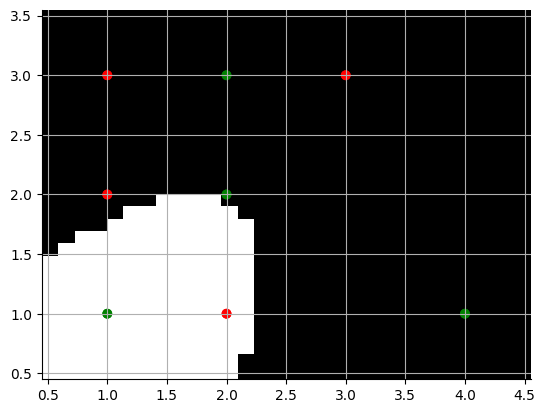

th [[ 12.  20.  16.  18.  36.  10. -16. -26.  40. -44.]] th0 [[12.]]


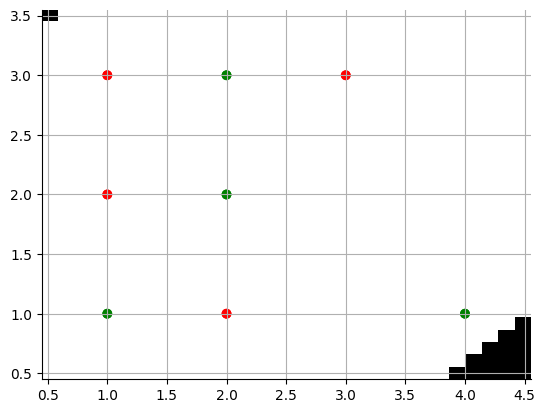

th [[ 13.  22.  19.  22.  42.  19.  -8. -14.  58. -17.]] th0 [[13.]]


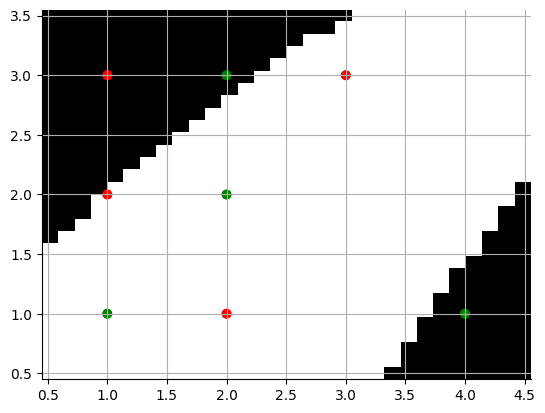

th [[ 12.  21.  16.  21.  39.  10.  -9. -17.  49. -44.]] th0 [[12.]]


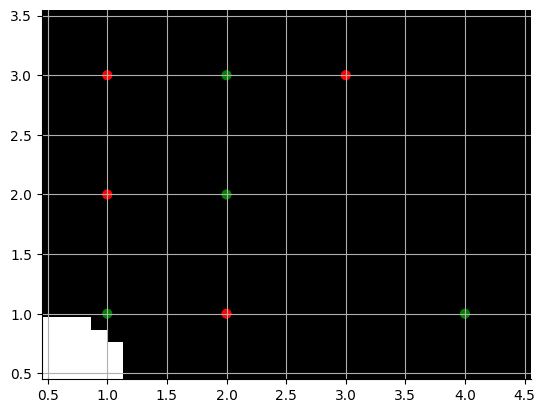

th [[ 11.  18.  13.  12.  30.   1. -36. -44.  22. -71.]] th0 [[11.]]


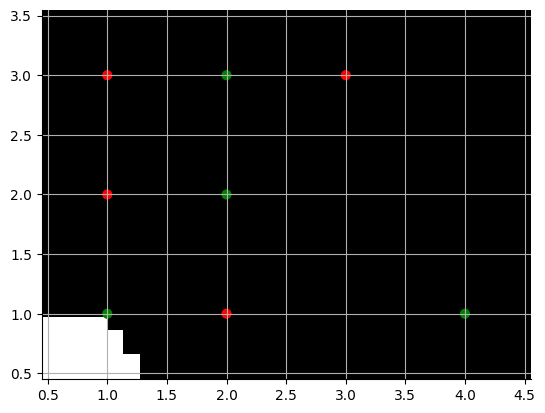

th [[ 12.  19.  14.  13.  31.   2. -35. -43.  23. -70.]] th0 [[12.]]


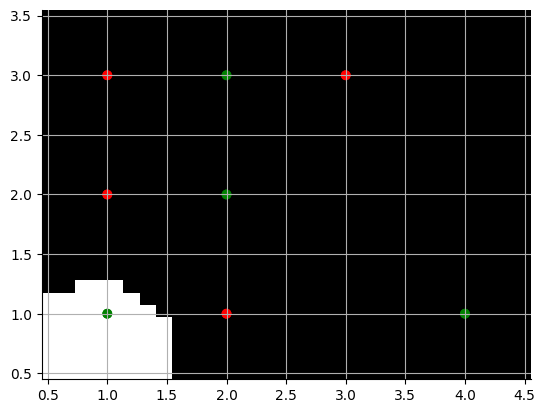

th [[ 13.  21.  16.  17.  35.   6. -27. -35.  31. -62.]] th0 [[13.]]


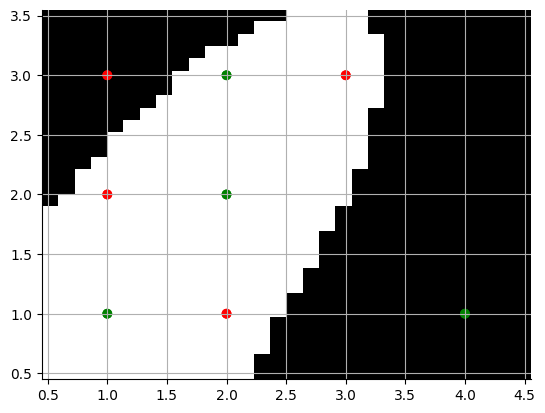

th [[ 14.  23.  19.  21.  41.  15. -19. -23.  49. -35.]] th0 [[14.]]


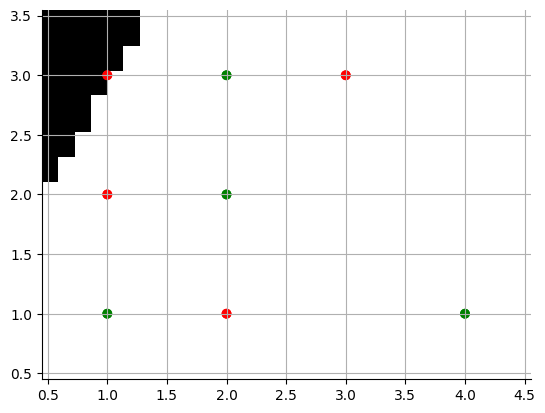

th [[ 15.  27.  20.  37.  45.  16.  45.  -7.  53. -34.]] th0 [[15.]]


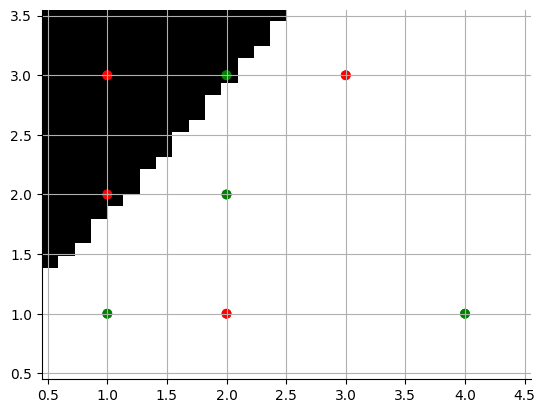

th [[ 14.  26.  17.  36.  42.   7.  44. -10.  44. -61.]] th0 [[14.]]


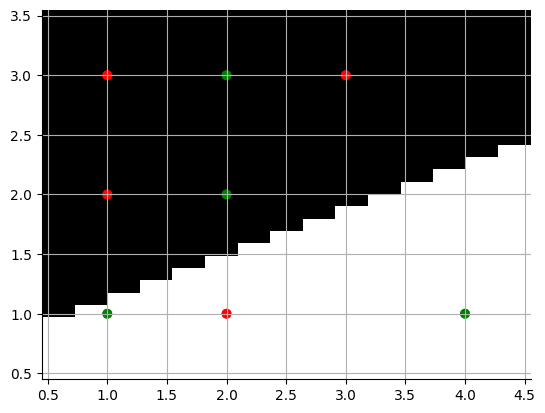

th [[ 13.  23.  14.  27.  33.  -2.  17. -37.  17. -88.]] th0 [[13.]]


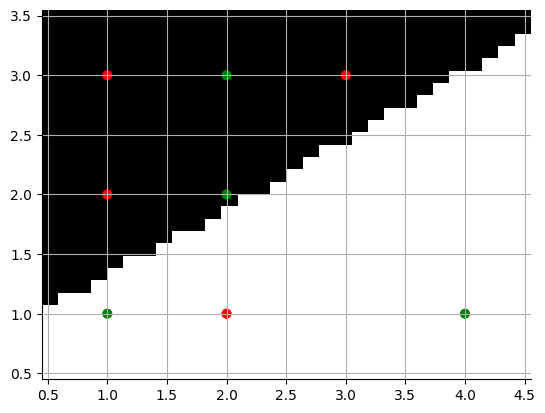

th [[ 14.  25.  16.  31.  37.   2.  25. -29.  25. -80.]] th0 [[14.]]


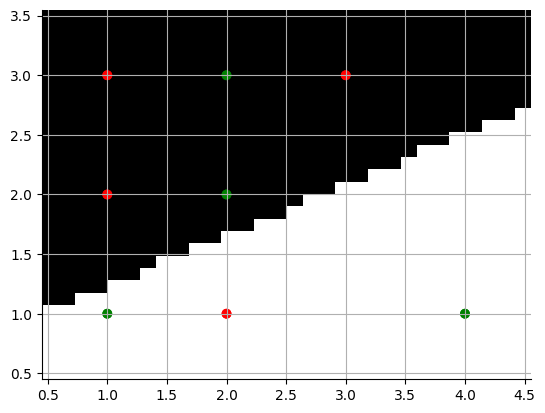

th [[ 13.  23.  15.  27.  35.   1.  17. -33.  23. -81.]] th0 [[13.]]


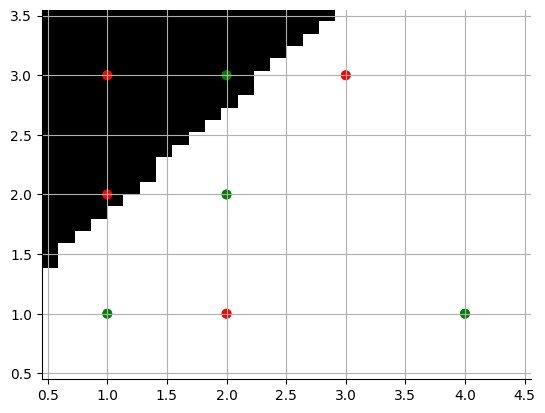

th [[ 14.  25.  18.  31.  41.  10.  25. -21.  41. -54.]] th0 [[14.]]


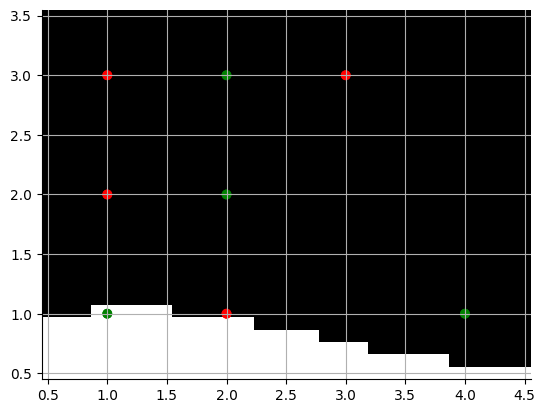

th [[ 13.  22.  15.  22.  32.   1.  -2. -48.  14. -81.]] th0 [[13.]]


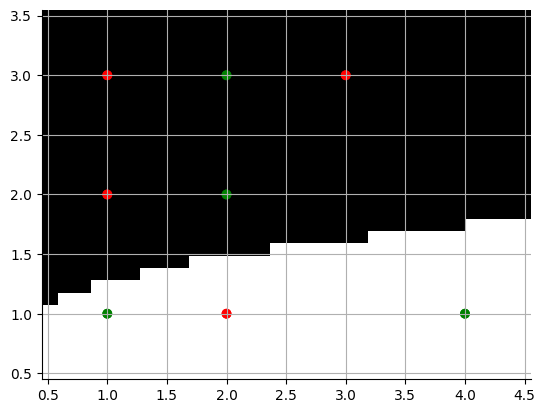

th [[ 14.  24.  17.  26.  36.   5.   6. -40.  22. -73.]] th0 [[14.]]


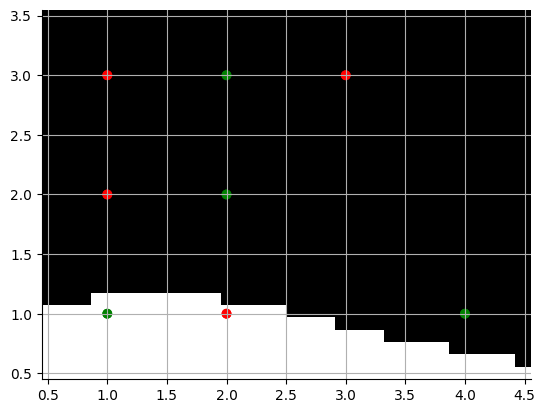

th [[ 13.  22.  16.  22.  34.   4.  -2. -44.  20. -74.]] th0 [[13.]]


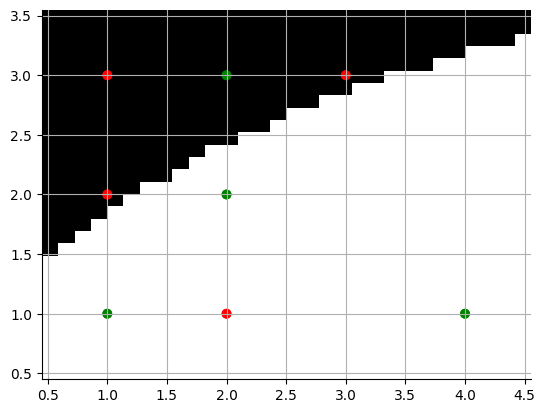

th [[ 14.  24.  19.  26.  40.  13.   6. -32.  38. -47.]] th0 [[14.]]


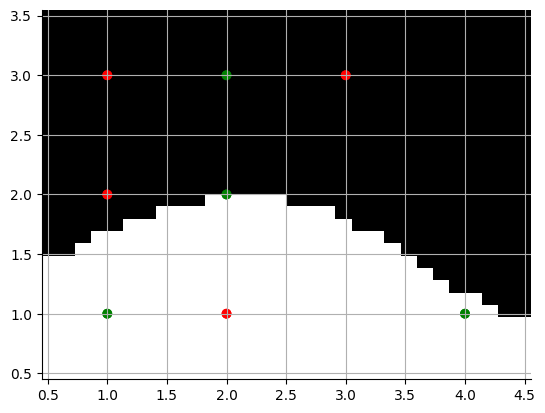

th [[ 13.  22.  18.  22.  38.  12.  -2. -36.  36. -48.]] th0 [[13.]]


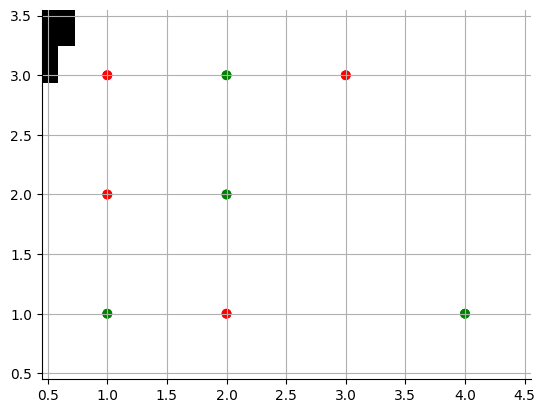

th [[ 14.  24.  21.  26.  44.  21.   6. -24.  54. -21.]] th0 [[14.]]


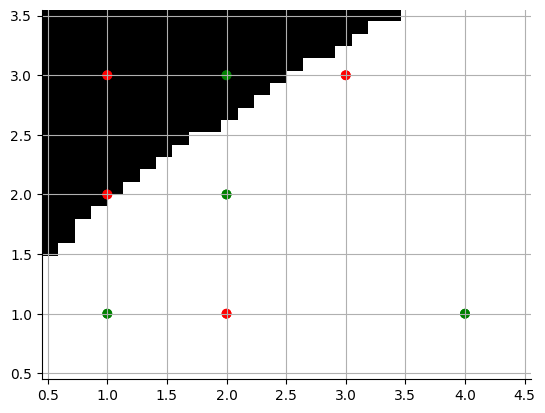

th [[ 13.  23.  18.  25.  41.  12.   5. -27.  45. -48.]] th0 [[13.]]


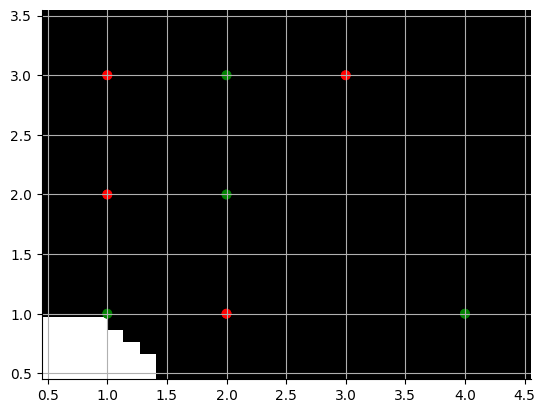

th [[ 12.  20.  15.  16.  32.   3. -22. -54.  18. -75.]] th0 [[12.]]


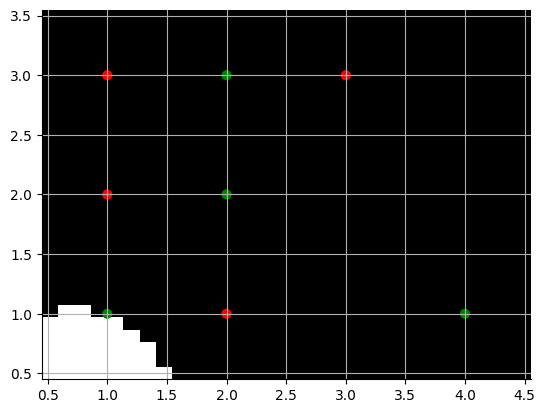

th [[ 13.  21.  16.  17.  33.   4. -21. -53.  19. -74.]] th0 [[13.]]


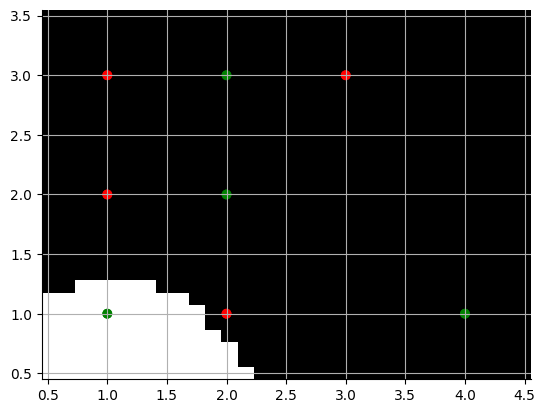

th [[ 14.  23.  18.  21.  37.   8. -13. -45.  27. -66.]] th0 [[14.]]


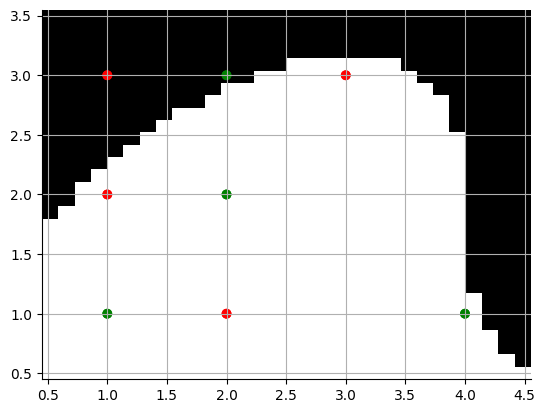

th [[ 15.  25.  21.  25.  43.  17.  -5. -33.  45. -39.]] th0 [[15.]]


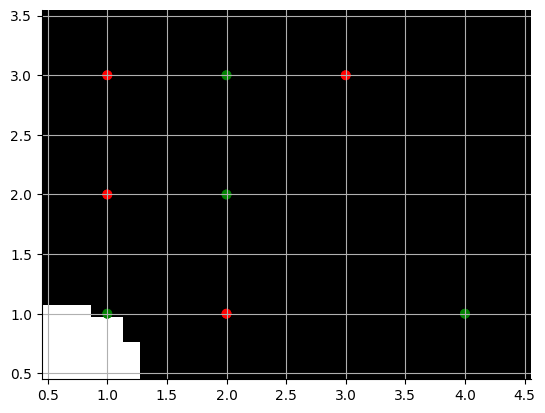

th [[ 14.  22.  18.  16.  34.   8. -32. -60.  18. -66.]] th0 [[14.]]


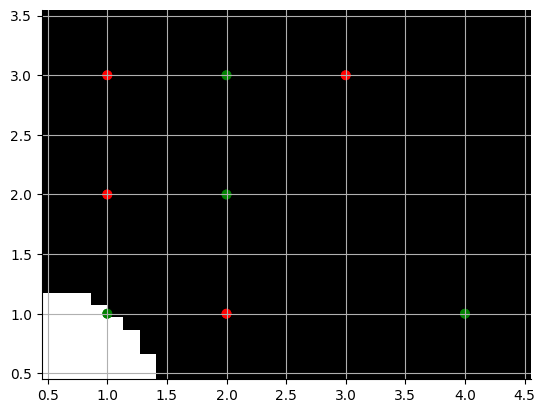

th [[ 15.  23.  19.  17.  35.   9. -31. -59.  19. -65.]] th0 [[15.]]


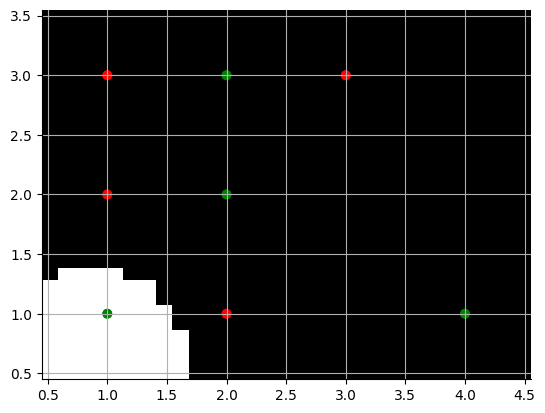

th [[ 16.  25.  21.  21.  39.  13. -23. -51.  27. -57.]] th0 [[16.]]


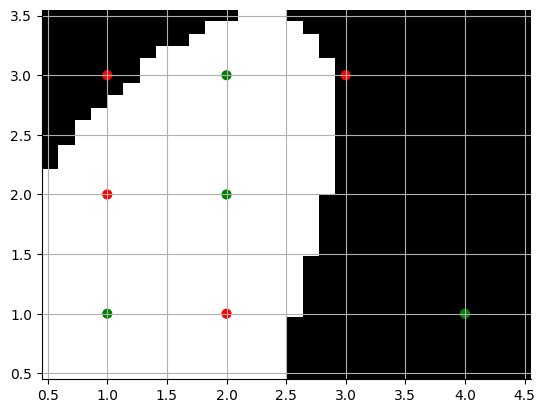

th [[ 17.  27.  24.  25.  45.  22. -15. -39.  45. -30.]] th0 [[17.]]


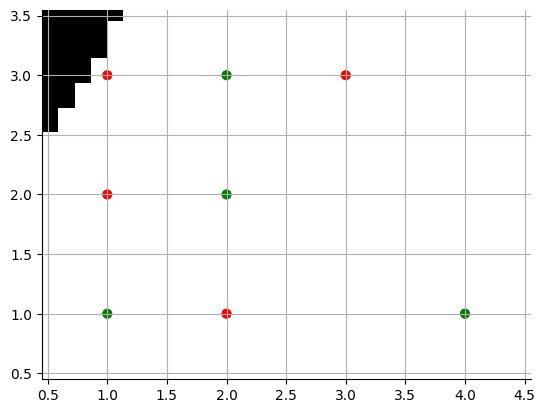

th [[ 18.  31.  25.  41.  49.  23.  49. -23.  49. -29.]] th0 [[18.]]


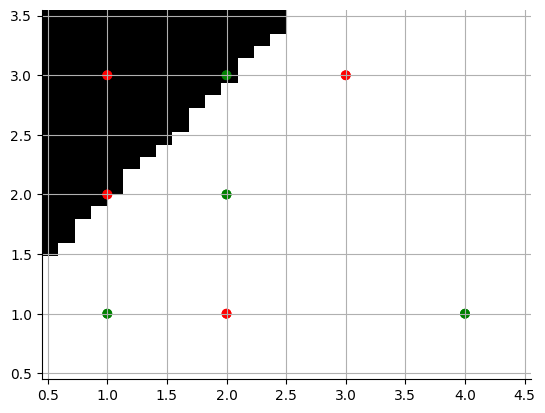

th [[ 17.  30.  22.  40.  46.  14.  48. -26.  40. -56.]] th0 [[17.]]


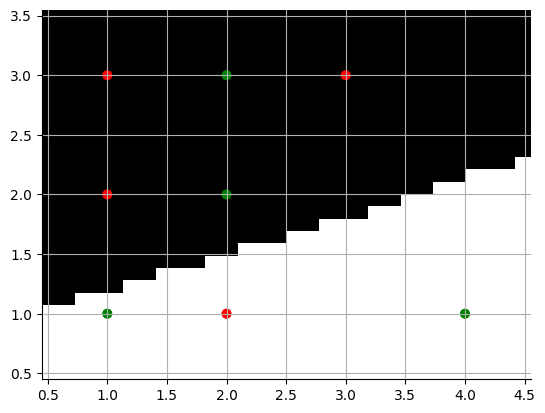

th [[ 16.  27.  19.  31.  37.   5.  21. -53.  13. -83.]] th0 [[16.]]


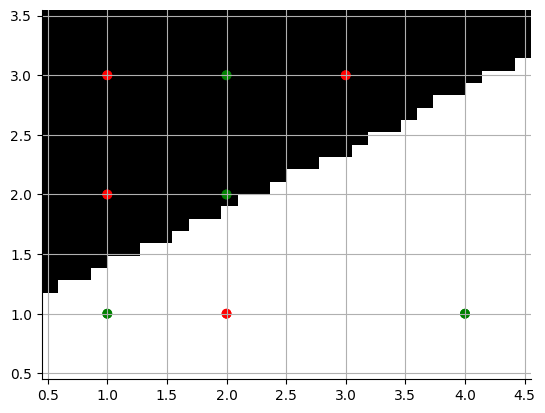

th [[ 17.  29.  21.  35.  41.   9.  29. -45.  21. -75.]] th0 [[17.]]


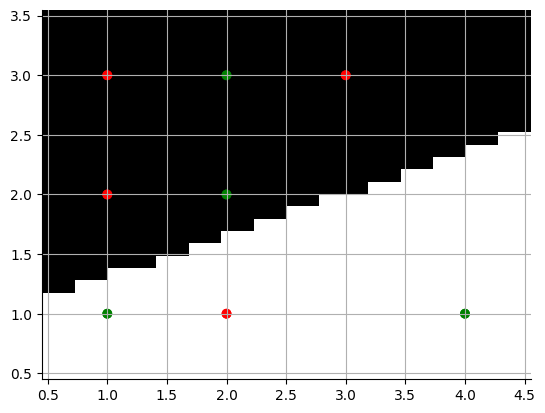

th [[ 16.  27.  20.  31.  39.   8.  21. -49.  19. -76.]] th0 [[16.]]


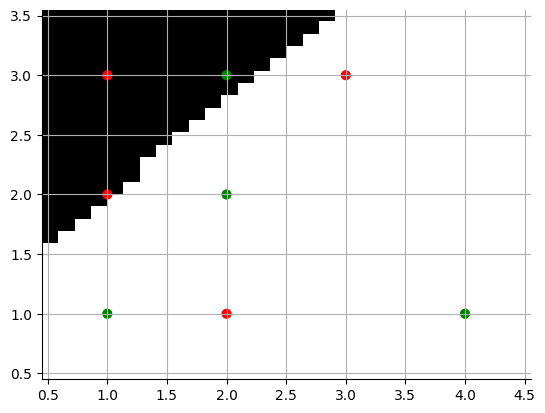

th [[ 17.  29.  23.  35.  45.  17.  29. -37.  37. -49.]] th0 [[17.]]


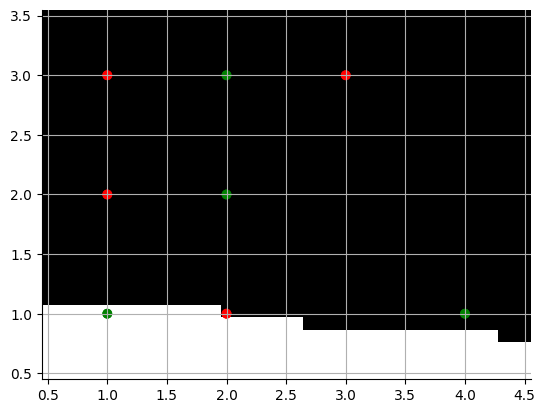

th [[ 16.  26.  20.  26.  36.   8.   2. -64.  10. -76.]] th0 [[16.]]


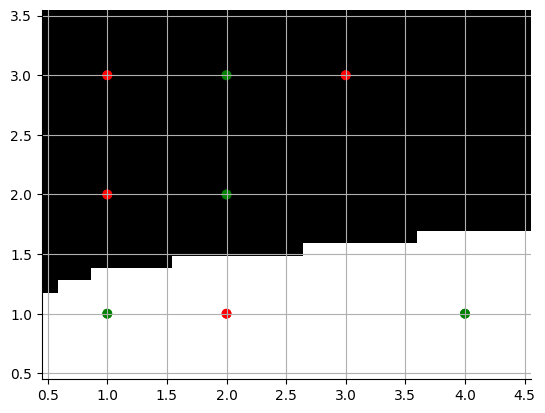

th [[ 17.  28.  22.  30.  40.  12.  10. -56.  18. -68.]] th0 [[17.]]


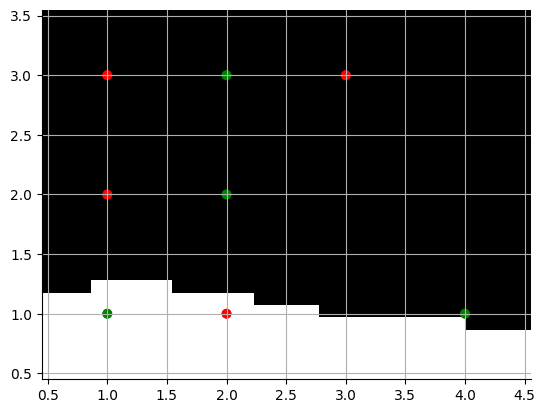

th [[ 16.  26.  21.  26.  38.  11.   2. -60.  16. -69.]] th0 [[16.]]


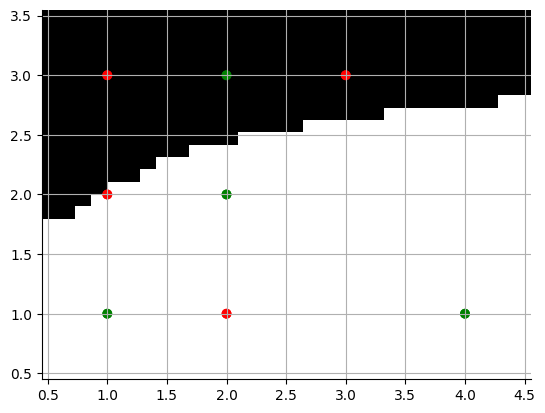

th [[ 17.  28.  24.  30.  44.  20.  10. -48.  34. -42.]] th0 [[17.]]


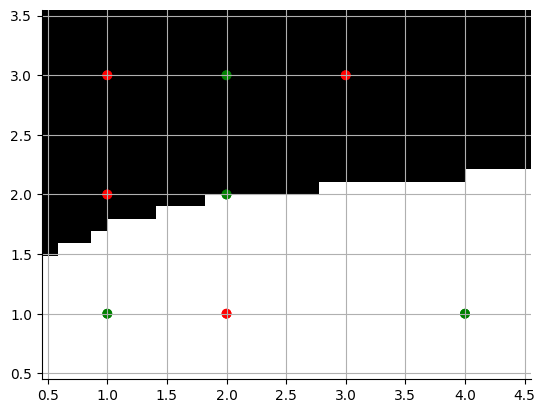

th [[ 16.  27.  22.  29.  42.  16.   9. -50.  30. -50.]] th0 [[16.]]


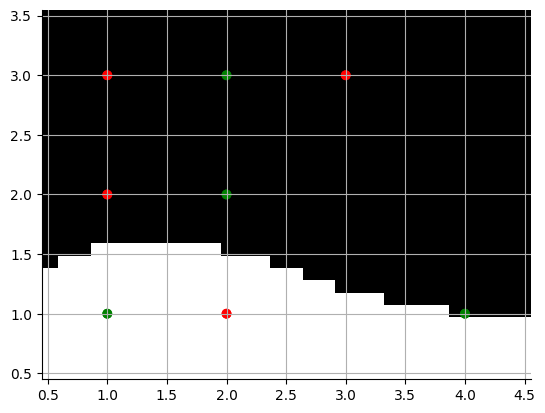

th [[ 15.  25.  21.  25.  40.  15.   1. -54.  28. -51.]] th0 [[15.]]


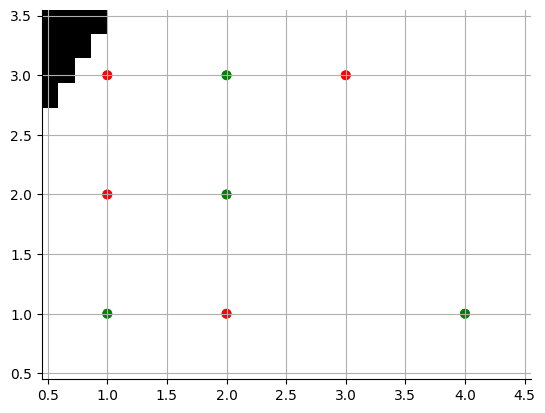

th [[ 16.  27.  24.  29.  46.  24.   9. -42.  46. -24.]] th0 [[16.]]


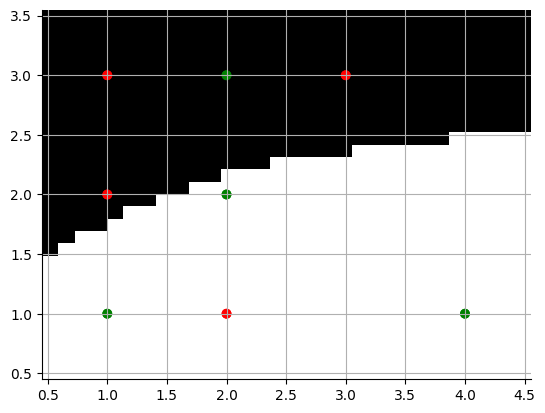

th [[ 15.  26.  21.  28.  43.  15.   8. -45.  37. -51.]] th0 [[15.]]


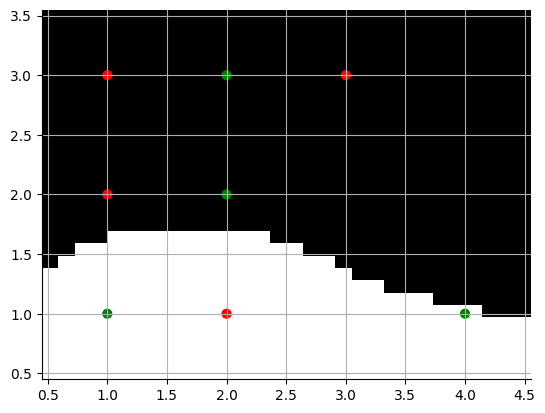

th [[ 14.  24.  20.  24.  41.  14.   0. -49.  35. -52.]] th0 [[14.]]


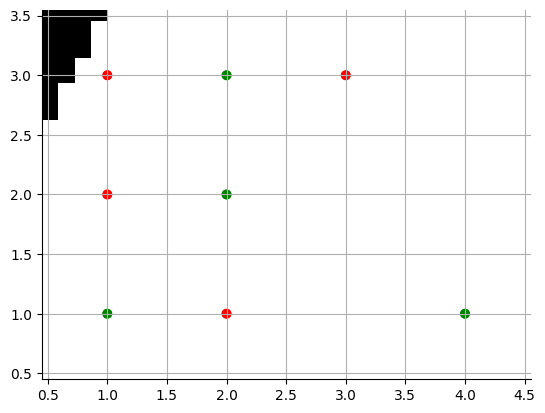

th [[ 15.  26.  23.  28.  47.  23.   8. -37.  53. -25.]] th0 [[15.]]


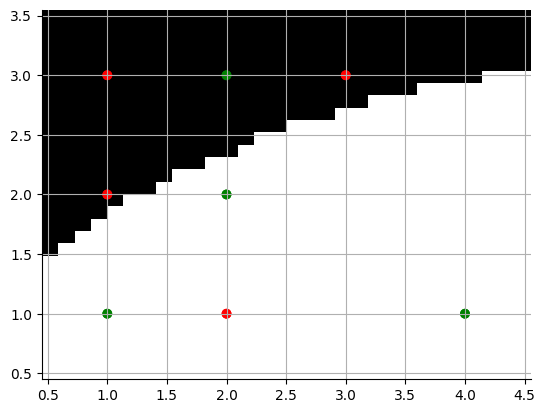

th [[ 14.  25.  20.  27.  44.  14.   7. -40.  44. -52.]] th0 [[14.]]


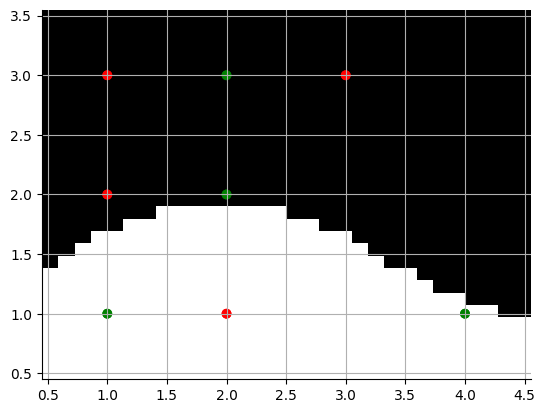

th [[ 13.  23.  19.  23.  42.  13.  -1. -44.  42. -53.]] th0 [[13.]]


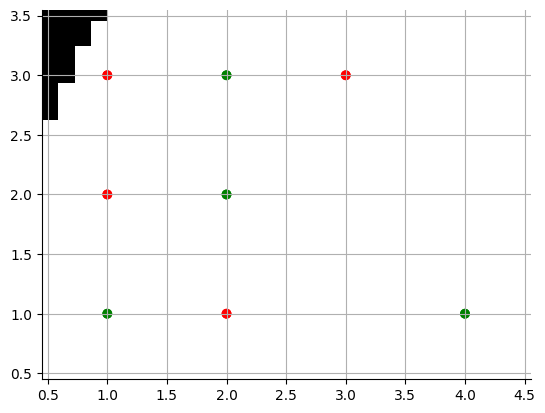

th [[ 14.  25.  22.  27.  48.  22.   7. -32.  60. -26.]] th0 [[14.]]


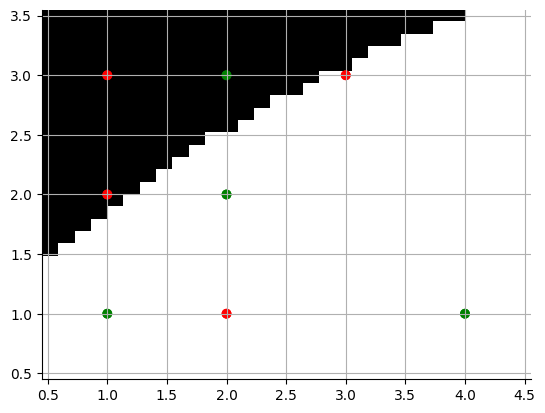

th [[ 13.  24.  19.  26.  45.  13.   6. -35.  51. -53.]] th0 [[13.]]


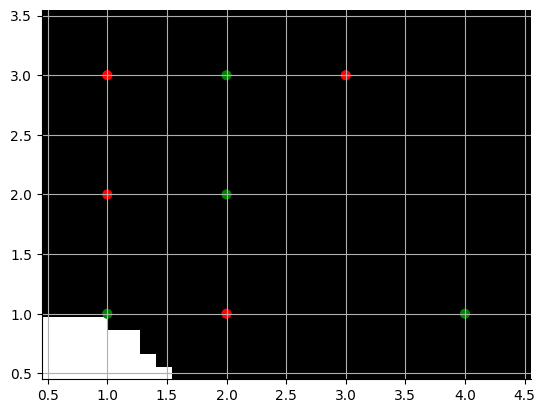

th [[ 12.  21.  16.  17.  36.   4. -21. -62.  24. -80.]] th0 [[12.]]


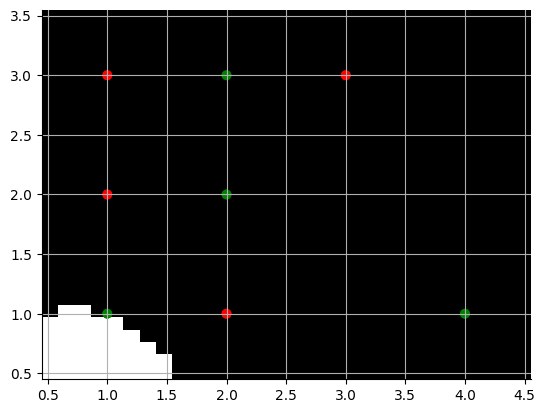

th [[ 13.  22.  17.  18.  37.   5. -20. -61.  25. -79.]] th0 [[13.]]


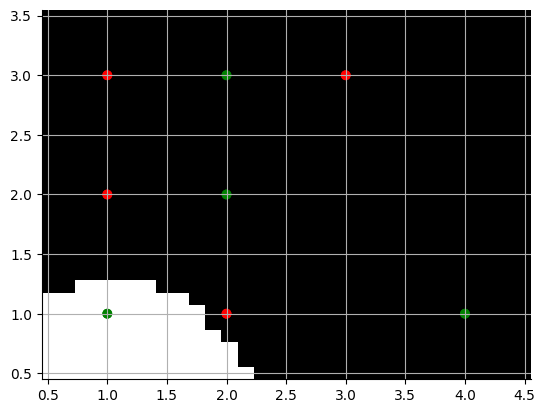

th [[ 14.  24.  19.  22.  41.   9. -12. -53.  33. -71.]] th0 [[14.]]


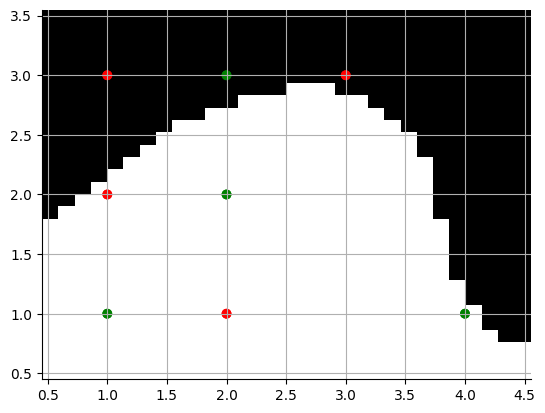

th [[ 15.  26.  22.  26.  47.  18.  -4. -41.  51. -44.]] th0 [[15.]]


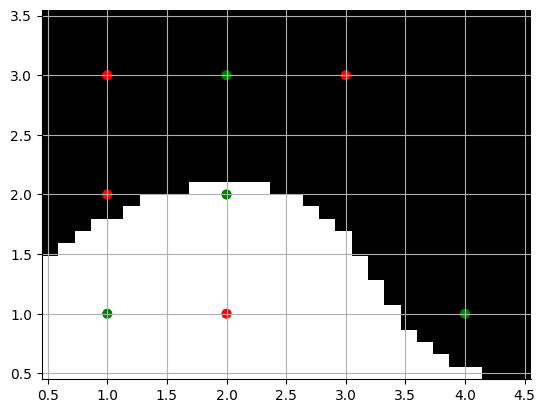

th [[ 14.  25.  20.  25.  45.  14.  -5. -43.  47. -52.]] th0 [[14.]]


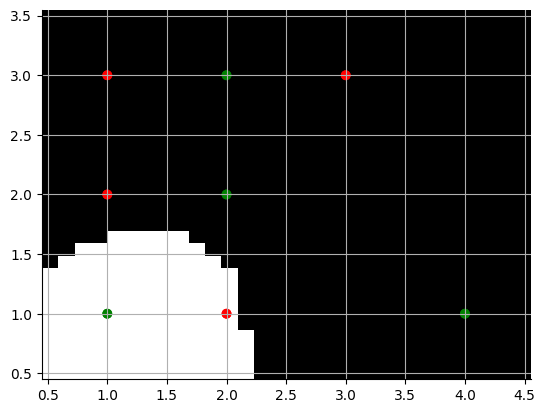

th [[ 13.  23.  19.  21.  43.  13. -13. -47.  45. -53.]] th0 [[13.]]


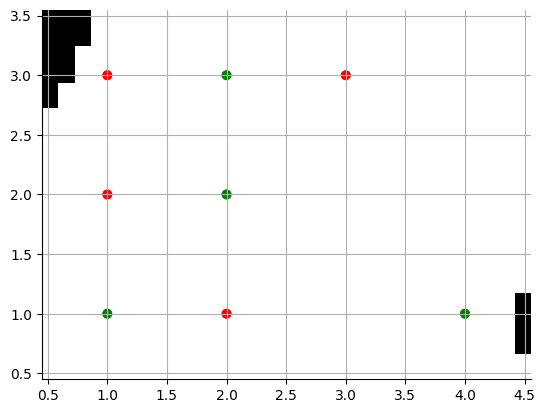

th [[ 14.  25.  22.  25.  49.  22.  -5. -35.  63. -26.]] th0 [[14.]]


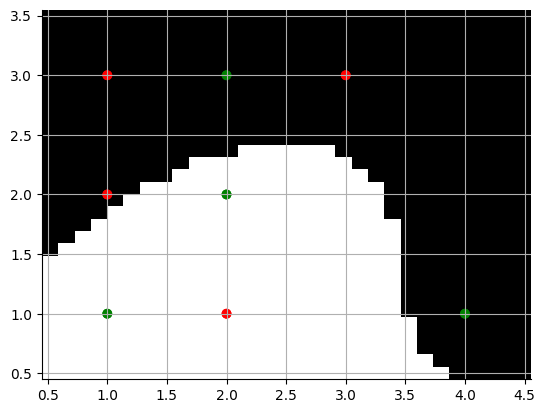

th [[ 13.  24.  19.  24.  46.  13.  -6. -38.  54. -53.]] th0 [[13.]]


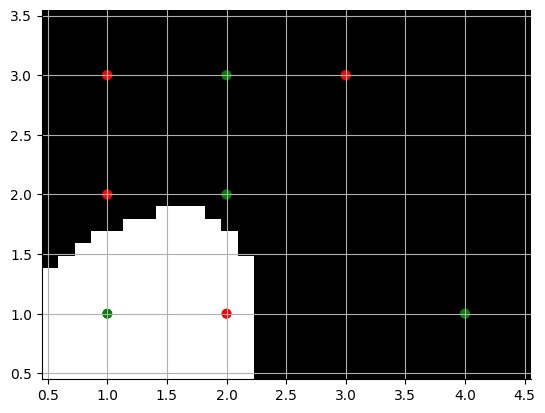

th [[ 12.  22.  18.  20.  44.  12. -14. -42.  52. -54.]] th0 [[12.]]


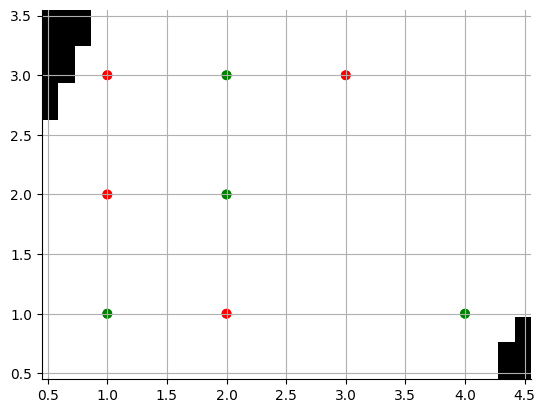

th [[ 13.  24.  21.  24.  50.  21.  -6. -30.  70. -27.]] th0 [[13.]]


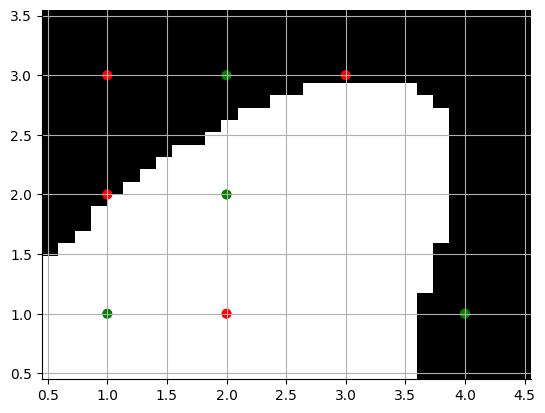

th [[ 12.  23.  18.  23.  47.  12.  -7. -33.  61. -54.]] th0 [[12.]]


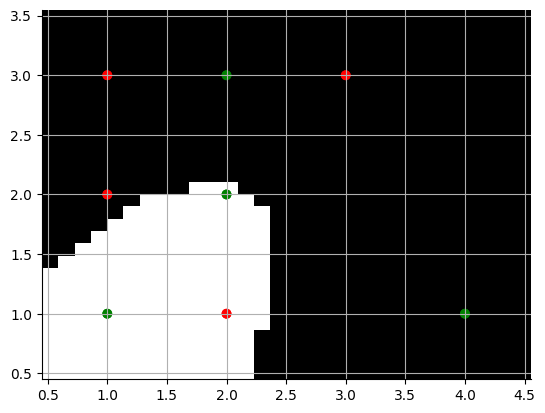

th [[ 11.  21.  17.  19.  45.  11. -15. -37.  59. -55.]] th0 [[11.]]


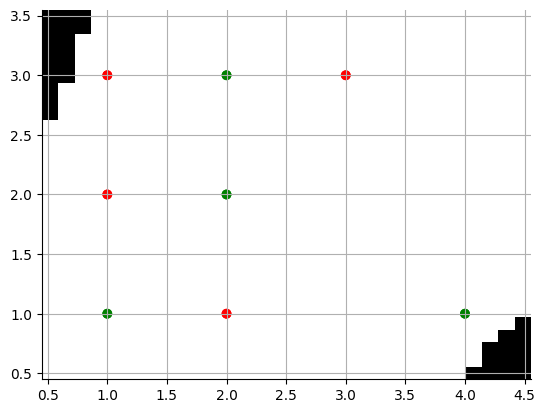

th [[ 12.  23.  20.  23.  51.  20.  -7. -25.  77. -28.]] th0 [[12.]]


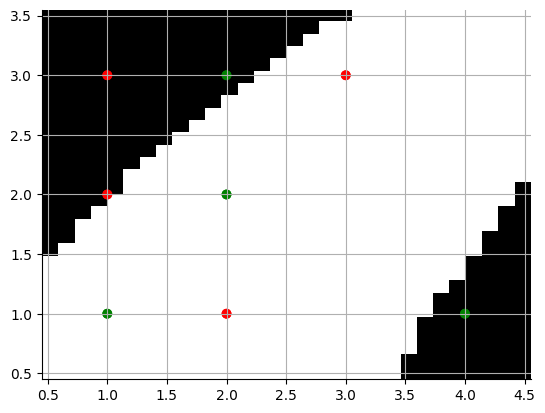

th [[ 11.  22.  17.  22.  48.  11.  -8. -28.  68. -55.]] th0 [[11.]]


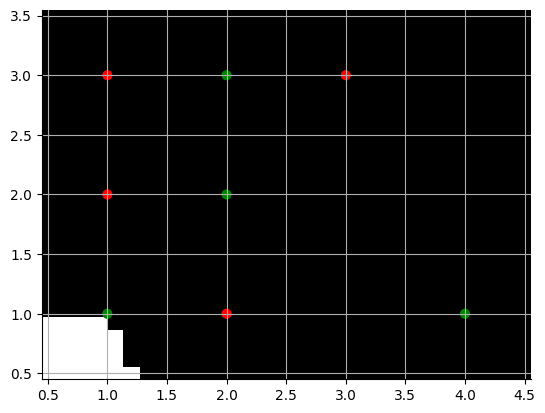

th [[ 10.  19.  14.  13.  39.   2. -35. -55.  41. -82.]] th0 [[10.]]


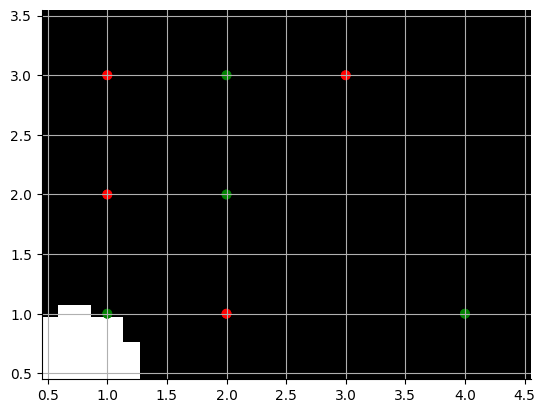

th [[ 11.  20.  15.  14.  40.   3. -34. -54.  42. -81.]] th0 [[11.]]


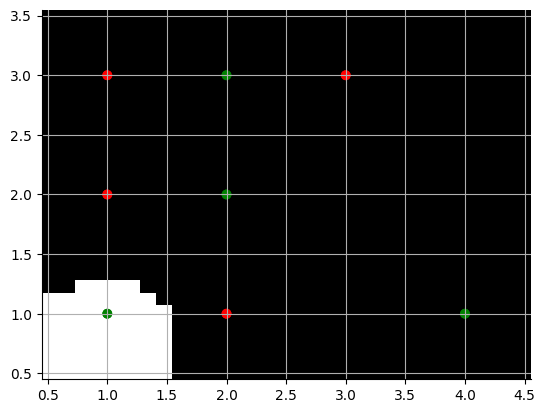

th [[ 12.  22.  17.  18.  44.   7. -26. -46.  50. -73.]] th0 [[12.]]


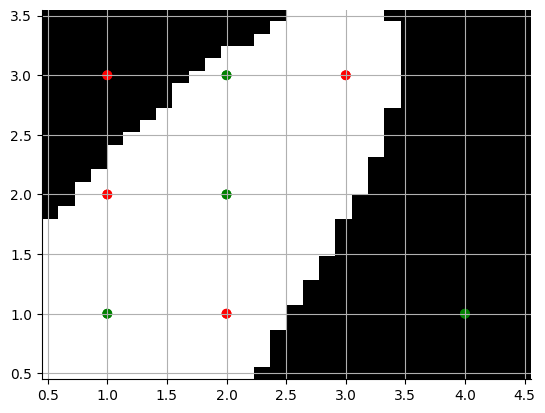

th [[ 13.  24.  20.  22.  50.  16. -18. -34.  68. -46.]] th0 [[13.]]


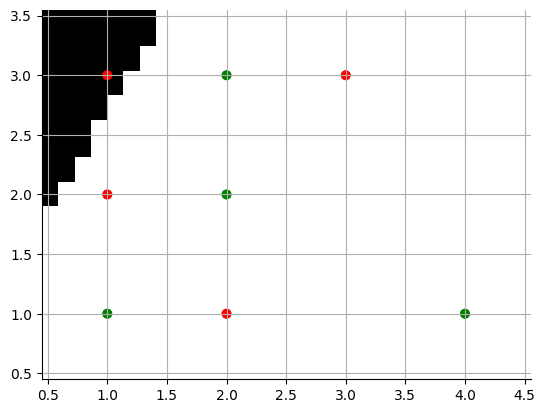

th [[ 14.  28.  21.  38.  54.  17.  46. -18.  72. -45.]] th0 [[14.]]


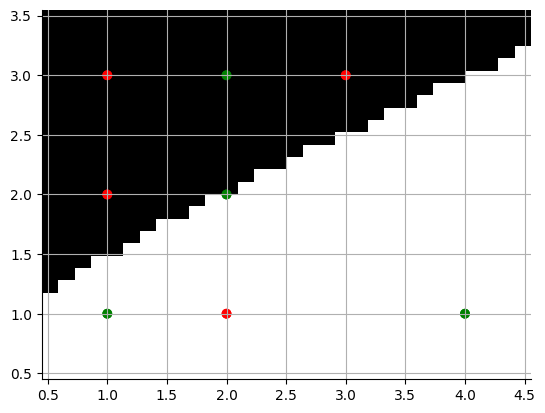

th [[ 13.  25.  18.  29.  45.   8.  19. -45.  45. -72.]] th0 [[13.]]


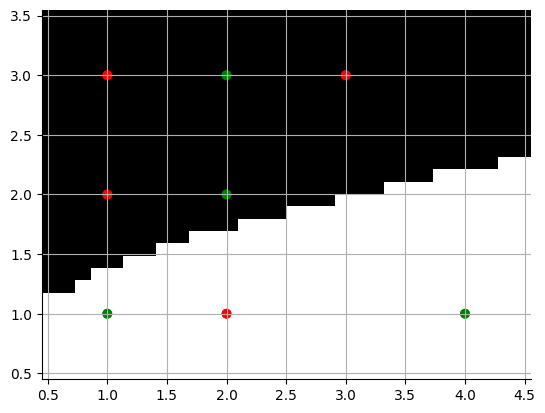

th [[ 12.  23.  17.  25.  43.   7.  11. -49.  43. -73.]] th0 [[12.]]


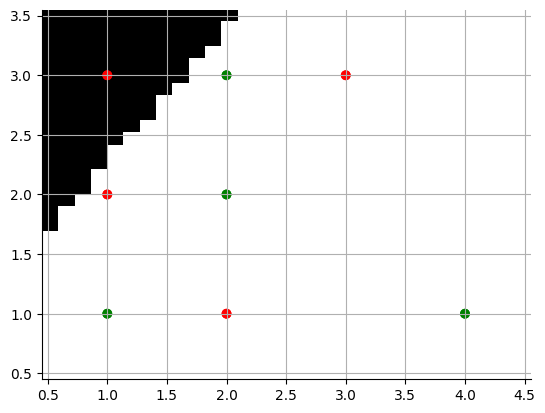

th [[ 13.  25.  20.  29.  49.  16.  19. -37.  61. -46.]] th0 [[13.]]


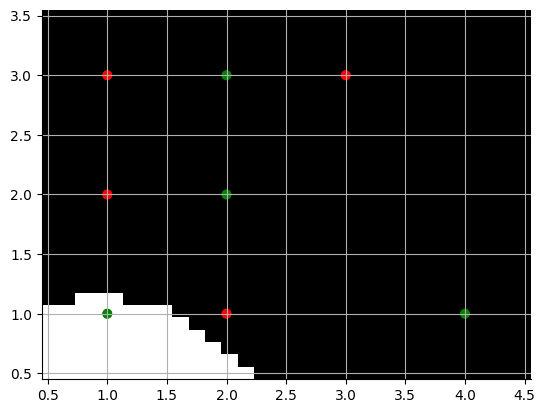

th [[ 12.  22.  17.  20.  40.   7.  -8. -64.  34. -73.]] th0 [[12.]]


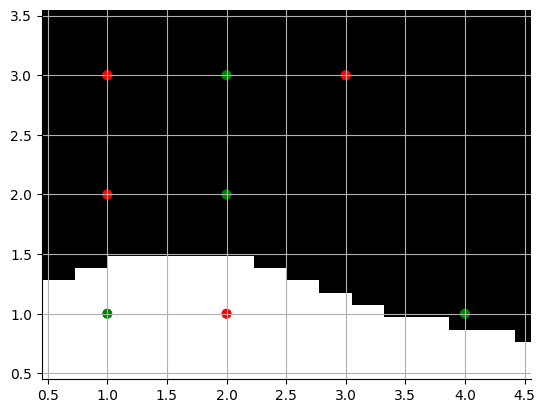

th [[ 13.  24.  19.  24.  44.  11.   0. -56.  42. -65.]] th0 [[13.]]


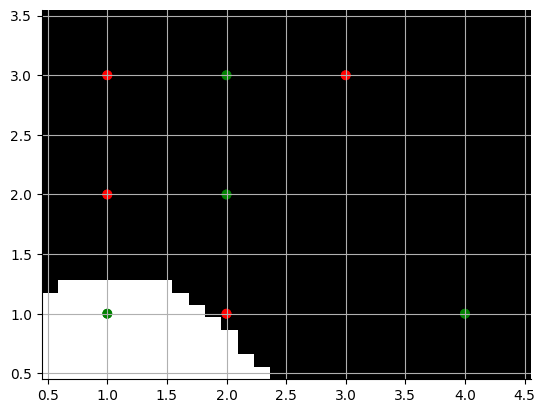

th [[ 12.  22.  18.  20.  42.  10.  -8. -60.  40. -66.]] th0 [[12.]]


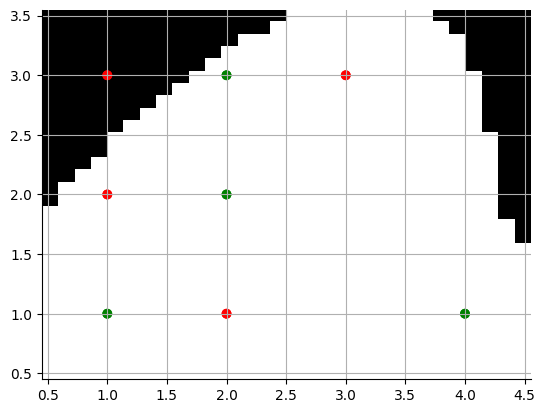

th [[ 13.  24.  21.  24.  48.  19.   0. -48.  58. -39.]] th0 [[13.]]


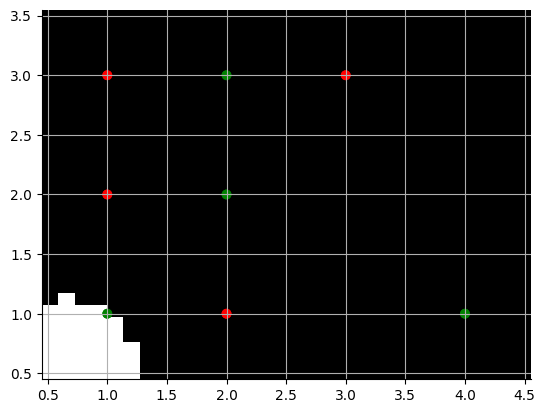

th [[ 12.  21.  18.  15.  39.  10. -27. -75.  31. -66.]] th0 [[12.]]


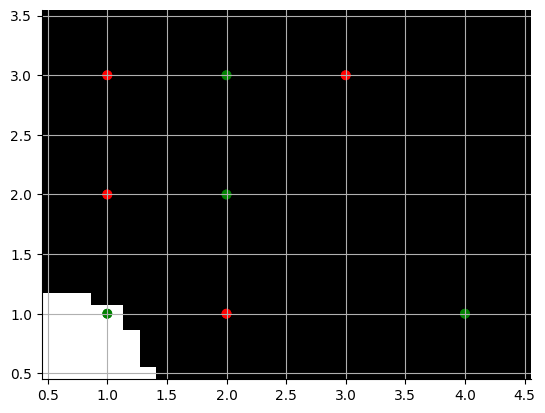

th [[ 13.  22.  19.  16.  40.  11. -26. -74.  32. -65.]] th0 [[13.]]


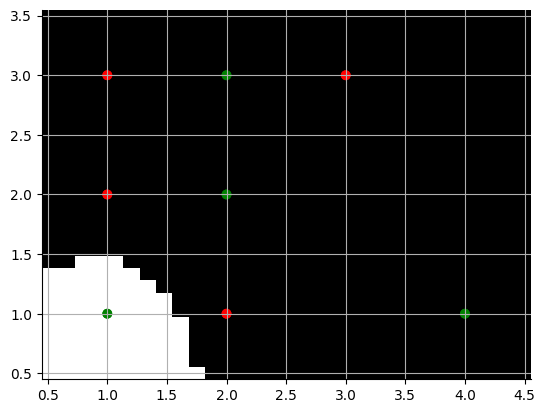

th [[ 14.  24.  21.  20.  44.  15. -18. -66.  40. -57.]] th0 [[14.]]


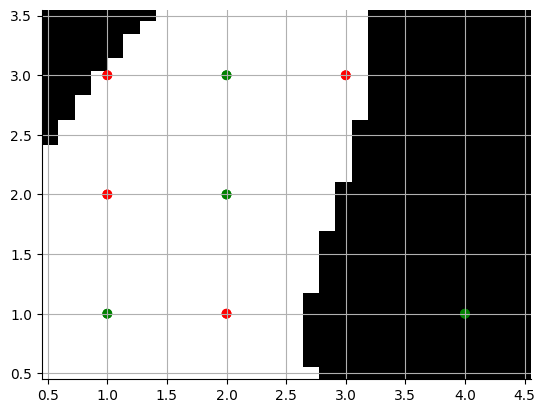

th [[ 15.  26.  24.  24.  50.  24. -10. -54.  58. -30.]] th0 [[15.]]


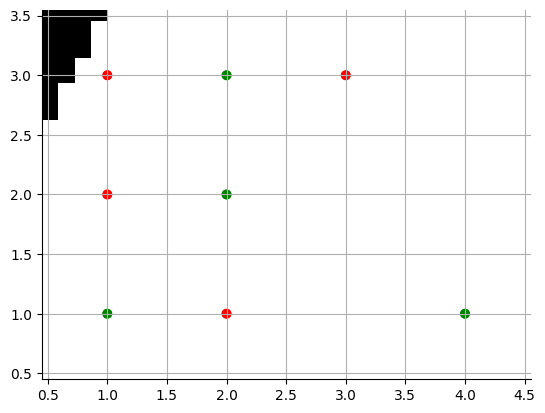

th [[ 16.  30.  25.  40.  54.  25.  54. -38.  62. -29.]] th0 [[16.]]


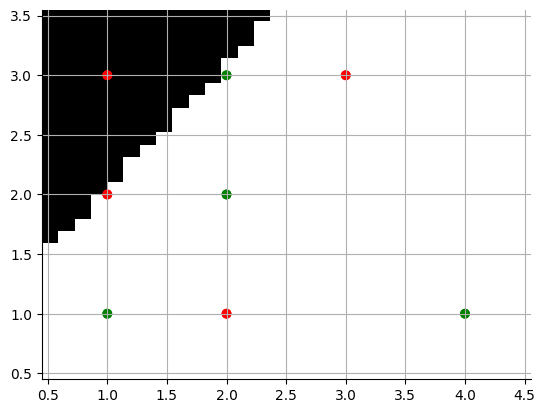

th [[ 15.  29.  22.  39.  51.  16.  53. -41.  53. -56.]] th0 [[15.]]


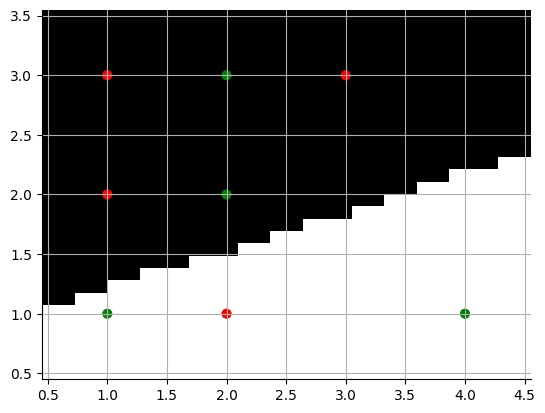

th [[ 14.  26.  19.  30.  42.   7.  26. -68.  26. -83.]] th0 [[14.]]


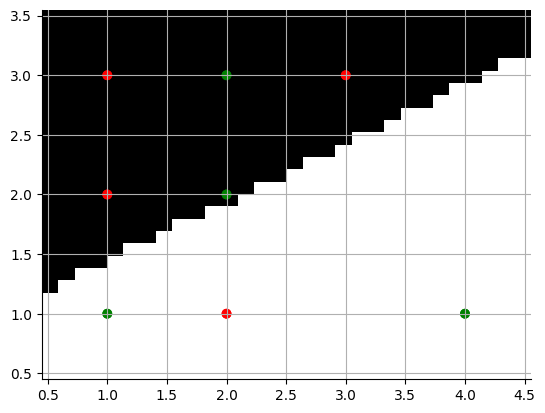

th [[ 15.  28.  21.  34.  46.  11.  34. -60.  34. -75.]] th0 [[15.]]


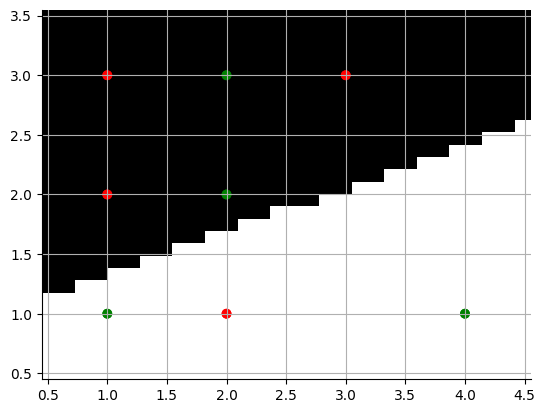

th [[ 14.  26.  20.  30.  44.  10.  26. -64.  32. -76.]] th0 [[14.]]


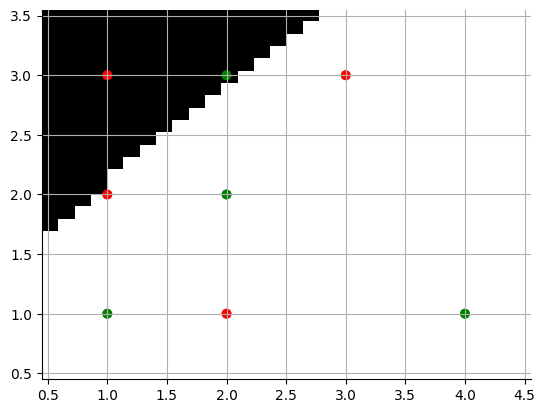

th [[ 15.  28.  23.  34.  50.  19.  34. -52.  50. -49.]] th0 [[15.]]


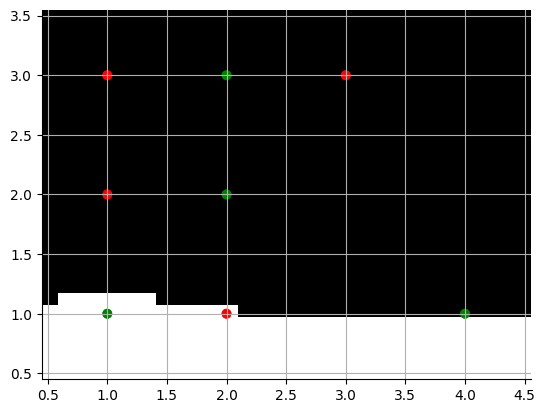

th [[ 14.  25.  20.  25.  41.  10.   7. -79.  23. -76.]] th0 [[14.]]


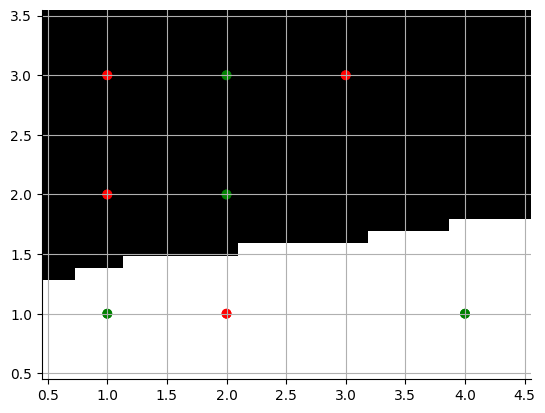

th [[ 15.  27.  22.  29.  45.  14.  15. -71.  31. -68.]] th0 [[15.]]


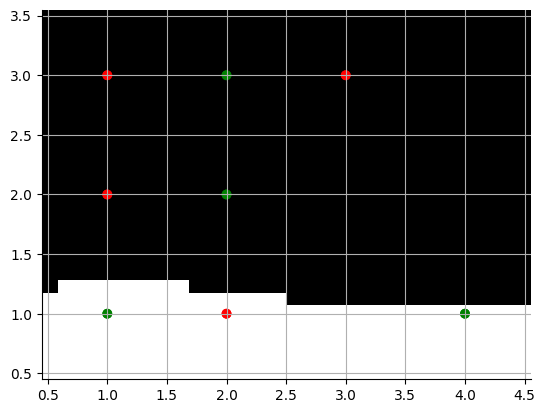

th [[ 14.  25.  21.  25.  43.  13.   7. -75.  29. -69.]] th0 [[14.]]


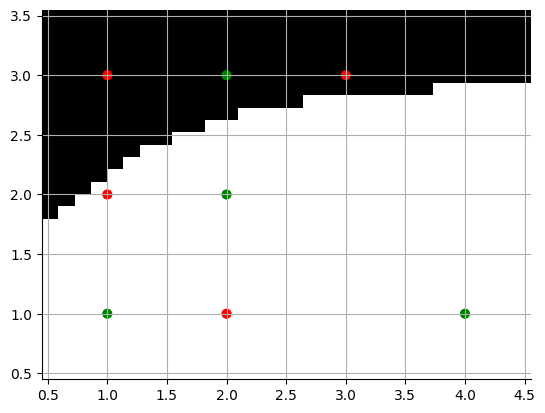

th [[ 15.  27.  24.  29.  49.  22.  15. -63.  47. -42.]] th0 [[15.]]


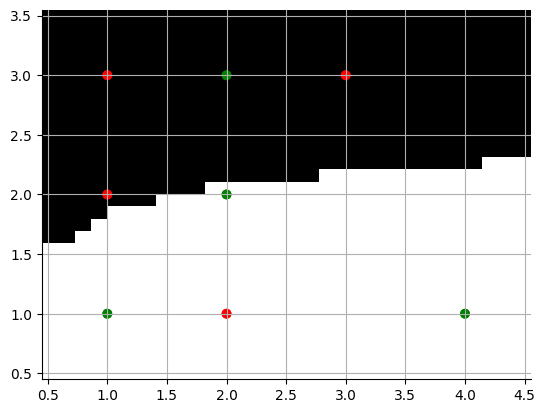

th [[ 14.  26.  22.  28.  47.  18.  14. -65.  43. -50.]] th0 [[14.]]


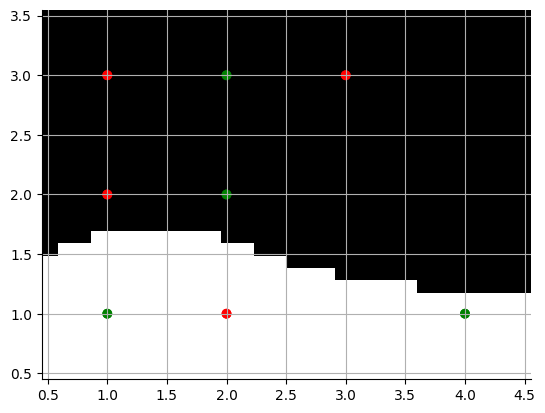

th [[ 13.  24.  21.  24.  45.  17.   6. -69.  41. -51.]] th0 [[13.]]


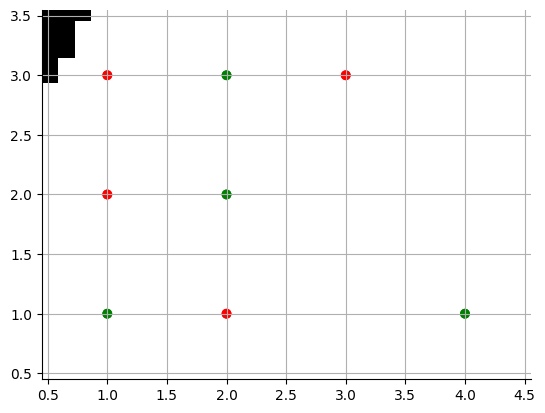

th [[ 14.  26.  24.  28.  51.  26.  14. -57.  59. -24.]] th0 [[14.]]


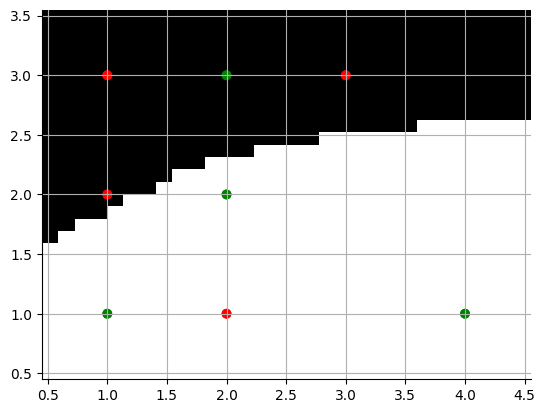

th [[ 13.  25.  21.  27.  48.  17.  13. -60.  50. -51.]] th0 [[13.]]


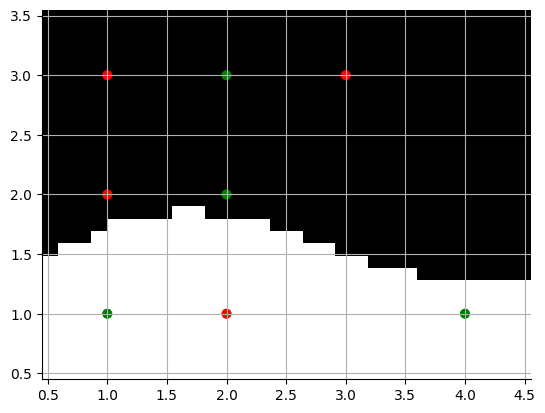

th [[ 12.  23.  20.  23.  46.  16.   5. -64.  48. -52.]] th0 [[12.]]


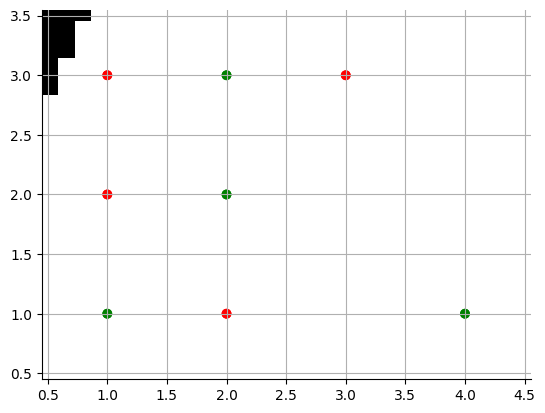

th [[ 13.  25.  23.  27.  52.  25.  13. -52.  66. -25.]] th0 [[13.]]


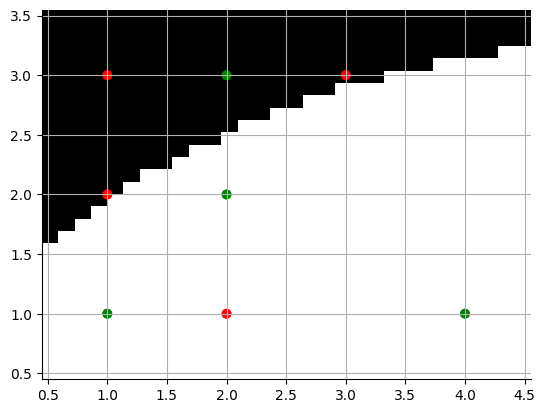

th [[ 12.  24.  20.  26.  49.  16.  12. -55.  57. -52.]] th0 [[12.]]


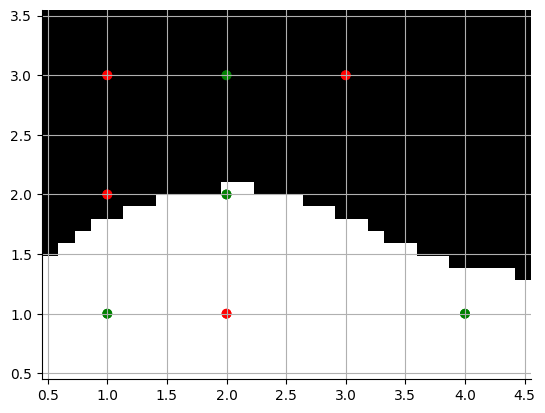

th [[ 11.  22.  19.  22.  47.  15.   4. -59.  55. -53.]] th0 [[11.]]


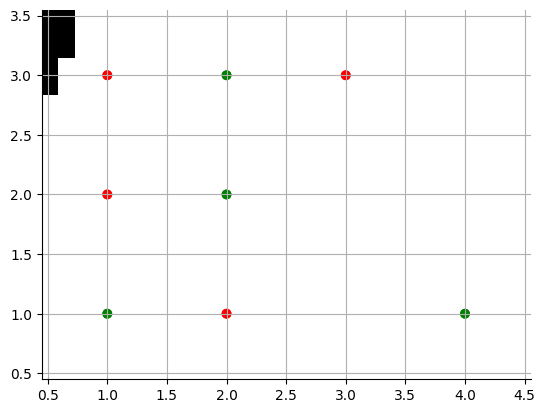

th [[ 12.  24.  22.  26.  53.  24.  12. -47.  73. -26.]] th0 [[12.]]


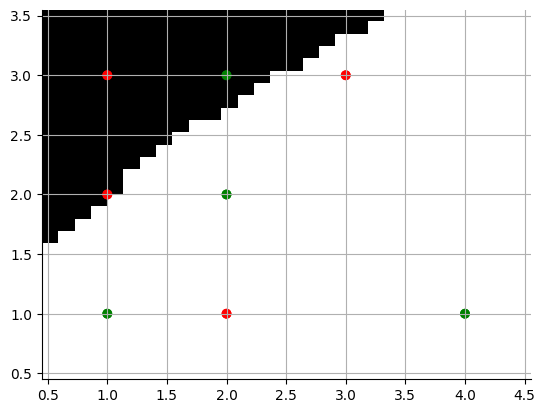

th [[ 11.  23.  19.  25.  50.  15.  11. -50.  64. -53.]] th0 [[11.]]


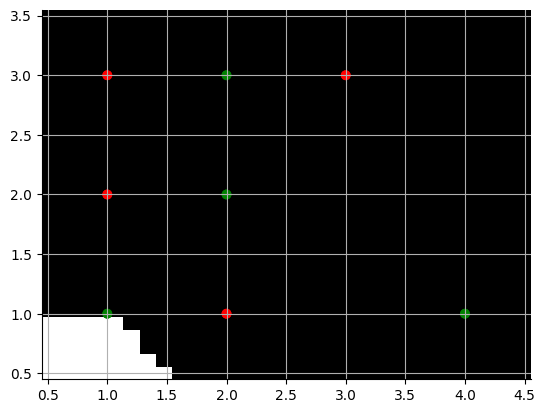

th [[ 10.  20.  16.  16.  41.   6. -16. -77.  37. -80.]] th0 [[10.]]


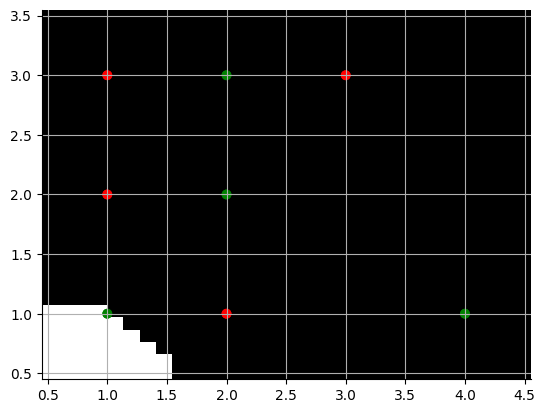

th [[ 11.  21.  17.  17.  42.   7. -15. -76.  38. -79.]] th0 [[11.]]


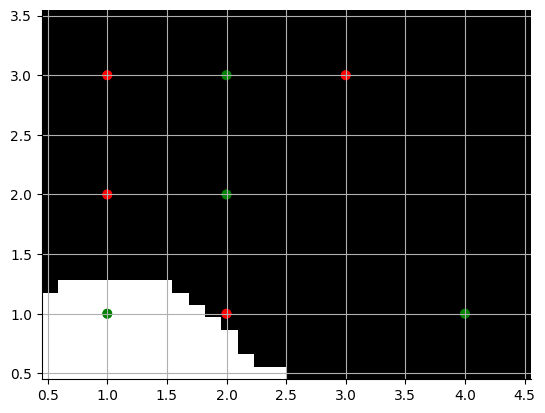

th [[ 12.  23.  19.  21.  46.  11.  -7. -68.  46. -71.]] th0 [[12.]]


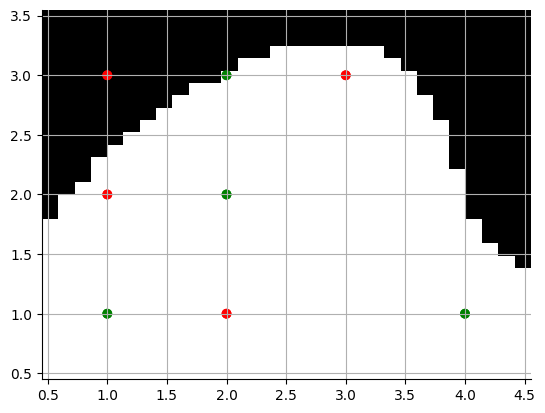

th [[ 13.  25.  22.  25.  52.  20.   1. -56.  64. -44.]] th0 [[13.]]


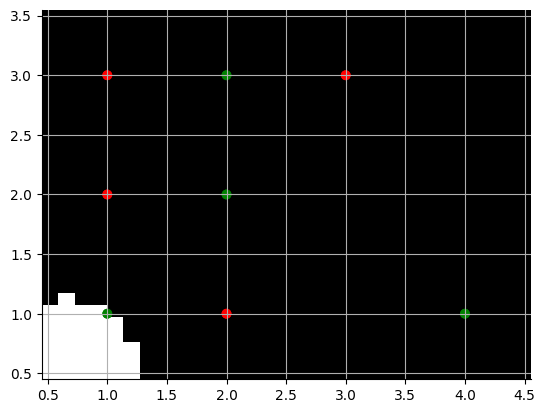

th [[ 12.  22.  19.  16.  43.  11. -26. -83.  37. -71.]] th0 [[12.]]


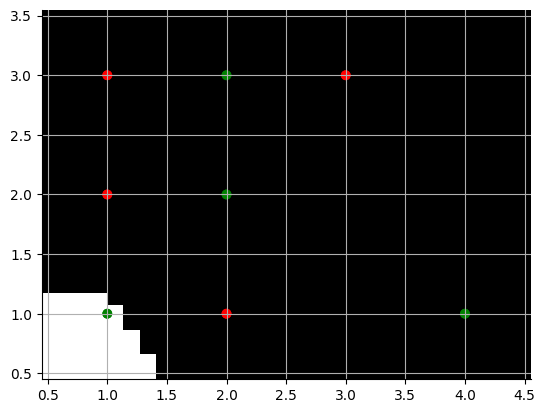

th [[ 13.  23.  20.  17.  44.  12. -25. -82.  38. -70.]] th0 [[13.]]


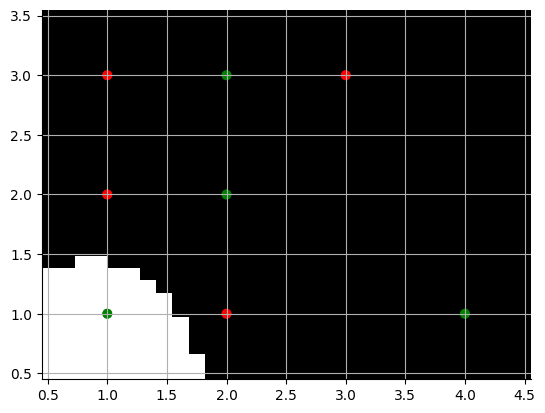

th [[ 14.  25.  22.  21.  48.  16. -17. -74.  46. -62.]] th0 [[14.]]


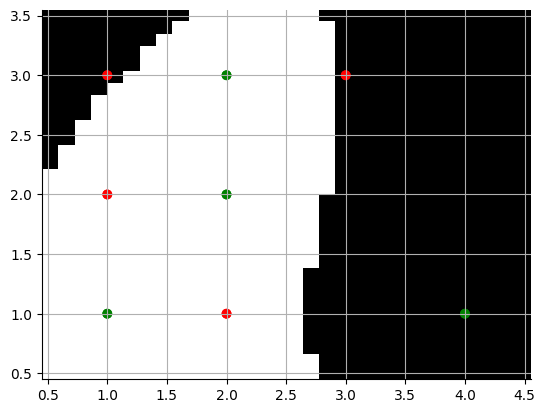

th [[ 15.  27.  25.  25.  54.  25.  -9. -62.  64. -35.]] th0 [[15.]]


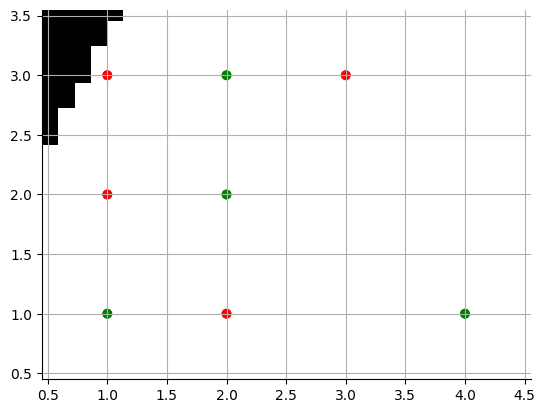

th [[ 16.  31.  26.  41.  58.  26.  55. -46.  68. -34.]] th0 [[16.]]


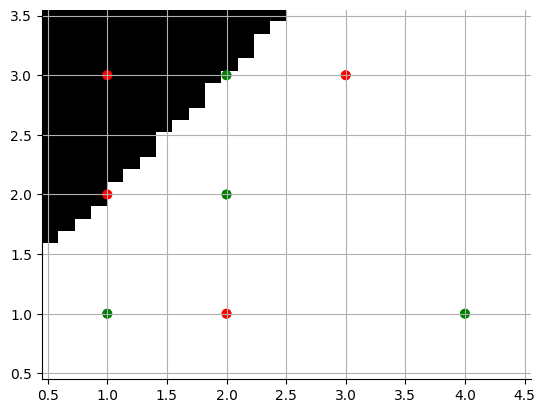

th [[ 15.  30.  23.  40.  55.  17.  54. -49.  59. -61.]] th0 [[15.]]


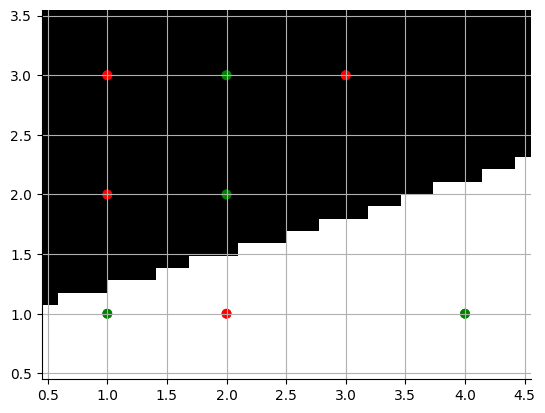

th [[ 14.  27.  20.  31.  46.   8.  27. -76.  32. -88.]] th0 [[14.]]


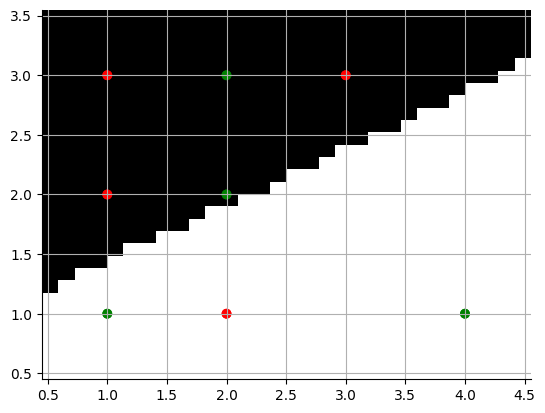

th [[ 15.  29.  22.  35.  50.  12.  35. -68.  40. -80.]] th0 [[15.]]


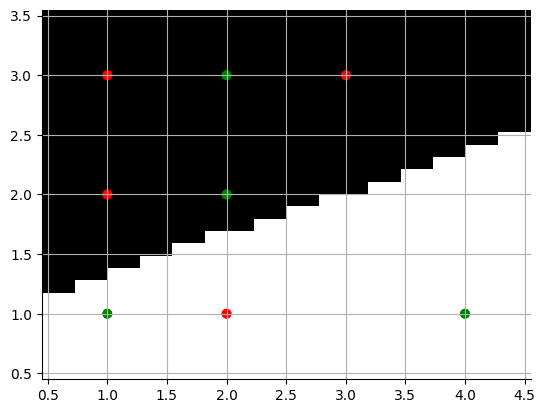

th [[ 14.  27.  21.  31.  48.  11.  27. -72.  38. -81.]] th0 [[14.]]


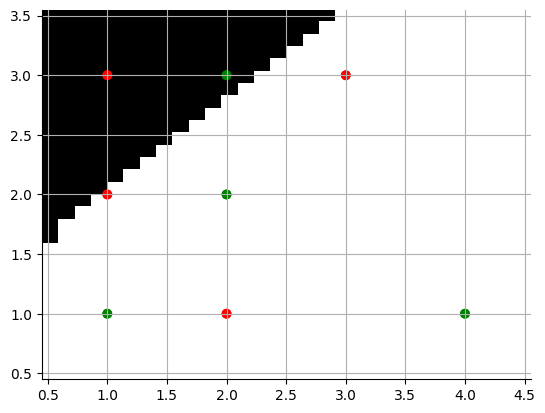

th [[ 15.  29.  24.  35.  54.  20.  35. -60.  56. -54.]] th0 [[15.]]


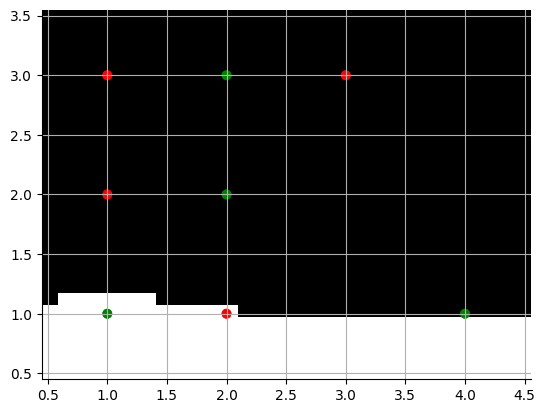

th [[ 14.  26.  21.  26.  45.  11.   8. -87.  29. -81.]] th0 [[14.]]


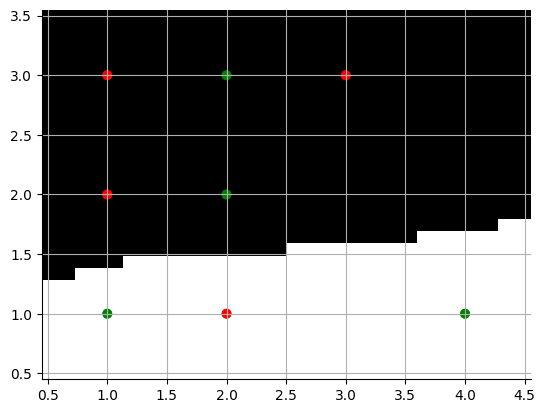

th [[ 15.  28.  23.  30.  49.  15.  16. -79.  37. -73.]] th0 [[15.]]


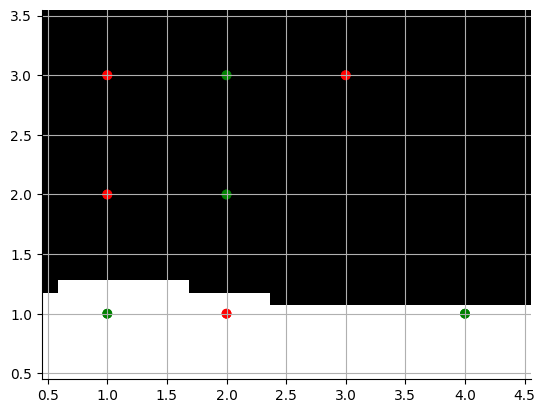

th [[ 14.  26.  22.  26.  47.  14.   8. -83.  35. -74.]] th0 [[14.]]


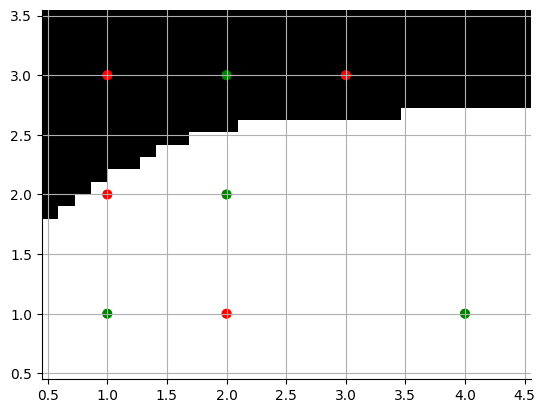

th [[ 15.  28.  25.  30.  53.  23.  16. -71.  53. -47.]] th0 [[15.]]


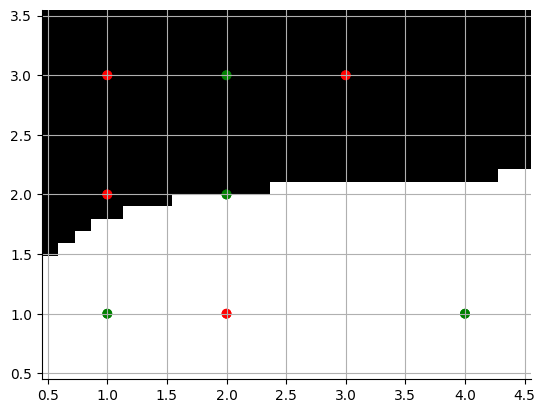

th [[ 14.  27.  23.  29.  51.  19.  15. -73.  49. -55.]] th0 [[14.]]


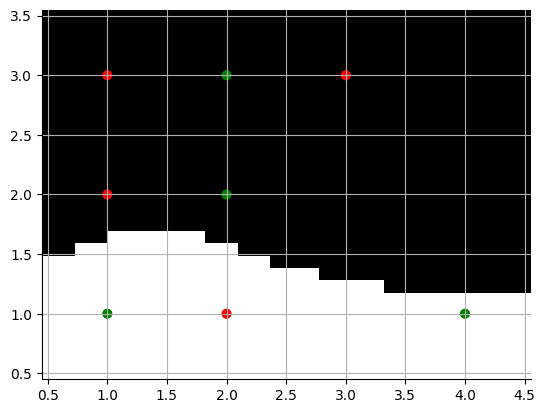

th [[ 13.  25.  22.  25.  49.  18.   7. -77.  47. -56.]] th0 [[13.]]


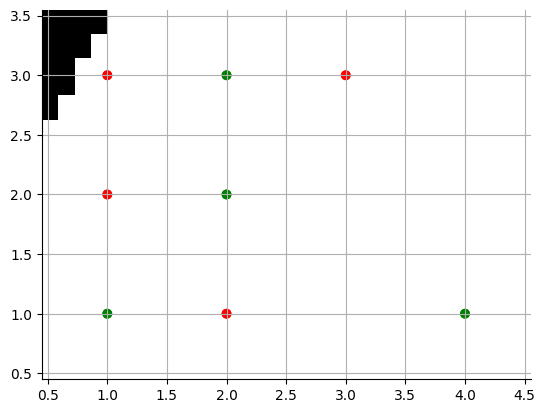

th [[ 14.  27.  25.  29.  55.  27.  15. -65.  65. -29.]] th0 [[14.]]


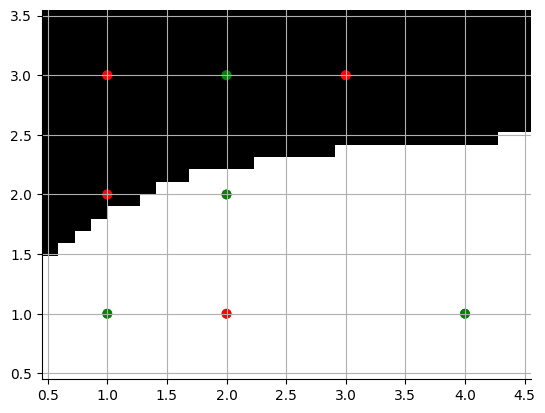

th [[ 13.  26.  22.  28.  52.  18.  14. -68.  56. -56.]] th0 [[13.]]


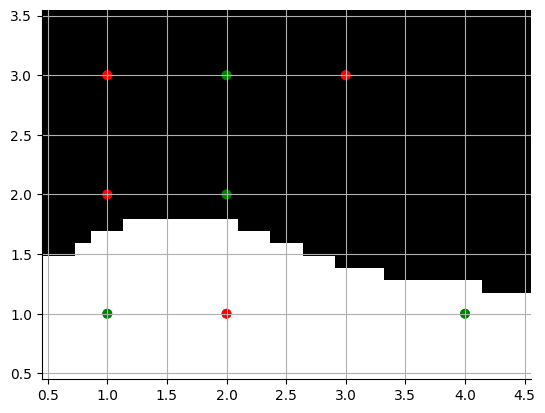

th [[ 12.  24.  21.  24.  50.  17.   6. -72.  54. -57.]] th0 [[12.]]


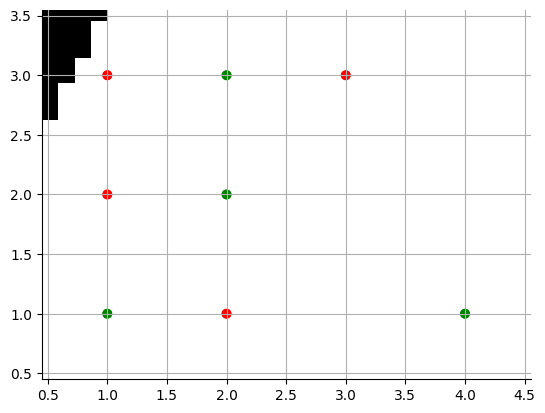

th [[ 13.  26.  24.  28.  56.  26.  14. -60.  72. -30.]] th0 [[13.]]


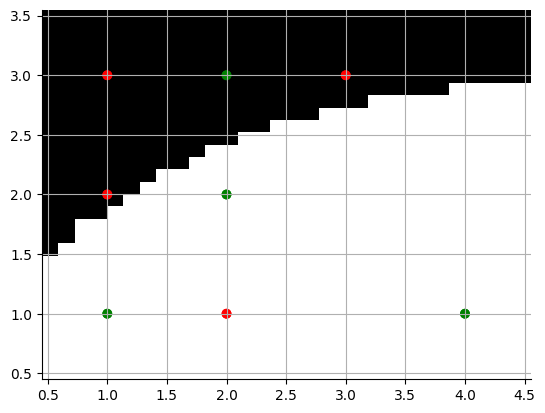

th [[ 12.  25.  21.  27.  53.  17.  13. -63.  63. -57.]] th0 [[12.]]


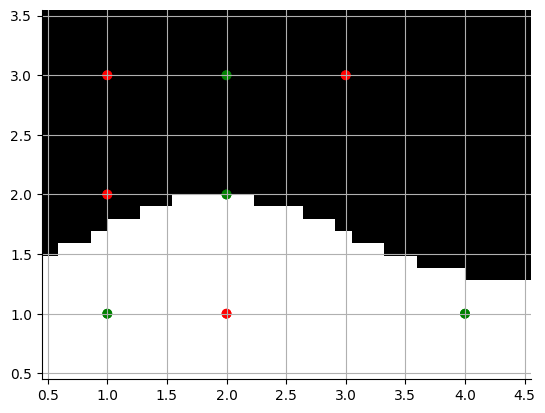

th [[ 11.  23.  20.  23.  51.  16.   5. -67.  61. -58.]] th0 [[11.]]


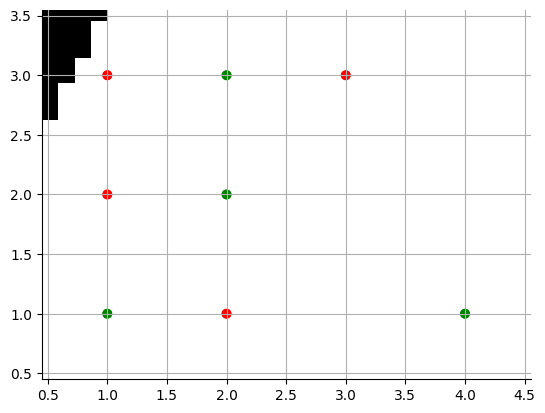

th [[ 12.  25.  23.  27.  57.  25.  13. -55.  79. -31.]] th0 [[12.]]


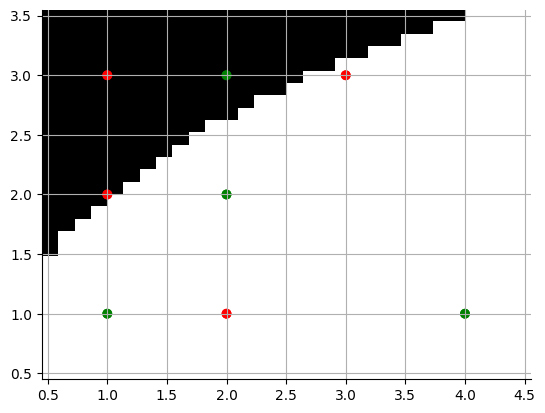

th [[ 11.  24.  20.  26.  54.  16.  12. -58.  70. -58.]] th0 [[11.]]


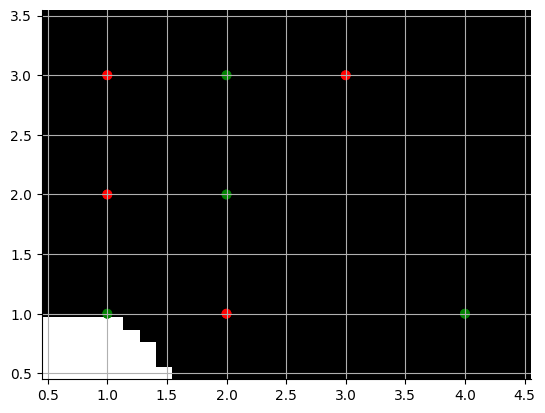

th [[ 10.  21.  17.  17.  45.   7. -15. -85.  43. -85.]] th0 [[10.]]


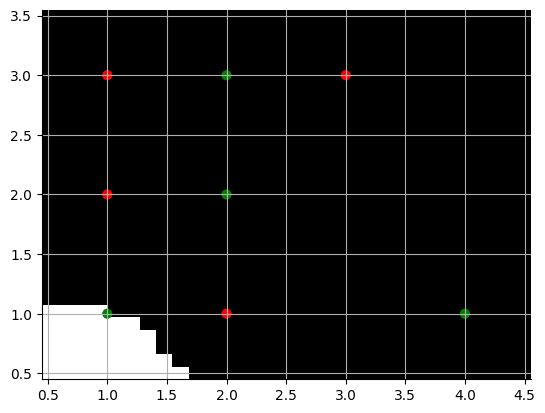

th [[ 11.  22.  18.  18.  46.   8. -14. -84.  44. -84.]] th0 [[11.]]


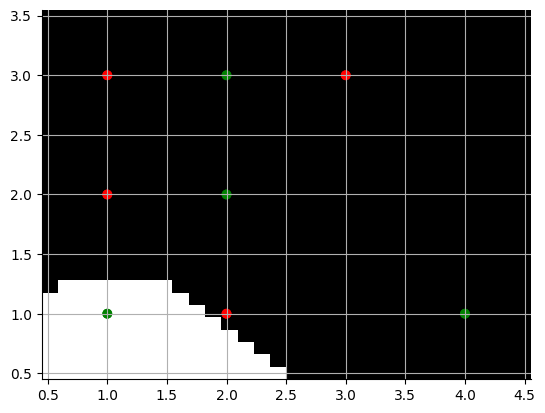

th [[ 12.  24.  20.  22.  50.  12.  -6. -76.  52. -76.]] th0 [[12.]]


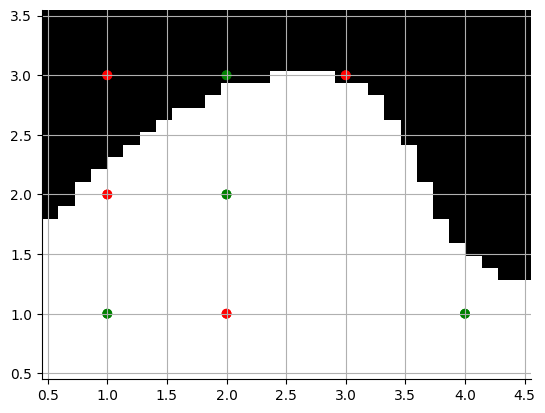

th [[ 13.  26.  23.  26.  56.  21.   2. -64.  70. -49.]] th0 [[13.]]


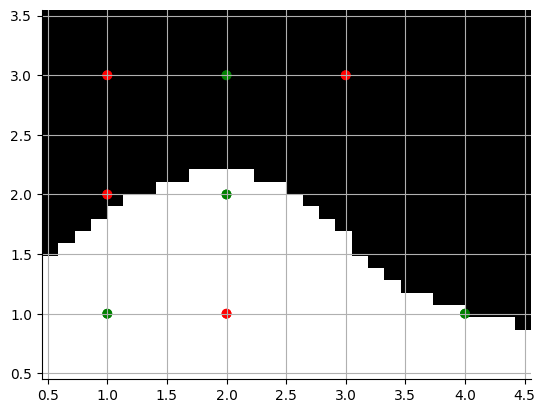

th [[ 12.  25.  21.  25.  54.  17.   1. -66.  66. -57.]] th0 [[12.]]


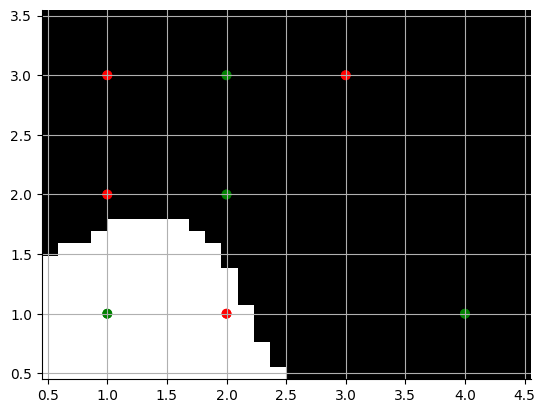

th [[ 11.  23.  20.  21.  52.  16.  -7. -70.  64. -58.]] th0 [[11.]]


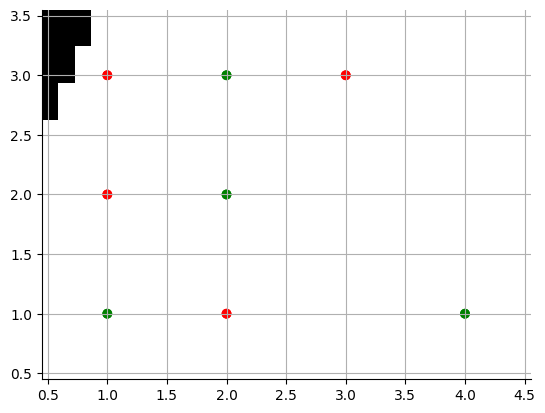

th [[ 12.  25.  23.  25.  58.  25.   1. -58.  82. -31.]] th0 [[12.]]


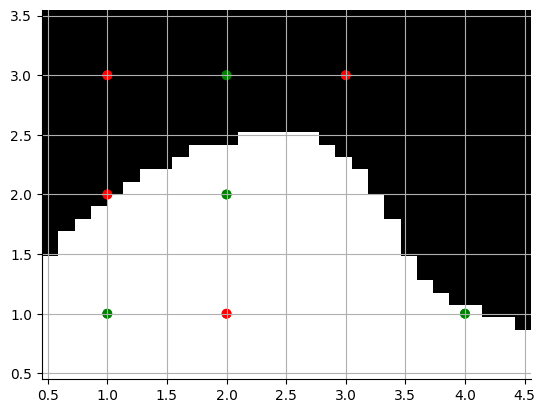

th [[ 11.  24.  20.  24.  55.  16.   0. -61.  73. -58.]] th0 [[11.]]


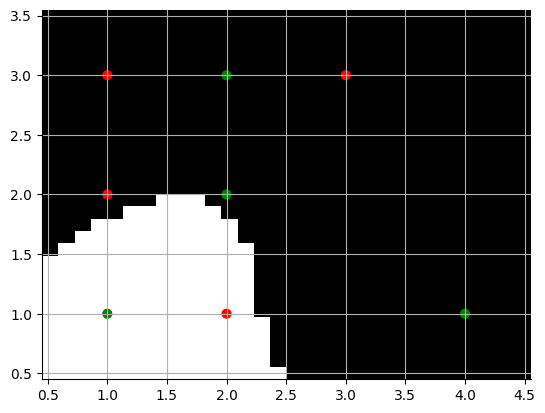

th [[ 10.  22.  19.  20.  53.  15.  -8. -65.  71. -59.]] th0 [[10.]]


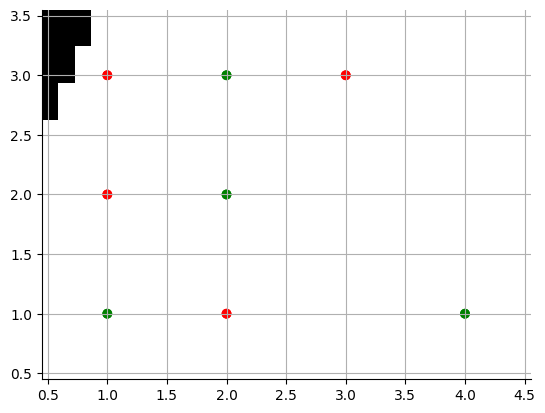

th [[ 11.  24.  22.  24.  59.  24.   0. -53.  89. -32.]] th0 [[11.]]


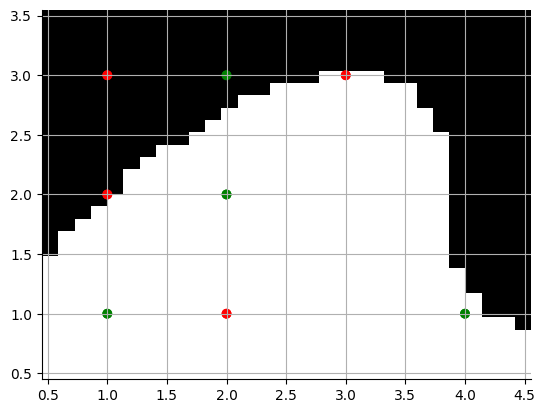

th [[ 10.  23.  19.  23.  56.  15.  -1. -56.  80. -59.]] th0 [[10.]]


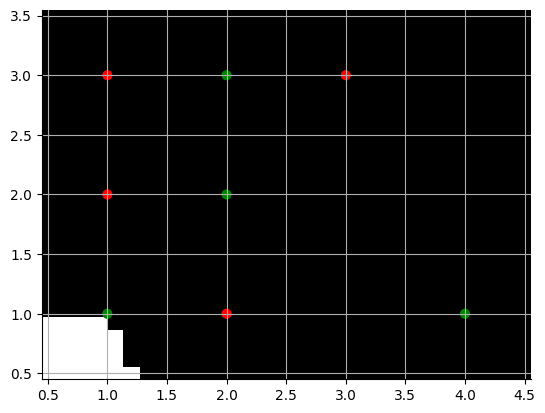

th [[  9.  20.  16.  14.  47.   6. -28. -83.  53. -86.]] th0 [[9.]]


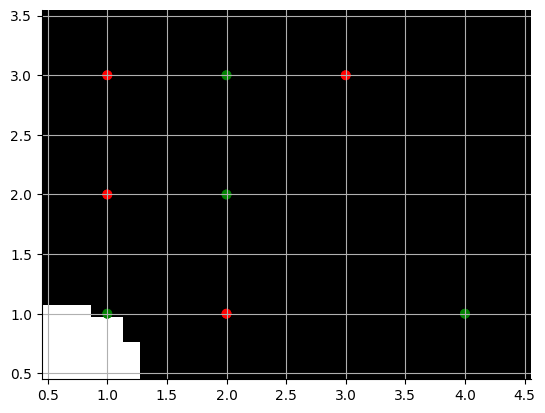

th [[ 10.  21.  17.  15.  48.   7. -27. -82.  54. -85.]] th0 [[10.]]


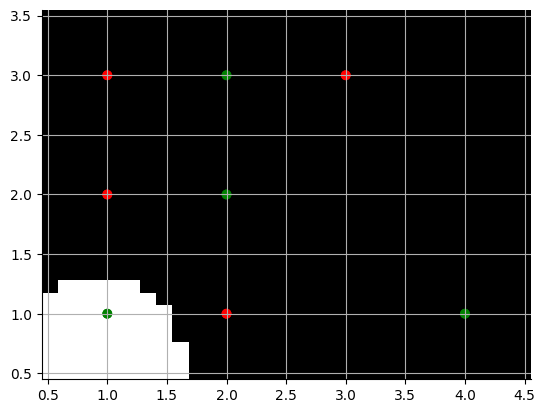

th [[ 11.  23.  19.  19.  52.  11. -19. -74.  62. -77.]] th0 [[11.]]


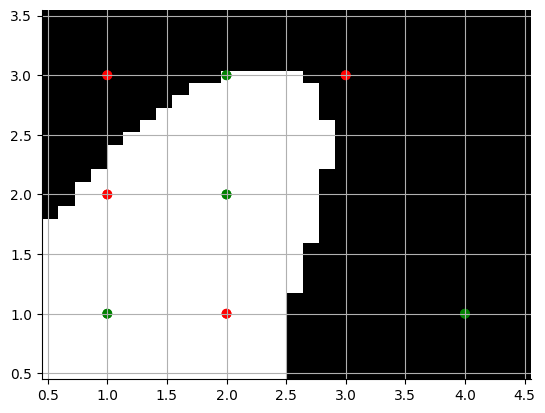

th [[ 12.  25.  22.  23.  58.  20. -11. -62.  80. -50.]] th0 [[12.]]


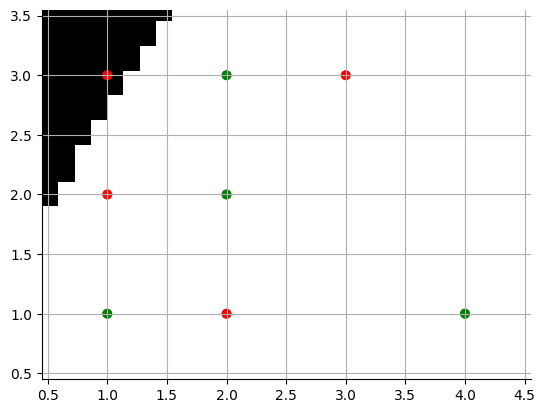

th [[ 13.  29.  23.  39.  62.  21.  53. -46.  84. -49.]] th0 [[13.]]


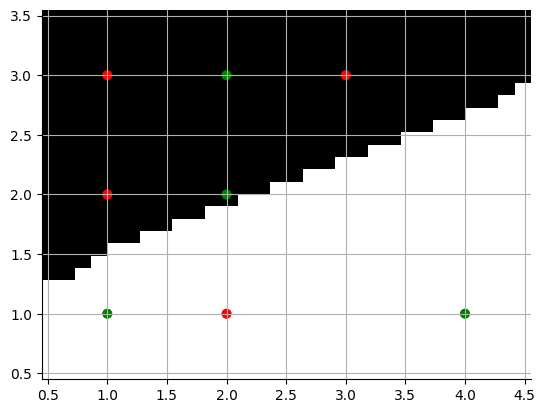

th [[ 12.  26.  20.  30.  53.  12.  26. -73.  57. -76.]] th0 [[12.]]


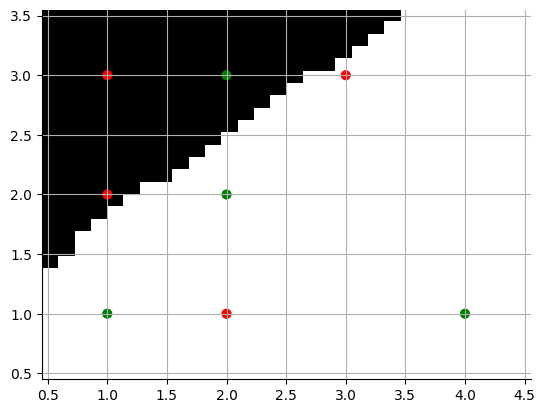

th [[ 13.  28.  22.  34.  57.  16.  34. -65.  65. -68.]] th0 [[13.]]


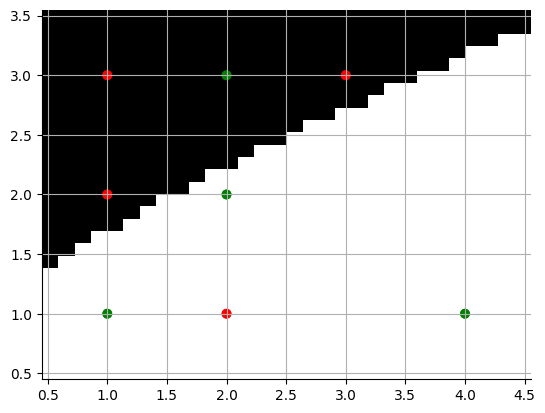

th [[ 12.  26.  21.  30.  55.  15.  26. -69.  63. -69.]] th0 [[12.]]


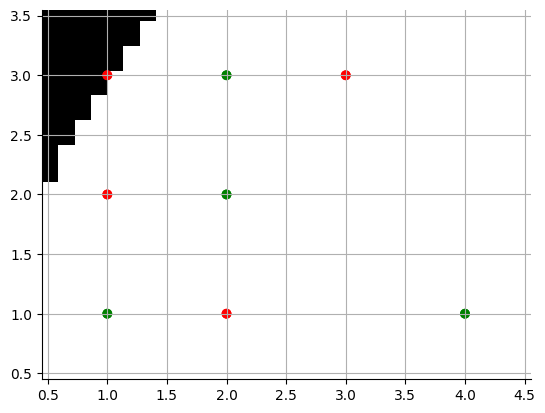

th [[ 13.  28.  24.  34.  61.  24.  34. -57.  81. -42.]] th0 [[13.]]


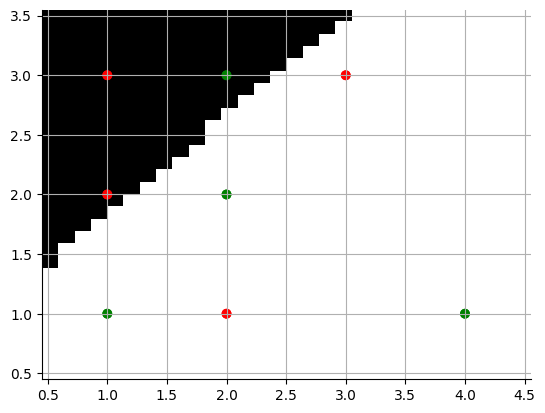

th [[ 12.  27.  21.  33.  58.  15.  33. -60.  72. -69.]] th0 [[12.]]


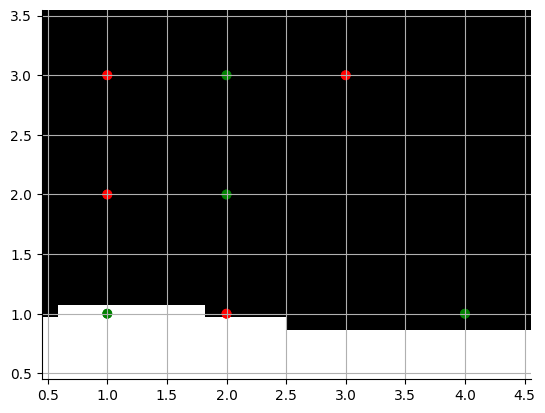

th [[ 11.  24.  18.  24.  49.   6.   6. -87.  45. -96.]] th0 [[11.]]


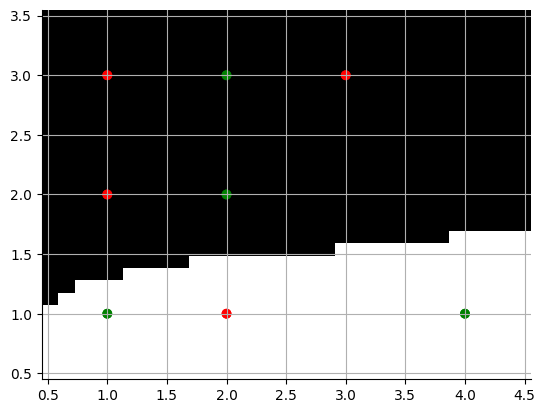

th [[ 12.  26.  20.  28.  53.  10.  14. -79.  53. -88.]] th0 [[12.]]


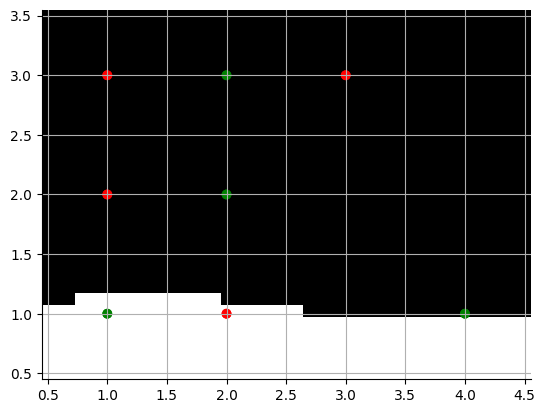

th [[ 11.  24.  19.  24.  51.   9.   6. -83.  51. -89.]] th0 [[11.]]


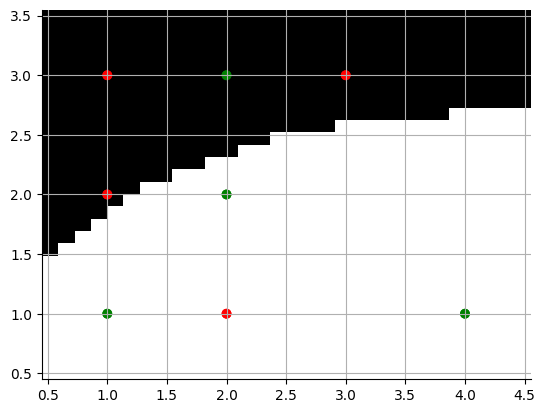

th [[ 12.  26.  22.  28.  57.  18.  14. -71.  69. -62.]] th0 [[12.]]


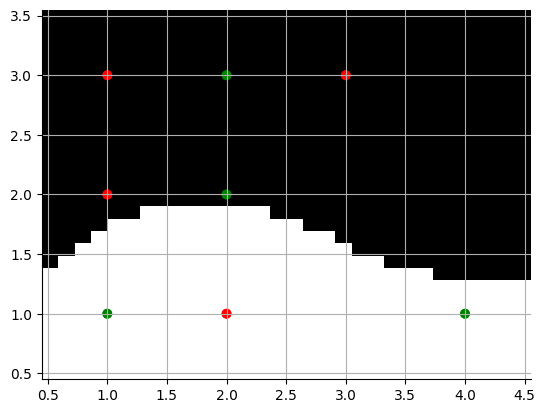

th [[ 11.  24.  21.  24.  55.  17.   6. -75.  67. -63.]] th0 [[11.]]


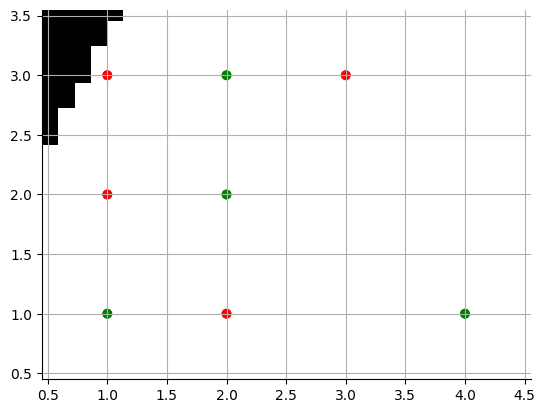

th [[ 12.  26.  24.  28.  61.  26.  14. -63.  85. -36.]] th0 [[12.]]


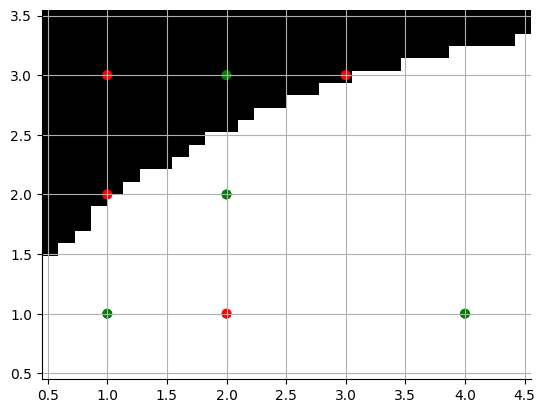

th [[ 11.  25.  21.  27.  58.  17.  13. -66.  76. -63.]] th0 [[11.]]


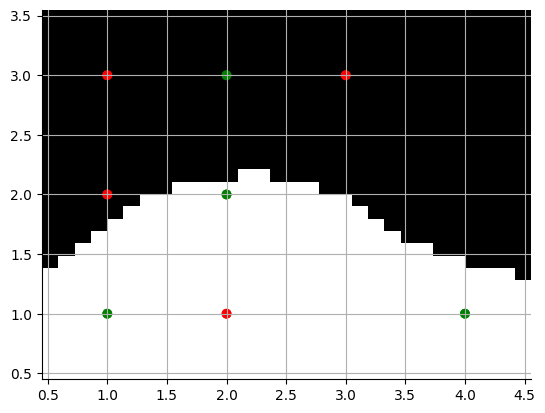

th [[ 10.  23.  20.  23.  56.  16.   5. -70.  74. -64.]] th0 [[10.]]


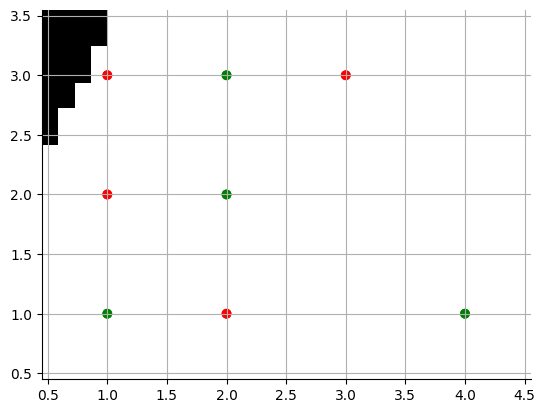

th [[ 11.  25.  23.  27.  62.  25.  13. -58.  92. -37.]] th0 [[11.]]


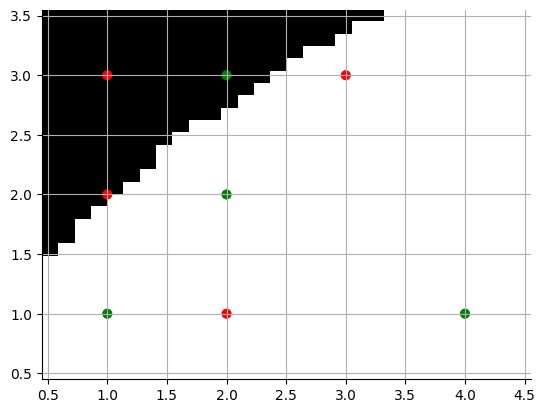

th [[ 10.  24.  20.  26.  59.  16.  12. -61.  83. -64.]] th0 [[10.]]


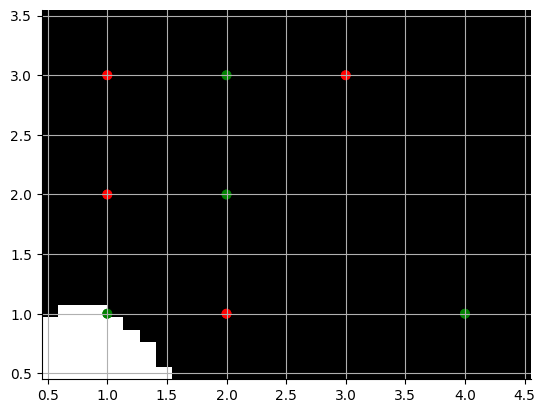

th [[  9.  21.  17.  17.  50.   7. -15. -88.  56. -91.]] th0 [[9.]]


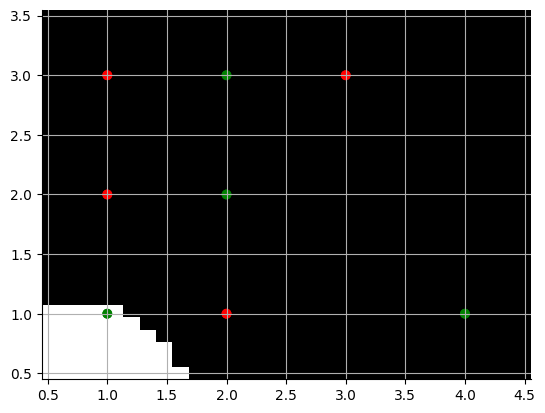

th [[ 10.  22.  18.  18.  51.   8. -14. -87.  57. -90.]] th0 [[10.]]


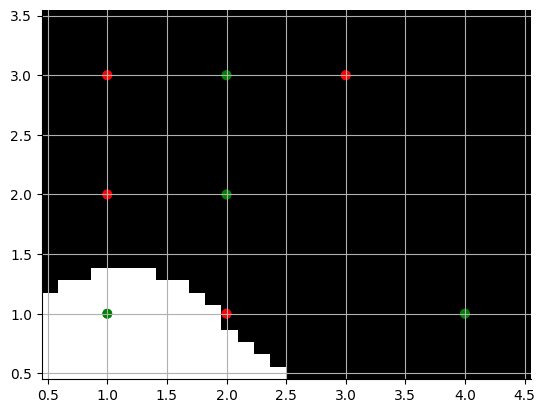

th [[ 11.  24.  20.  22.  55.  12.  -6. -79.  65. -82.]] th0 [[11.]]


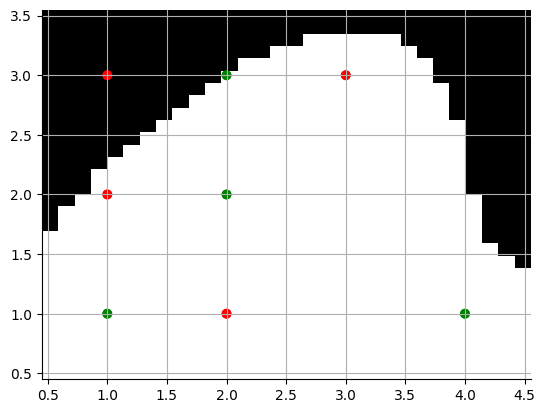

th [[ 12.  26.  23.  26.  61.  21.   2. -67.  83. -55.]] th0 [[12.]]


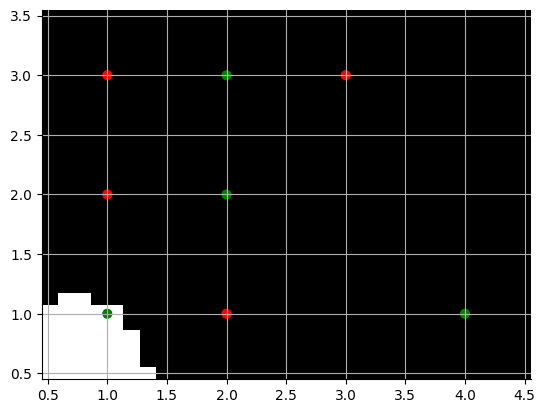

th [[ 11.  23.  20.  17.  52.  12. -25. -94.  56. -82.]] th0 [[11.]]


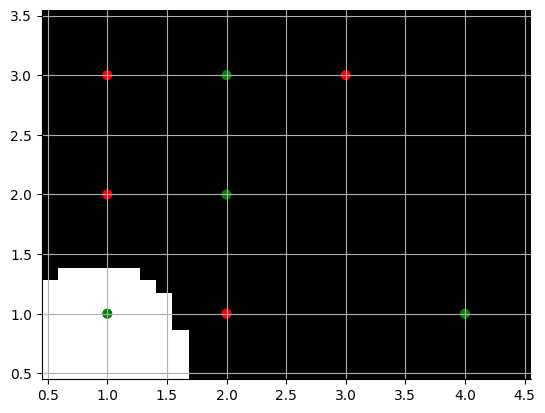

th [[ 12.  25.  22.  21.  56.  16. -17. -86.  64. -74.]] th0 [[12.]]


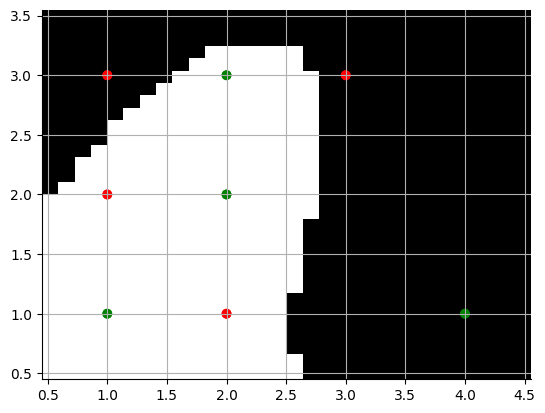

th [[ 13.  27.  25.  25.  62.  25.  -9. -74.  82. -47.]] th0 [[13.]]


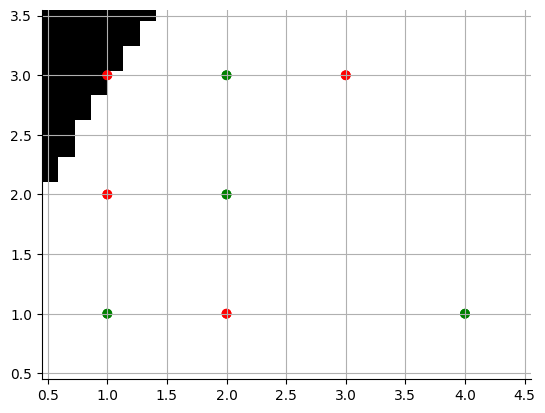

th [[ 14.  31.  26.  41.  66.  26.  55. -58.  86. -46.]] th0 [[14.]]


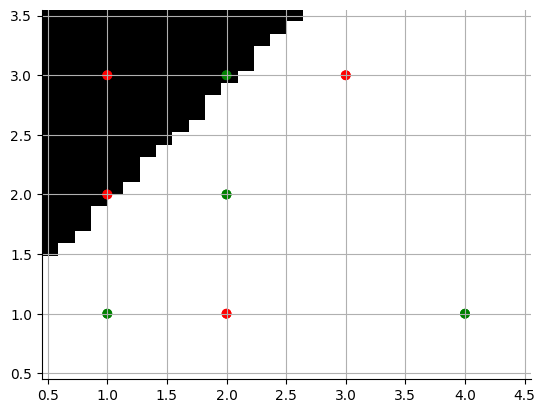

th [[ 13.  30.  23.  40.  63.  17.  54. -61.  77. -73.]] th0 [[13.]]


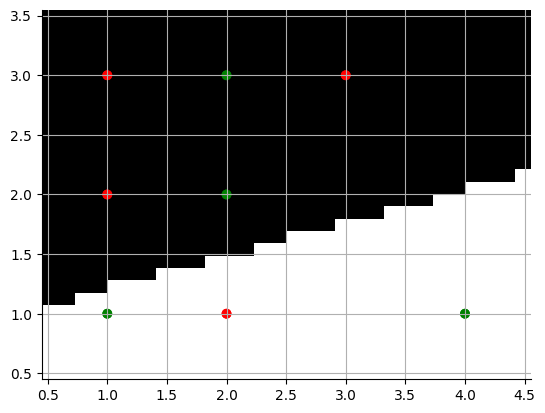

th [[  12.   27.   20.   31.   54.    8.   27.  -88.   50. -100.]] th0 [[12.]]


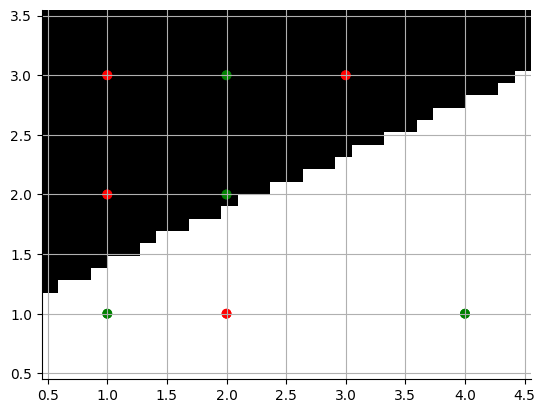

th [[ 13.  29.  22.  35.  58.  12.  35. -80.  58. -92.]] th0 [[13.]]


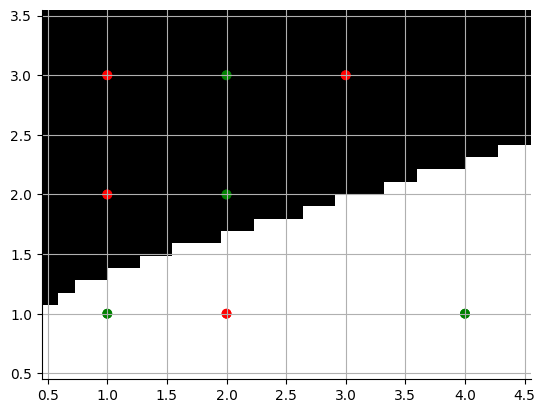

th [[ 12.  27.  21.  31.  56.  11.  27. -84.  56. -93.]] th0 [[12.]]


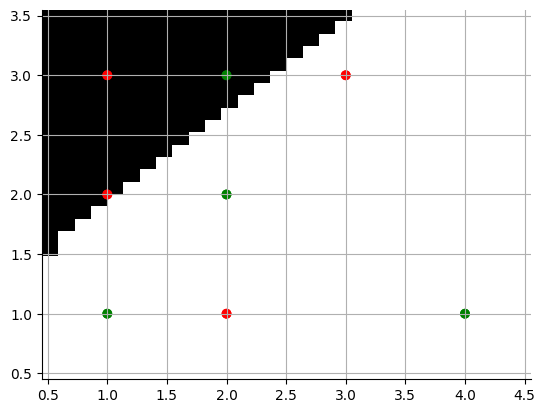

th [[ 13.  29.  24.  35.  62.  20.  35. -72.  74. -66.]] th0 [[13.]]


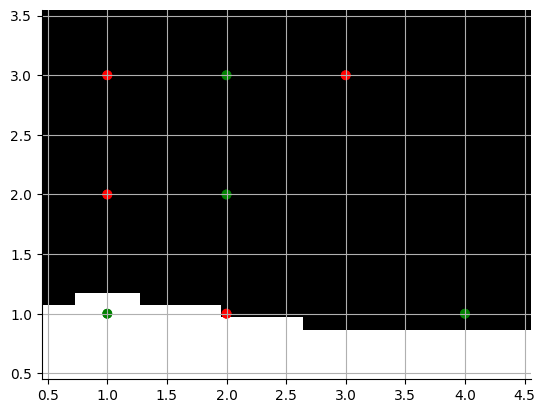

th [[ 12.  26.  21.  26.  53.  11.   8. -99.  47. -93.]] th0 [[12.]]


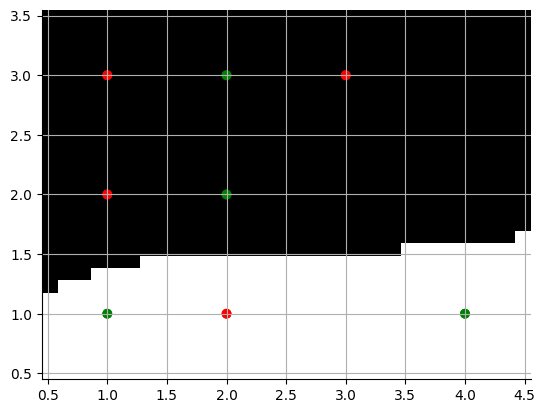

th [[ 13.  28.  23.  30.  57.  15.  16. -91.  55. -85.]] th0 [[13.]]


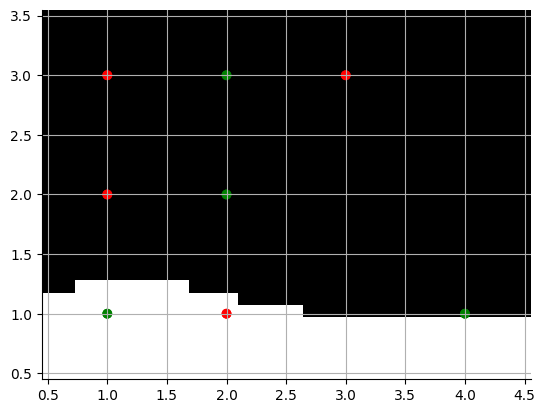

th [[ 12.  26.  22.  26.  55.  14.   8. -95.  53. -86.]] th0 [[12.]]


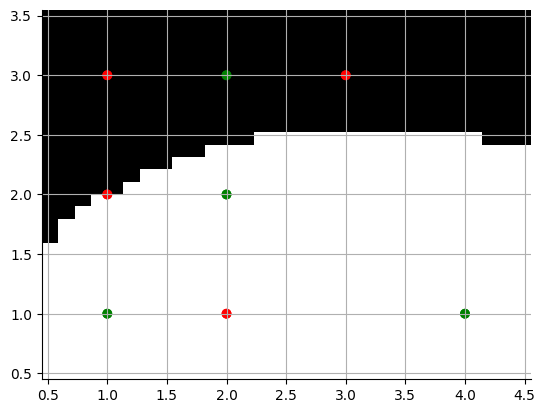

th [[ 13.  28.  25.  30.  61.  23.  16. -83.  71. -59.]] th0 [[13.]]


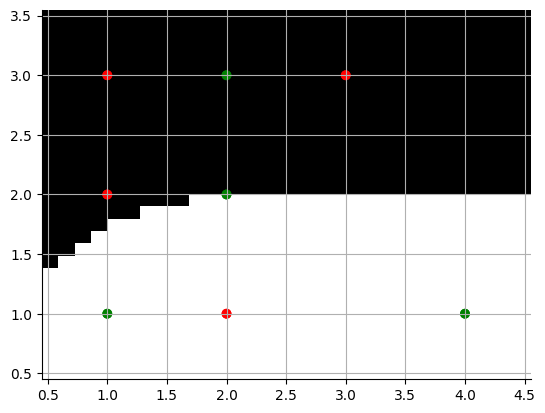

th [[ 12.  27.  23.  29.  59.  19.  15. -85.  67. -67.]] th0 [[12.]]


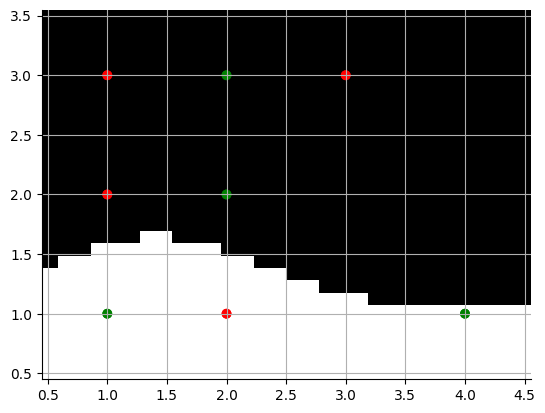

th [[ 11.  25.  22.  25.  57.  18.   7. -89.  65. -68.]] th0 [[11.]]


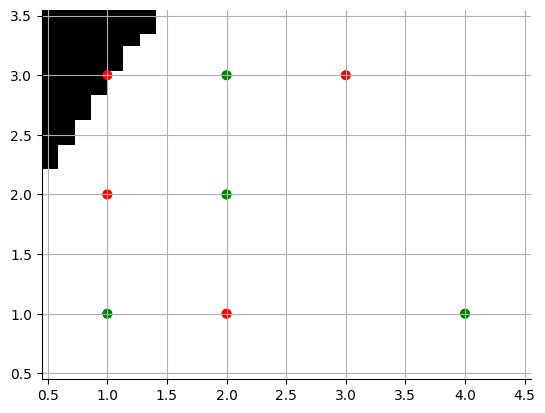

th [[ 12.  27.  25.  29.  63.  27.  15. -77.  83. -41.]] th0 [[12.]]


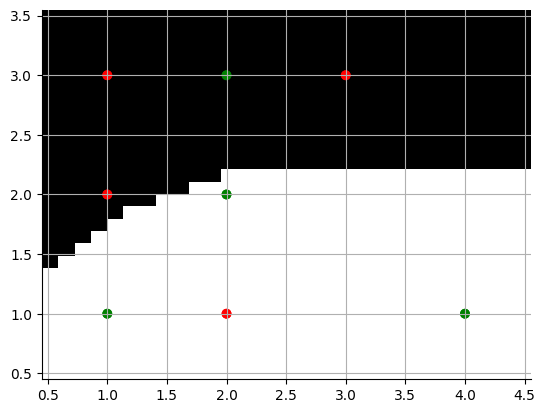

th [[ 11.  26.  22.  28.  60.  18.  14. -80.  74. -68.]] th0 [[11.]]


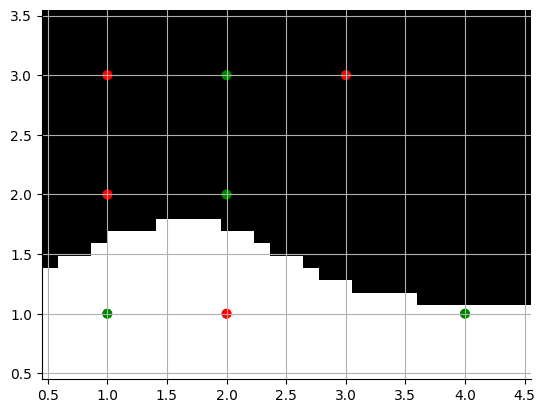

th [[ 10.  24.  21.  24.  58.  17.   6. -84.  72. -69.]] th0 [[10.]]


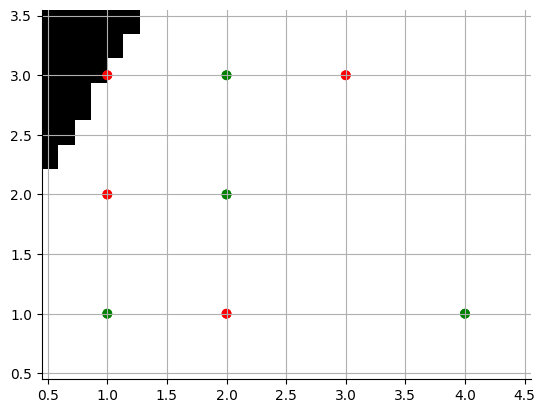

th [[ 11.  26.  24.  28.  64.  26.  14. -72.  90. -42.]] th0 [[11.]]


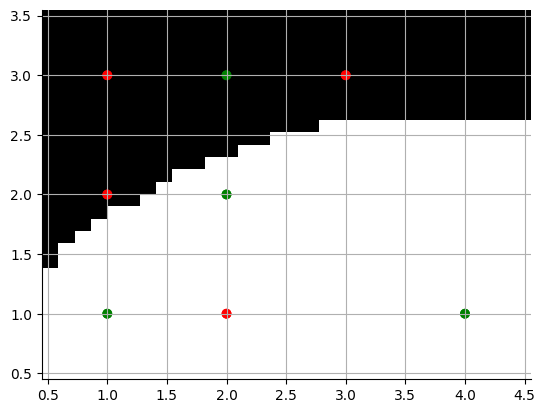

th [[ 10.  25.  21.  27.  61.  17.  13. -75.  81. -69.]] th0 [[10.]]


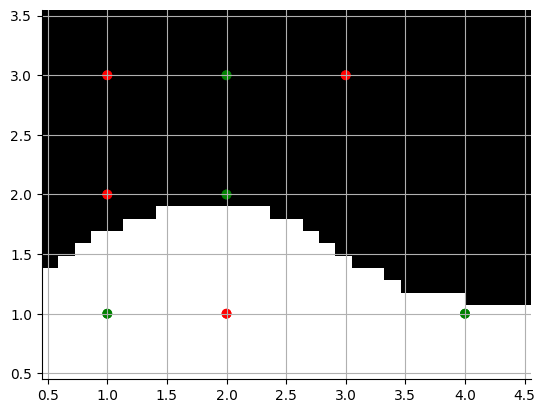

th [[  9.  23.  20.  23.  59.  16.   5. -79.  79. -70.]] th0 [[9.]]


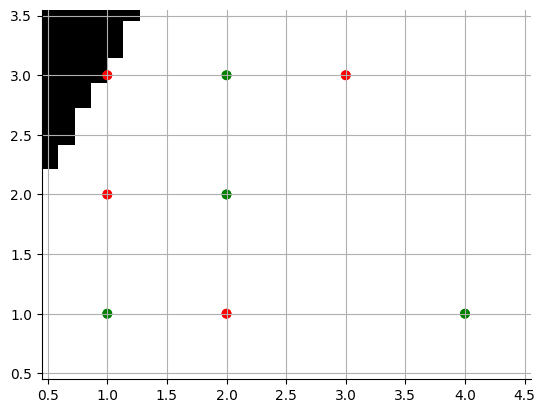

th [[ 10.  25.  23.  27.  65.  25.  13. -67.  97. -43.]] th0 [[10.]]


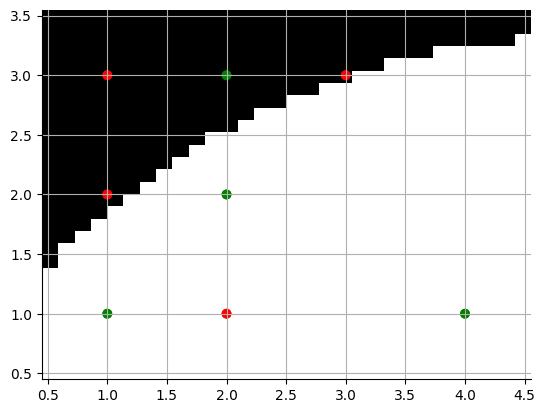

th [[  9.  24.  20.  26.  62.  16.  12. -70.  88. -70.]] th0 [[9.]]


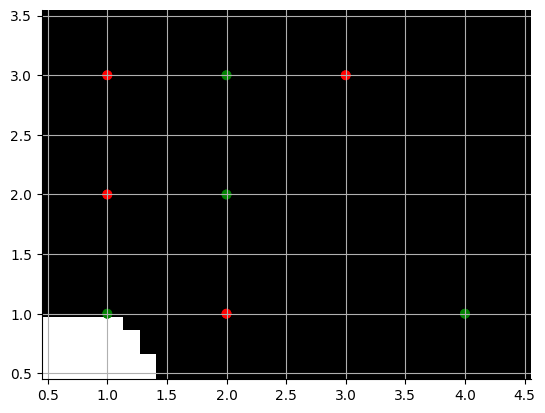

th [[  8.  21.  17.  17.  53.   7. -15. -97.  61. -97.]] th0 [[8.]]


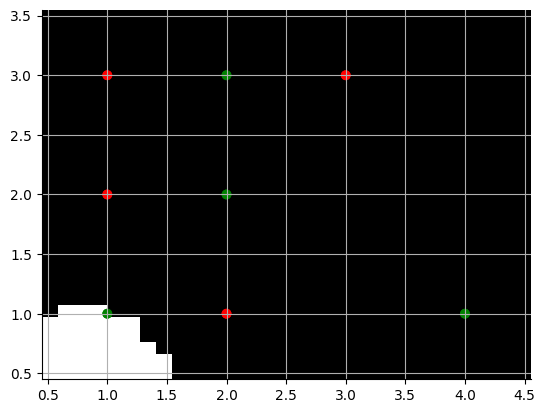

th [[  9.  22.  18.  18.  54.   8. -14. -96.  62. -96.]] th0 [[9.]]


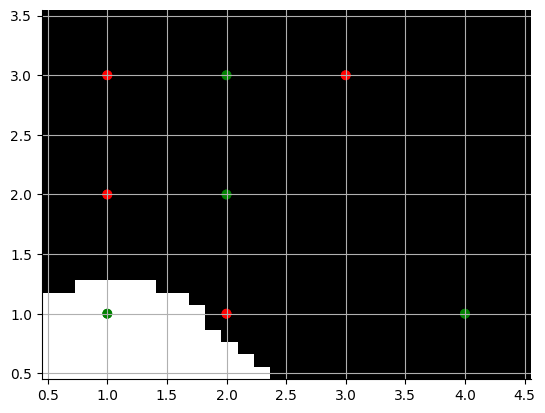

th [[ 10.  24.  20.  22.  58.  12.  -6. -88.  70. -88.]] th0 [[10.]]


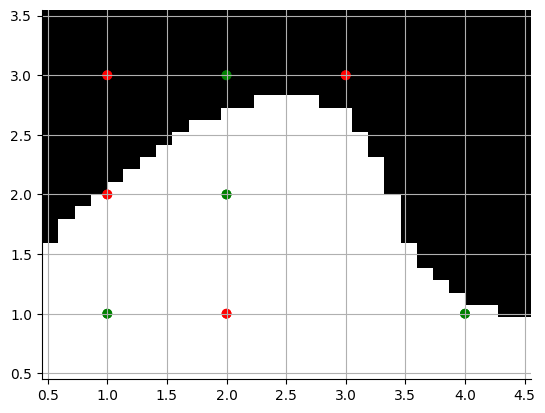

th [[ 11.  26.  23.  26.  64.  21.   2. -76.  88. -61.]] th0 [[11.]]


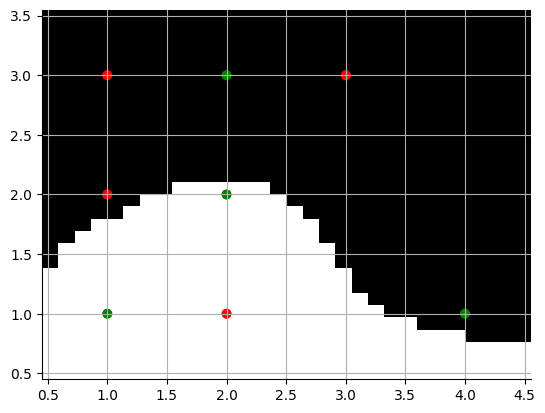

th [[ 10.  25.  21.  25.  62.  17.   1. -78.  84. -69.]] th0 [[10.]]


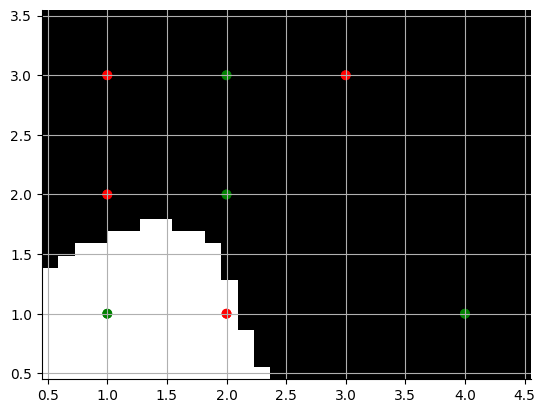

th [[  9.  23.  20.  21.  60.  16.  -7. -82.  82. -70.]] th0 [[9.]]


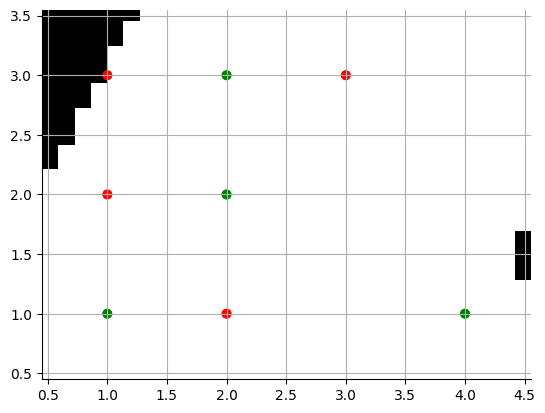

th [[ 10.  25.  23.  25.  66.  25.   1. -70. 100. -43.]] th0 [[10.]]


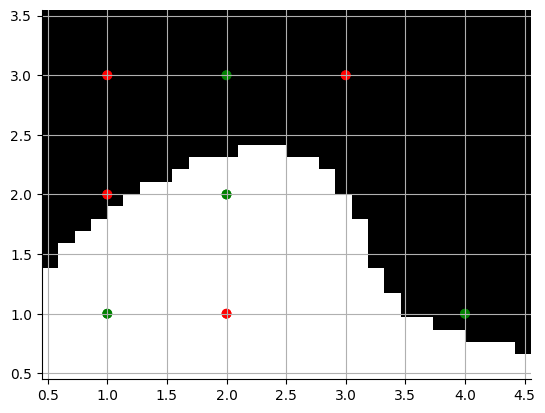

th [[  9.  24.  20.  24.  63.  16.   0. -73.  91. -70.]] th0 [[9.]]


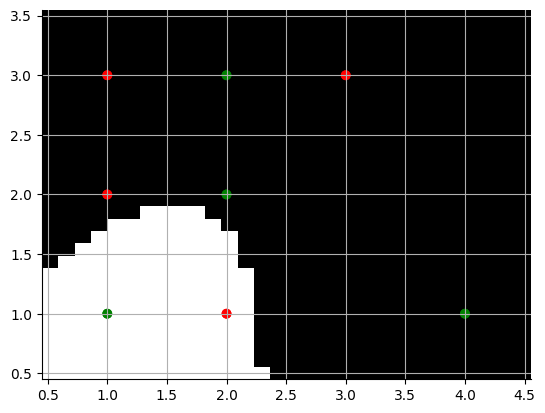

th [[  8.  22.  19.  20.  61.  15.  -8. -77.  89. -71.]] th0 [[8.]]


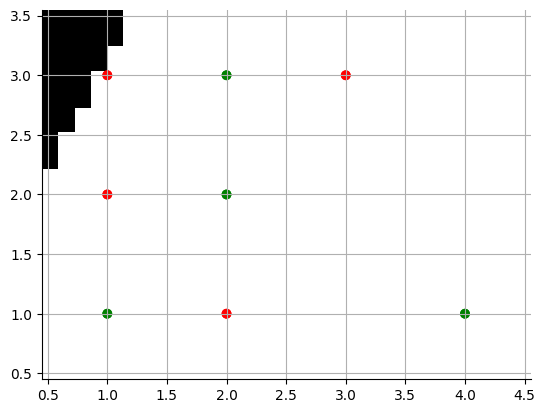

th [[  9.  24.  22.  24.  67.  24.   0. -65. 107. -44.]] th0 [[9.]]


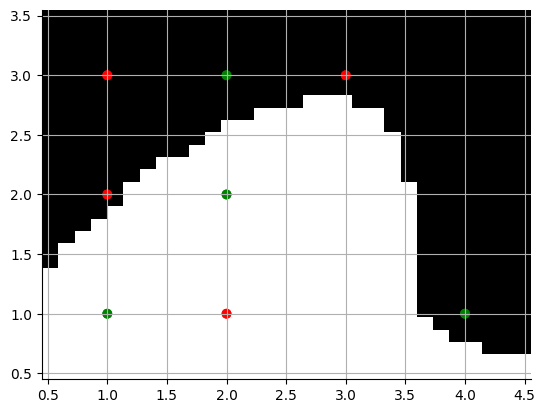

th [[  8.  23.  19.  23.  64.  15.  -1. -68.  98. -71.]] th0 [[8.]]


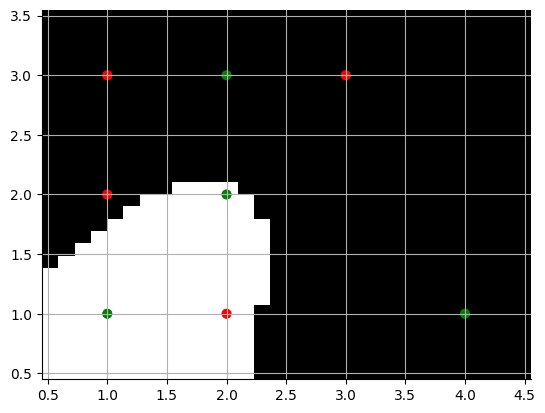

th [[  7.  21.  18.  19.  62.  14.  -9. -72.  96. -72.]] th0 [[7.]]


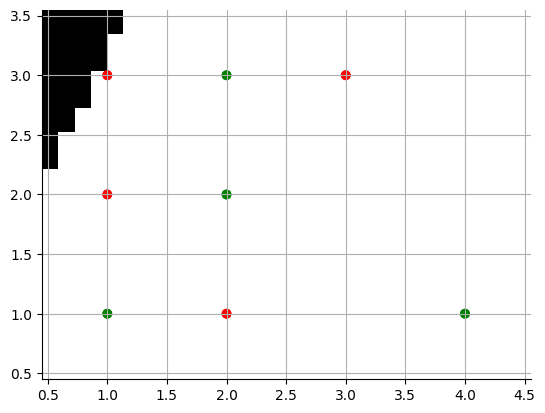

th [[  8.  23.  21.  23.  68.  23.  -1. -60. 114. -45.]] th0 [[8.]]


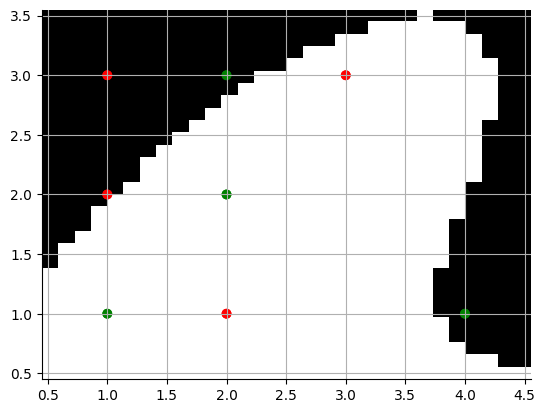

th [[  7.  22.  18.  22.  65.  14.  -2. -63. 105. -72.]] th0 [[7.]]


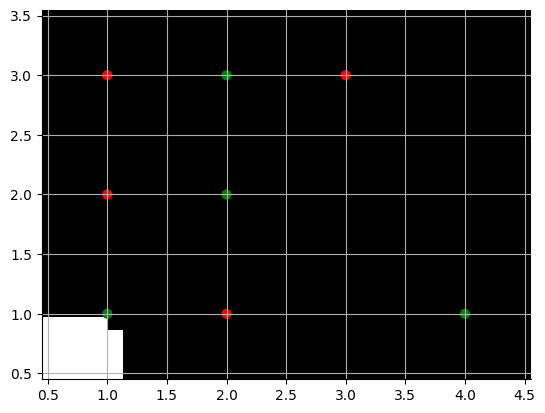

th [[  6.  19.  15.  13.  56.   5. -29. -90.  78. -99.]] th0 [[6.]]


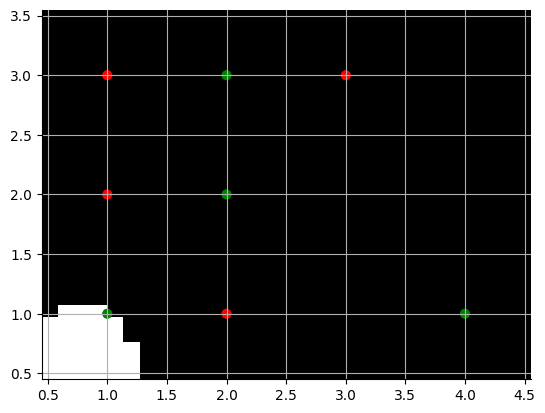

th [[  7.  20.  16.  14.  57.   6. -28. -89.  79. -98.]] th0 [[7.]]


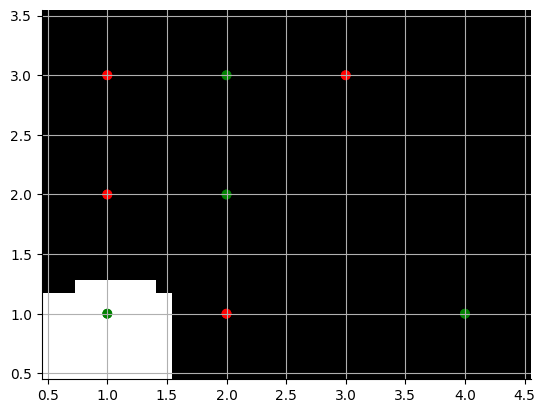

th [[  8.  22.  18.  18.  61.  10. -20. -81.  87. -90.]] th0 [[8.]]


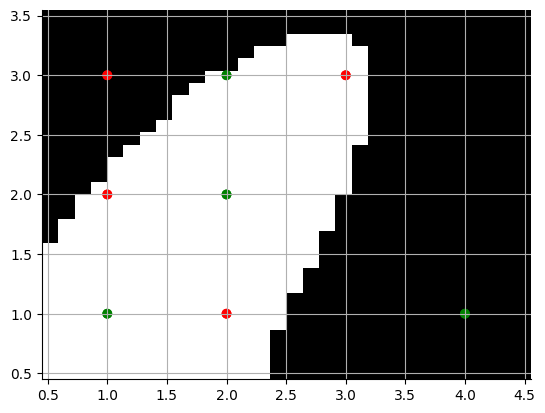

th [[  9.  24.  21.  22.  67.  19. -12. -69. 105. -63.]] th0 [[9.]]


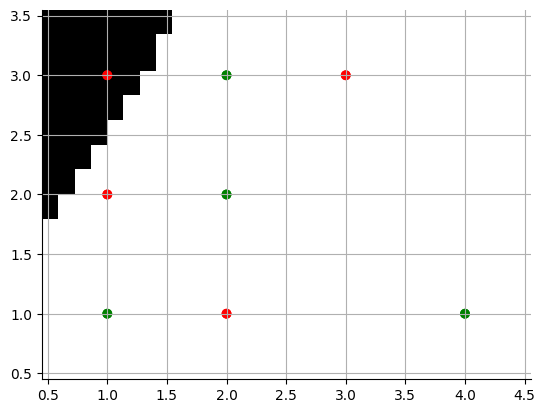

th [[ 10.  28.  22.  38.  71.  20.  52. -53. 109. -62.]] th0 [[10.]]


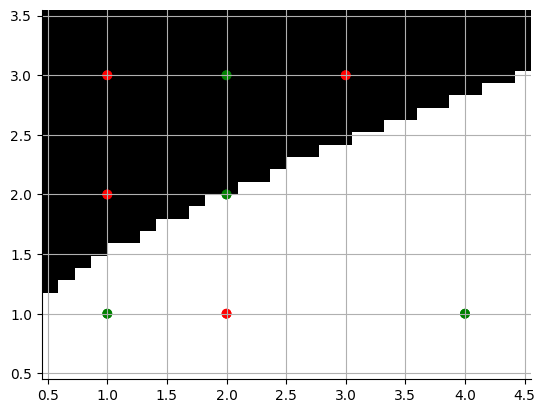

th [[  9.  25.  19.  29.  62.  11.  25. -80.  82. -89.]] th0 [[9.]]


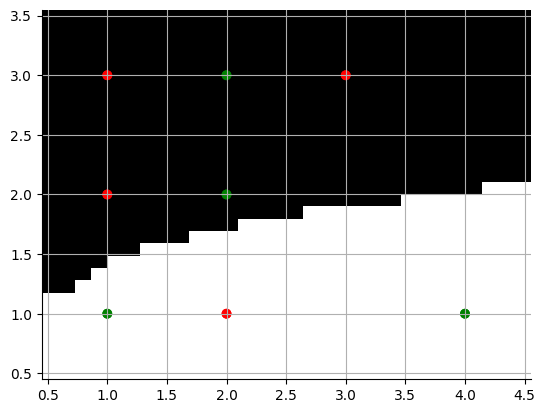

th [[  8.  23.  18.  25.  60.  10.  17. -84.  80. -90.]] th0 [[8.]]


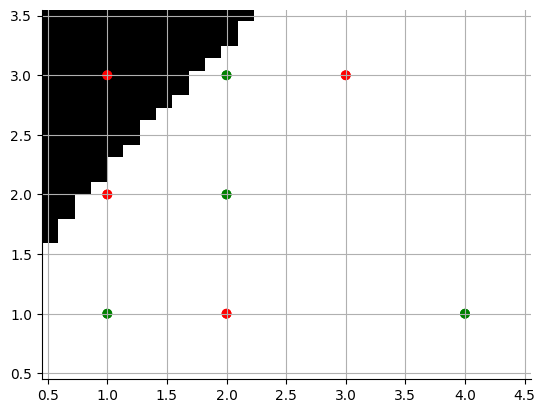

th [[  9.  25.  21.  29.  66.  19.  25. -72.  98. -63.]] th0 [[9.]]


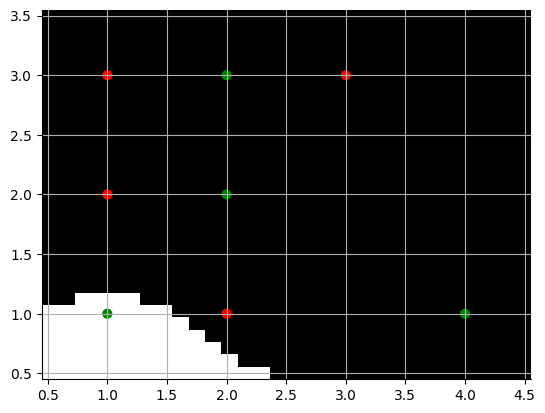

th [[  8.  22.  18.  20.  57.  10.  -2. -99.  71. -90.]] th0 [[8.]]


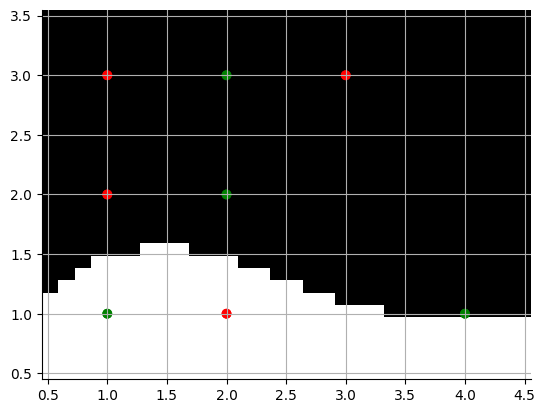

th [[  9.  24.  20.  24.  61.  14.   6. -91.  79. -82.]] th0 [[9.]]


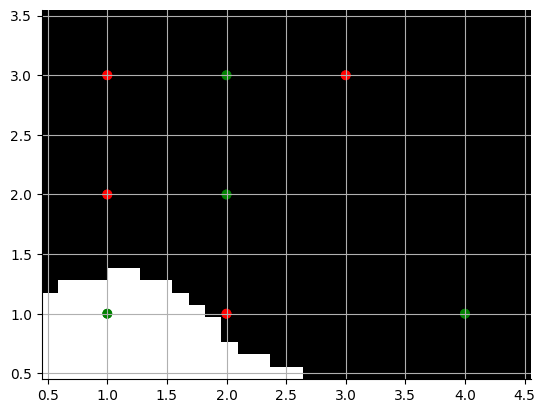

th [[  8.  22.  19.  20.  59.  13.  -2. -95.  77. -83.]] th0 [[8.]]


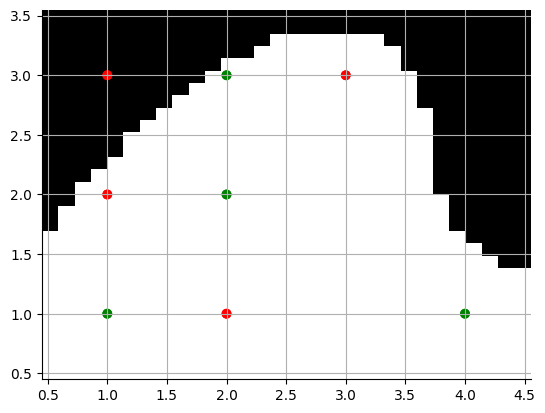

th [[  9.  24.  22.  24.  65.  22.   6. -83.  95. -56.]] th0 [[9.]]


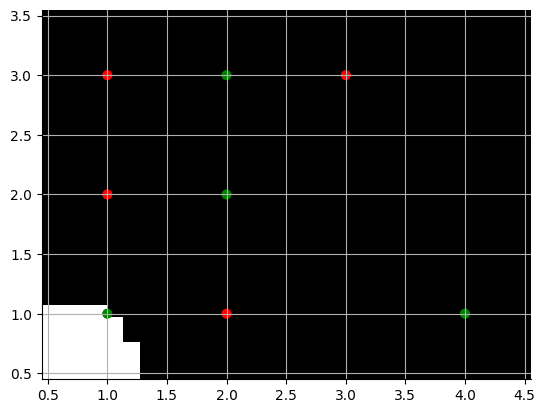

th [[   8.   21.   19.   15.   56.   13.  -21. -110.   68.  -83.]] th0 [[8.]]


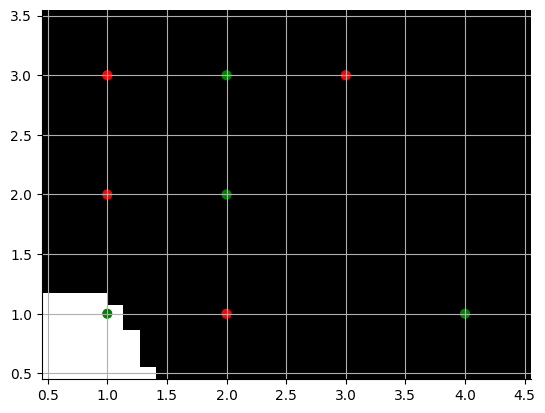

th [[   9.   22.   20.   16.   57.   14.  -20. -109.   69.  -82.]] th0 [[9.]]


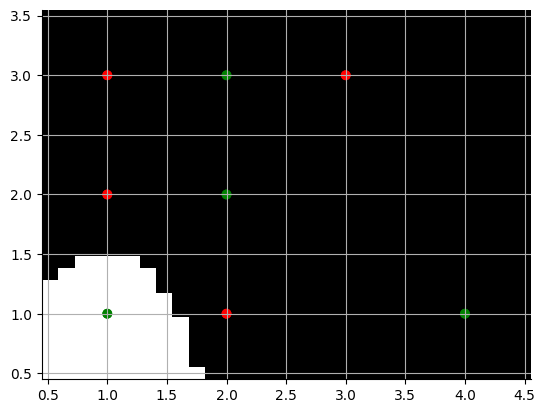

th [[  10.   24.   22.   20.   61.   18.  -12. -101.   77.  -74.]] th0 [[10.]]


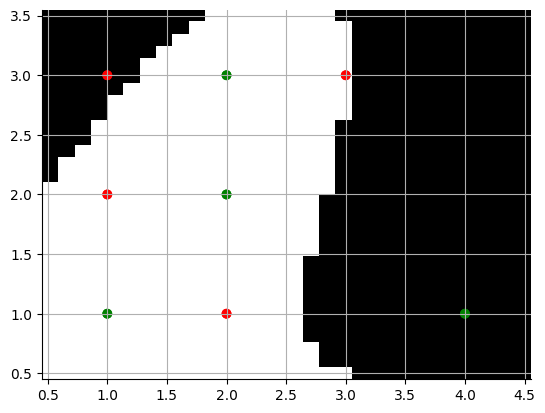

th [[ 11.  26.  25.  24.  67.  27.  -4. -89.  95. -47.]] th0 [[11.]]


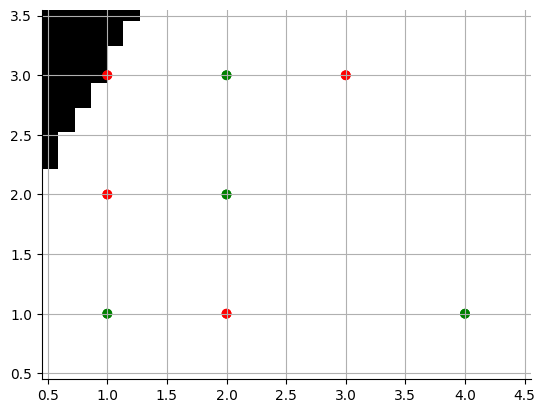

th [[ 12.  30.  26.  40.  71.  28.  60. -73.  99. -46.]] th0 [[12.]]


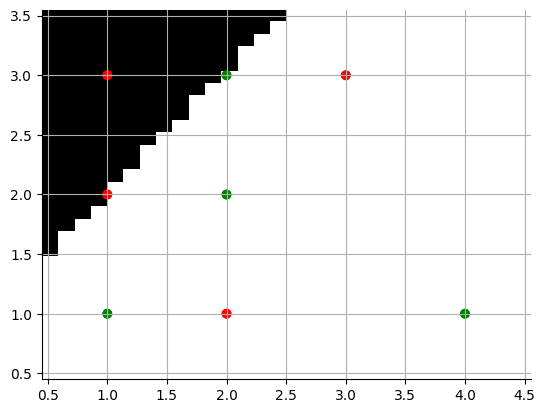

th [[ 11.  29.  23.  39.  68.  19.  59. -76.  90. -73.]] th0 [[11.]]


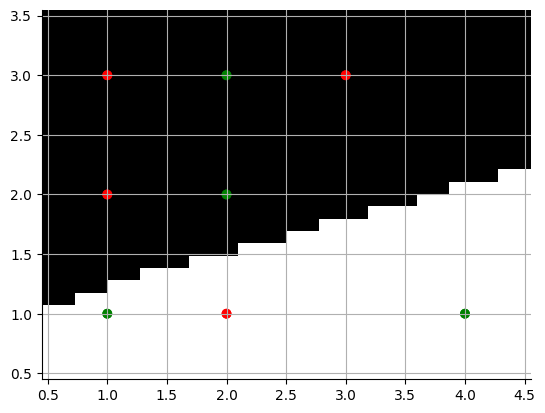

th [[  10.   26.   20.   30.   59.   10.   32. -103.   63. -100.]] th0 [[10.]]


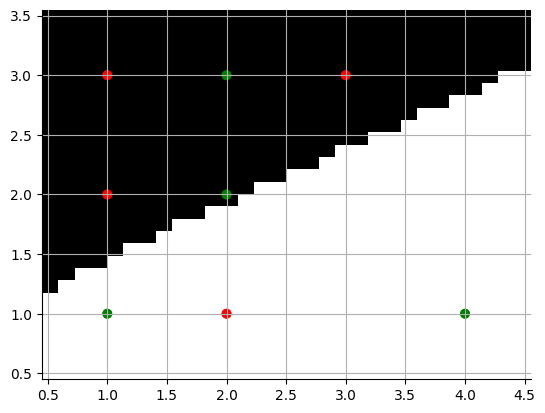

th [[ 11.  28.  22.  34.  63.  14.  40. -95.  71. -92.]] th0 [[11.]]


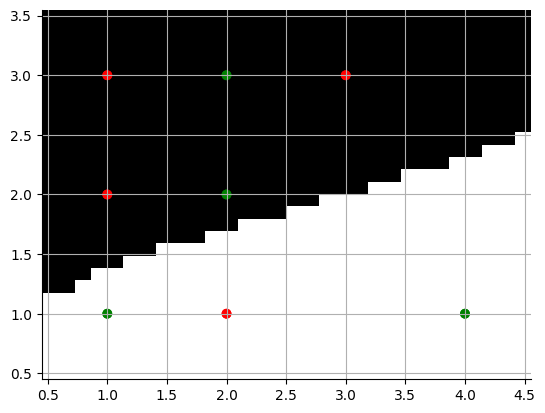

th [[ 10.  26.  21.  30.  61.  13.  32. -99.  69. -93.]] th0 [[10.]]


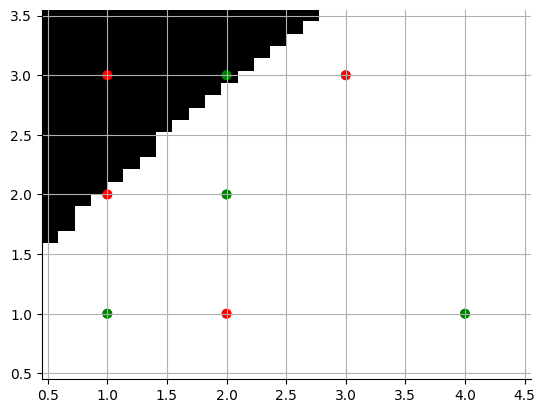

th [[ 11.  28.  24.  34.  67.  22.  40. -87.  87. -66.]] th0 [[11.]]


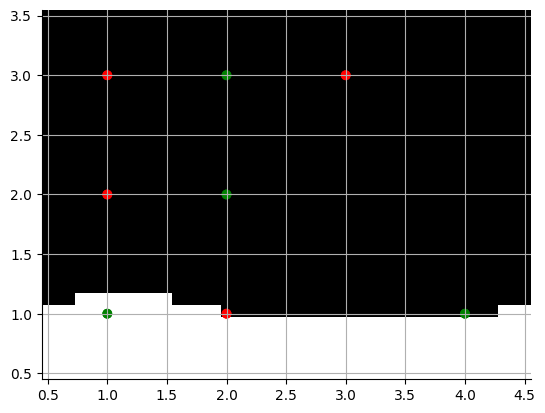

th [[  10.   25.   21.   25.   58.   13.   13. -114.   60.  -93.]] th0 [[10.]]


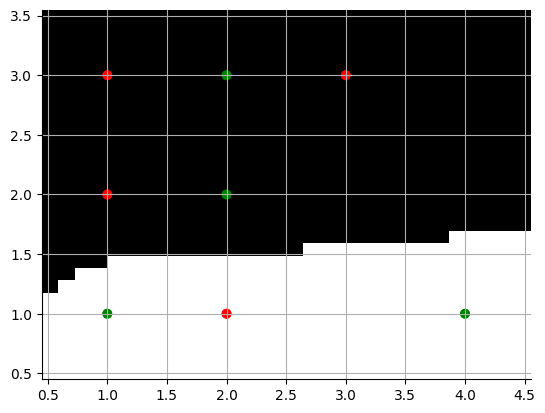

th [[  11.   27.   23.   29.   62.   17.   21. -106.   68.  -85.]] th0 [[11.]]


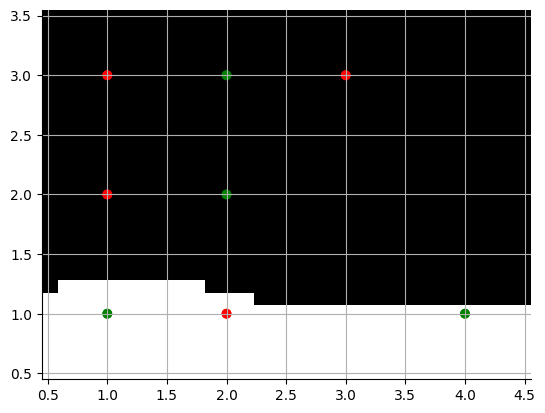

th [[  10.   25.   22.   25.   60.   16.   13. -110.   66.  -86.]] th0 [[10.]]


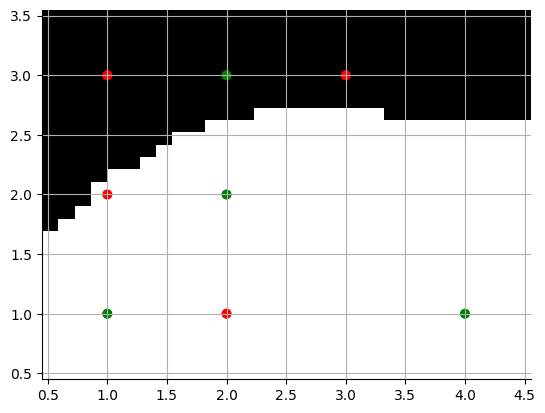

th [[ 11.  27.  25.  29.  66.  25.  21. -98.  84. -59.]] th0 [[11.]]


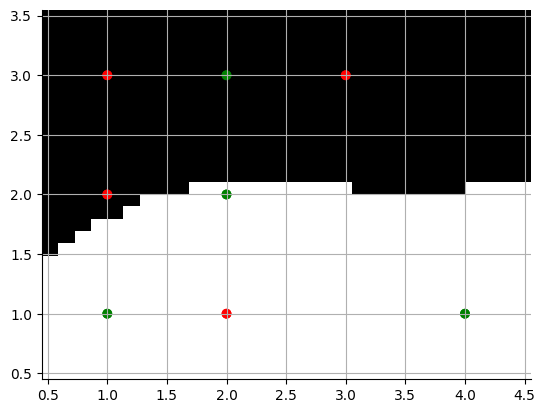

th [[  10.   26.   23.   28.   64.   21.   20. -100.   80.  -67.]] th0 [[10.]]


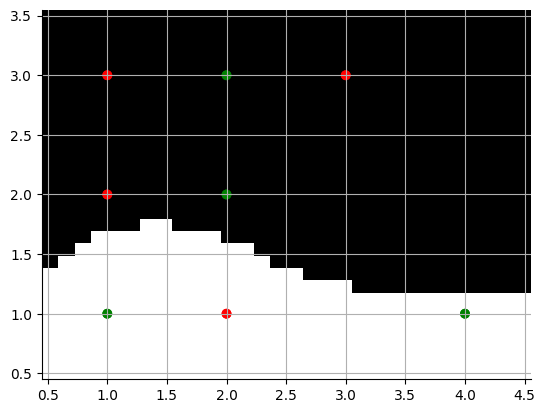

th [[   9.   24.   22.   24.   62.   20.   12. -104.   78.  -68.]] th0 [[9.]]


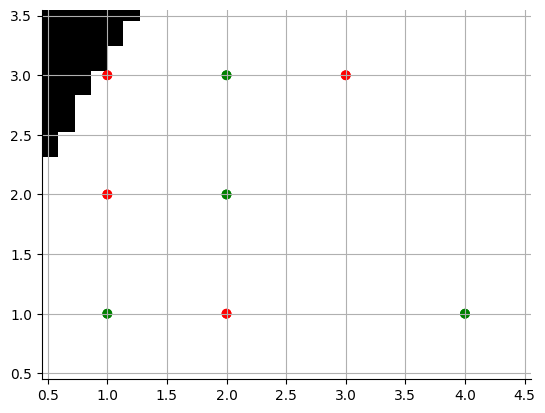

th [[ 10.  26.  25.  28.  68.  29.  20. -92.  96. -41.]] th0 [[10.]]


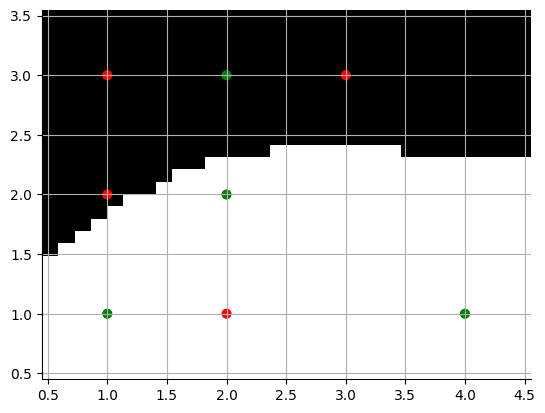

th [[  9.  25.  22.  27.  65.  20.  19. -95.  87. -68.]] th0 [[9.]]


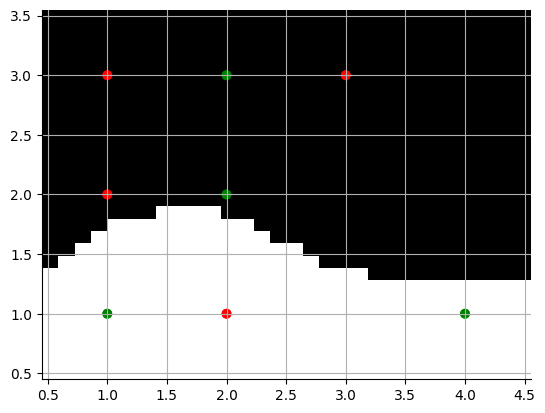

th [[  8.  23.  21.  23.  63.  19.  11. -99.  85. -69.]] th0 [[8.]]


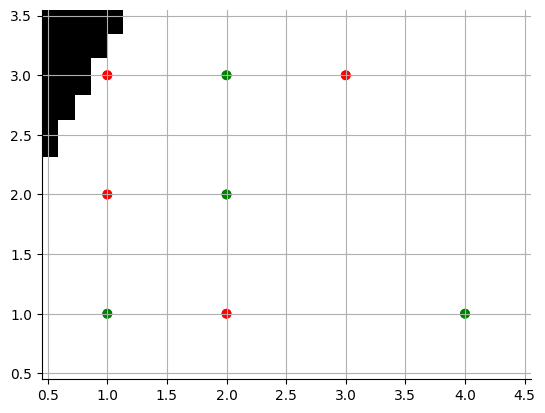

th [[  9.  25.  24.  27.  69.  28.  19. -87. 103. -42.]] th0 [[9.]]


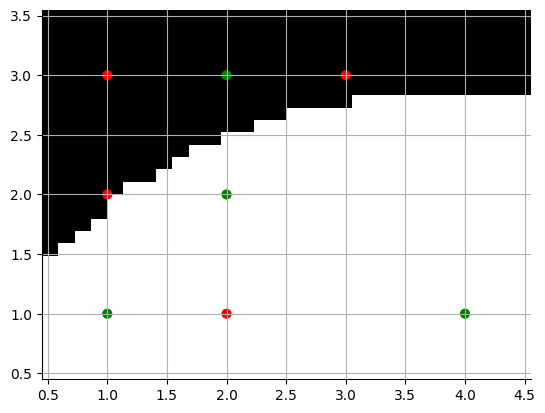

th [[  8.  24.  21.  26.  66.  19.  18. -90.  94. -69.]] th0 [[8.]]


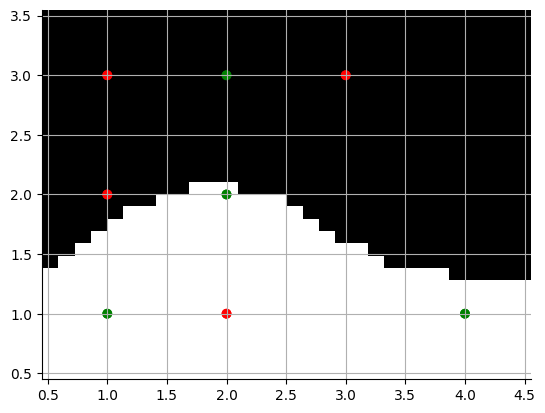

th [[  7.  22.  20.  22.  64.  18.  10. -94.  92. -70.]] th0 [[7.]]


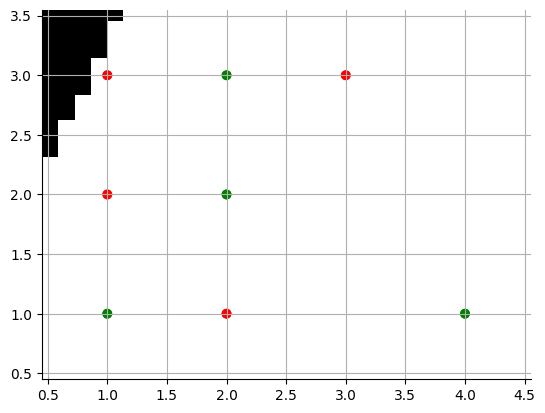

th [[  8.  24.  23.  26.  70.  27.  18. -82. 110. -43.]] th0 [[8.]]


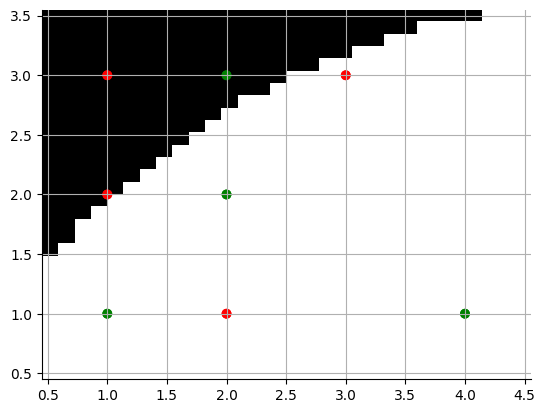

th [[  7.  23.  20.  25.  67.  18.  17. -85. 101. -70.]] th0 [[7.]]


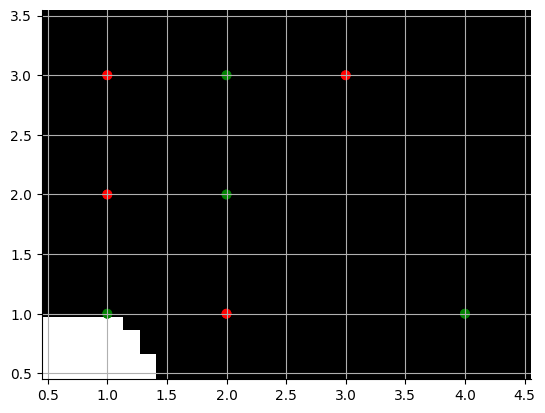

th [[   6.   20.   17.   16.   58.    9.  -10. -112.   74.  -97.]] th0 [[6.]]


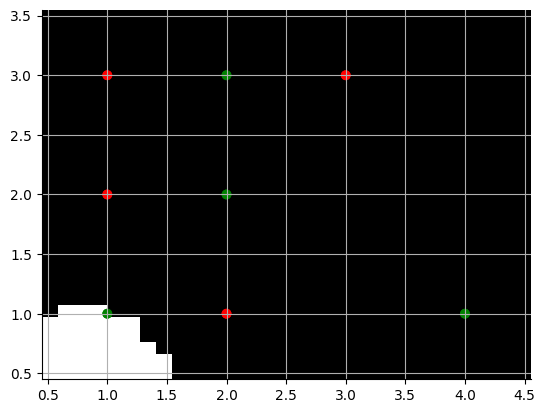

th [[   7.   21.   18.   17.   59.   10.   -9. -111.   75.  -96.]] th0 [[7.]]


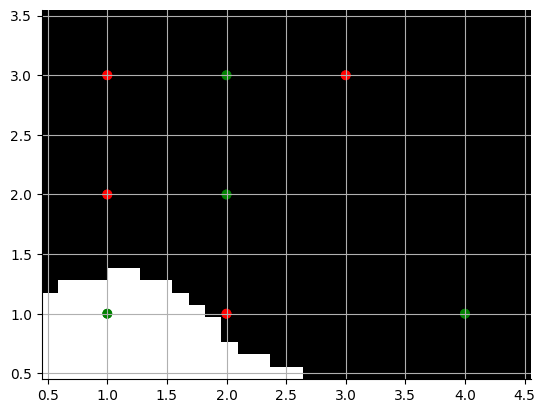

th [[   8.   23.   20.   21.   63.   14.   -1. -103.   83.  -88.]] th0 [[8.]]


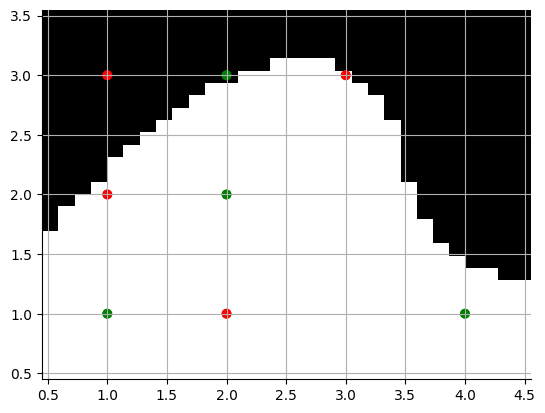

th [[  9.  25.  23.  25.  69.  23.   7. -91. 101. -61.]] th0 [[9.]]


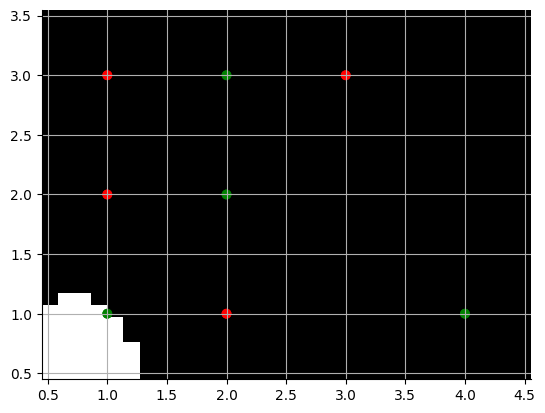

th [[   8.   22.   20.   16.   60.   14.  -20. -118.   74.  -88.]] th0 [[8.]]


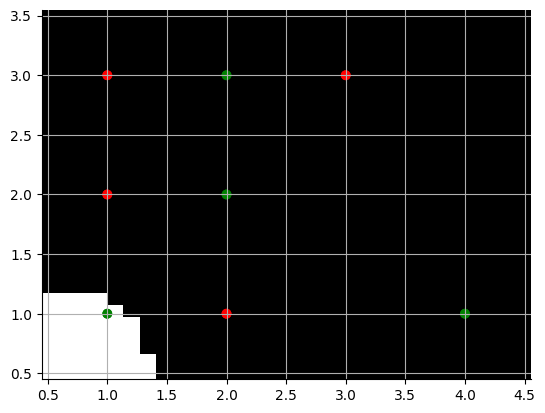

th [[   9.   23.   21.   17.   61.   15.  -19. -117.   75.  -87.]] th0 [[9.]]


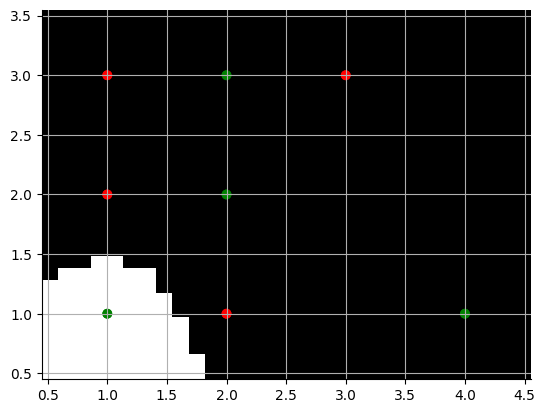

th [[  10.   25.   23.   21.   65.   19.  -11. -109.   83.  -79.]] th0 [[10.]]


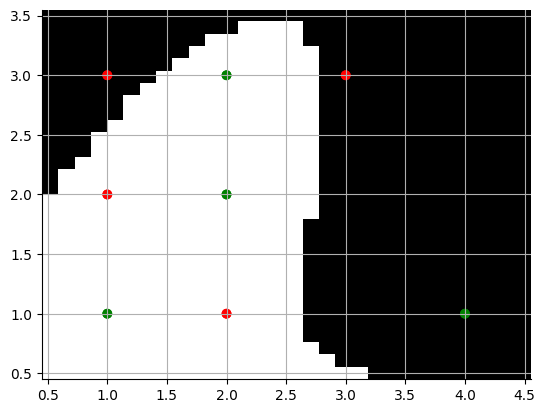

th [[ 11.  27.  26.  25.  71.  28.  -3. -97. 101. -52.]] th0 [[11.]]


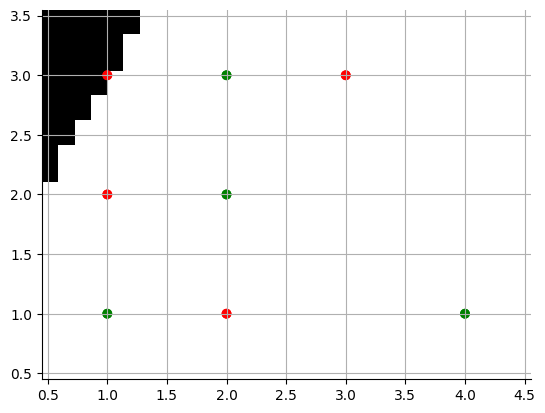

th [[ 12.  31.  27.  41.  75.  29.  61. -81. 105. -51.]] th0 [[12.]]


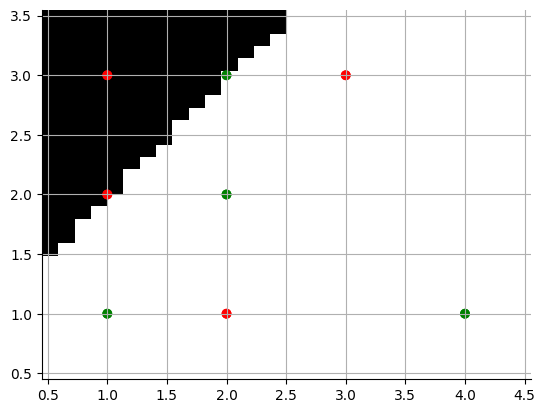

th [[ 11.  30.  24.  40.  72.  20.  60. -84.  96. -78.]] th0 [[11.]]


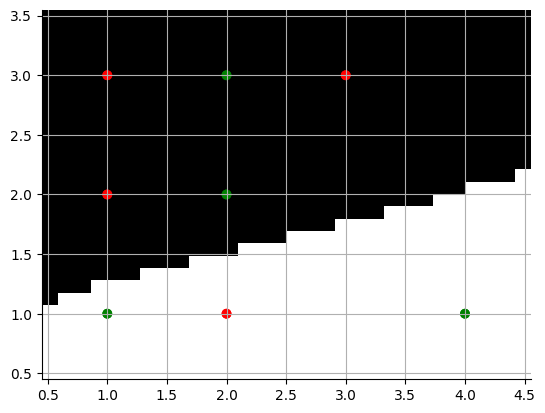

th [[  10.   27.   21.   31.   63.   11.   33. -111.   69. -105.]] th0 [[10.]]


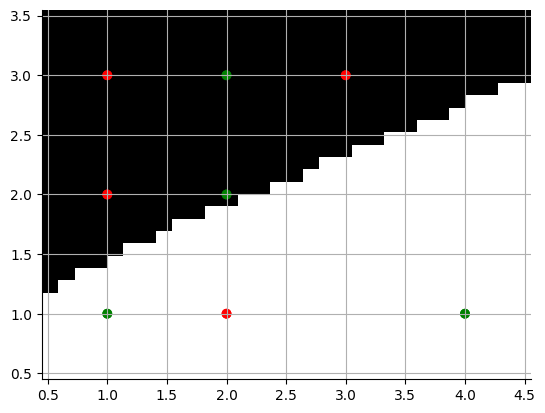

th [[  11.   29.   23.   35.   67.   15.   41. -103.   77.  -97.]] th0 [[11.]]


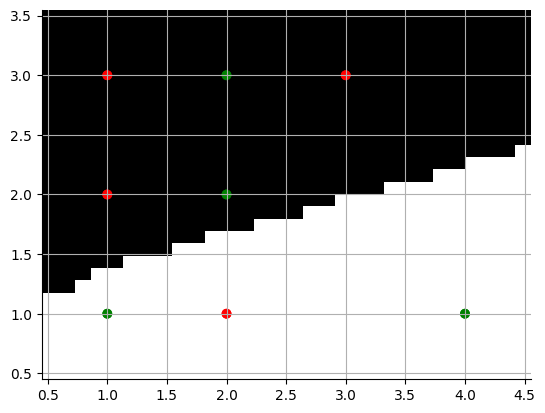

th [[  10.   27.   22.   31.   65.   14.   33. -107.   75.  -98.]] th0 [[10.]]


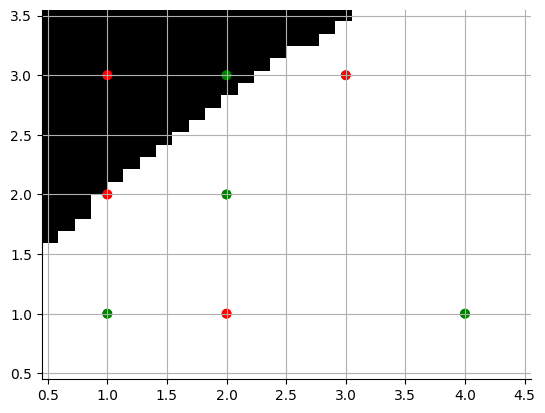

th [[ 11.  29.  25.  35.  71.  23.  41. -95.  93. -71.]] th0 [[11.]]


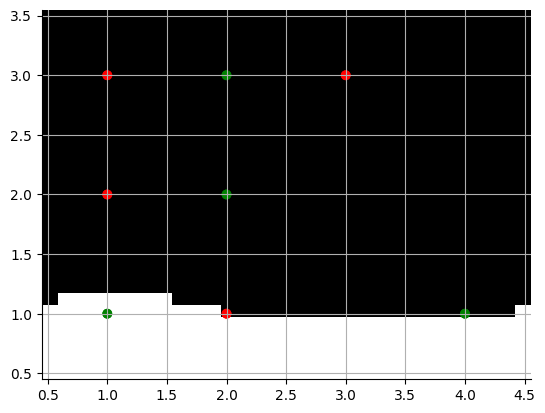

th [[  10.   26.   22.   26.   62.   14.   14. -122.   66.  -98.]] th0 [[10.]]


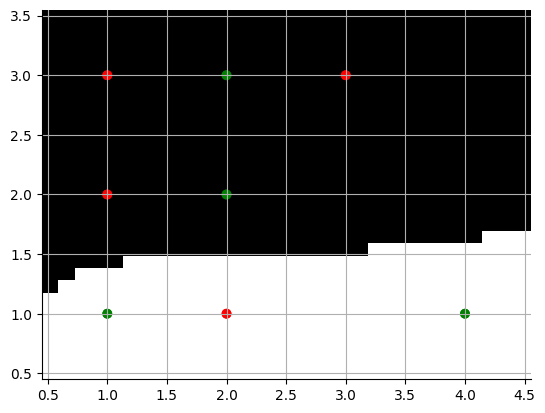

th [[  11.   28.   24.   30.   66.   18.   22. -114.   74.  -90.]] th0 [[11.]]


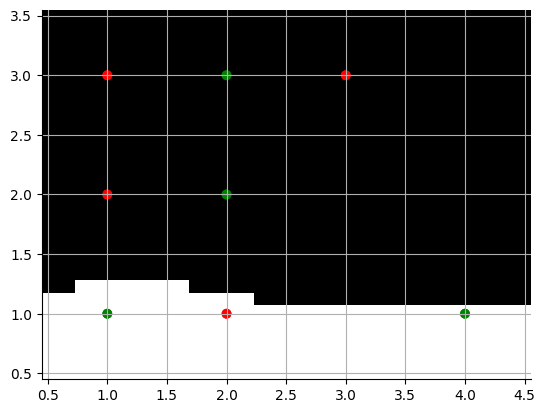

th [[  10.   26.   23.   26.   64.   17.   14. -118.   72.  -91.]] th0 [[10.]]


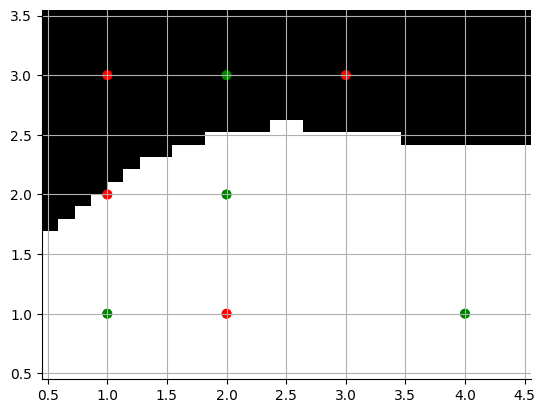

th [[  11.   28.   26.   30.   70.   26.   22. -106.   90.  -64.]] th0 [[11.]]


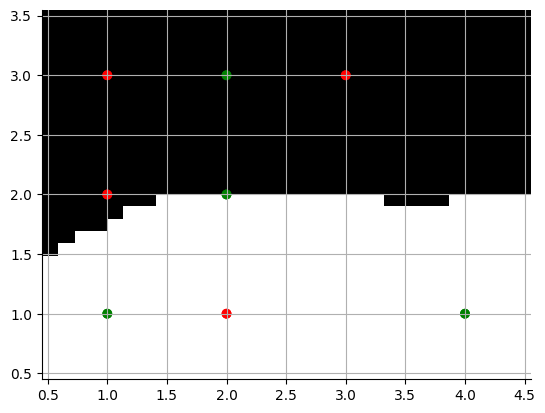

th [[  10.   27.   24.   29.   68.   22.   21. -108.   86.  -72.]] th0 [[10.]]


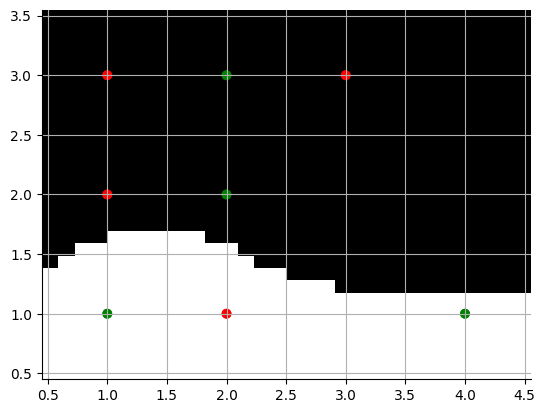

th [[   9.   25.   23.   25.   66.   21.   13. -112.   84.  -73.]] th0 [[9.]]


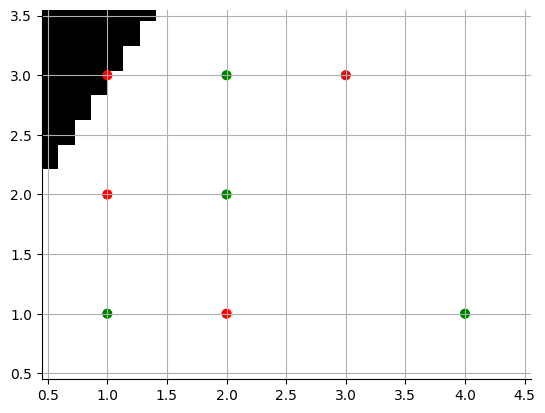

th [[  10.   27.   26.   29.   72.   30.   21. -100.  102.  -46.]] th0 [[10.]]


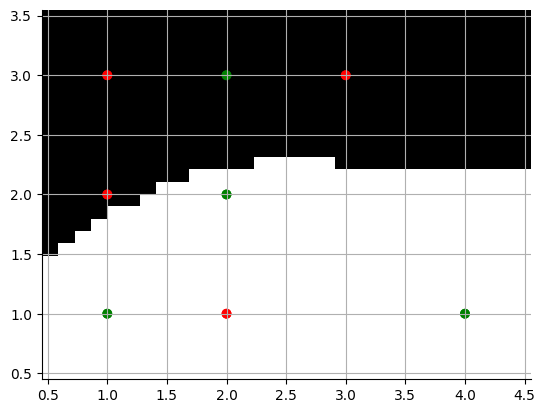

th [[   9.   26.   23.   28.   69.   21.   20. -103.   93.  -73.]] th0 [[9.]]


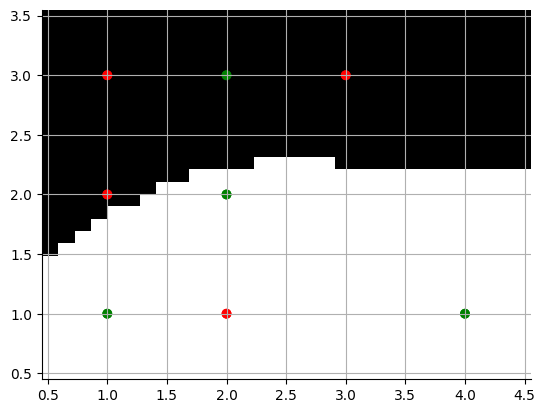

th [[   9.   26.   23.   28.   69.   21.   20. -103.   93.  -73.]] th0 [[9.]]
Final score 6
Params [[   9.   26.   23.   28.   69.   21.   20. -103.   93.  -73.]] [[9.]]
False


In [3]:
def test_linear_classifier_with_features(dataFun, learner, feature_fun,
                             draw = True, refresh = True, pause = True):
    raw_data, labels = dataFun()
    data = feature_fun(raw_data) if feature_fun else raw_data
    d, n = data.shape
    if draw:
        def hook(params):
            ax = plot_data(raw_data, labels)   # create plot axis on each iteration
            (th, th0) = params
            predictor = lambda x1,x2: int(positive(feature_fun(cv([x1, x2])), th, th0))
            plot_nonlin_sep(
                predictor,
                ax = ax)
            plot_data(raw_data, labels, ax)
            plt.show()                         # force plot to push to the colab notebook and be displayed
            print('th', th.T, 'th0', th0)
            if pause: input('press enter here to continue:')
    else:
        hook = None
    th, th0 = learner(data, labels, hook = hook)
    if hook: hook((th, th0))
    classifier_score = int(score(data, labels, th, th0))
    print("Final score", classifier_score)
    print("Params", np.transpose(th), th0)
    return classifier_score == n

def test_with_features(dataFun, order = 2, draw=True, pause=True):
    can_separate_data = test_linear_classifier_with_features(
        dataFun,       # data
        perceptron,    # learner
        make_polynomial_feature_fun(order), # feature maker
        draw=draw,
        pause=pause)
    return can_separate_data
    
# 3B
def find_smallest_polynomial_order_for_separator(dataFun):
    degree = 0
    can_separate_data = False
    while degree <= 50:
        can_separate_data = test_with_features(dataFun, order=degree, draw=True, pause=False)
        if can_separate_data:
            return degree, can_separate_data
        else:
            degree += 1
    return degree, can_separate_data

data_functions = [super_simple_separable_through_origin, super_simple_separable, xor, xor_more]
data_sets_smallest_polynomial_order_for_separator = []
for data_function in data_functions:
    data_sets_smallest_polynomial_order_for_separator += [find_smallest_polynomial_order_for_separator(data_function)]
for degree, can_separate_data in data_sets_smallest_polynomial_order_for_separator:
    print(degree, can_separate_data)

# print(test_with_features(super_simple_separable_through_origin, order=1, draw=False, pause=False))
# print(test_with_features(super_simple_separable, order=1, draw=False, pause=False))
# print(test_with_features(xor, order=2, draw=False, pause=False))
# print(test_with_features(xor_more, order=3, draw=True, pause=False))

Here's a test you can run to see plots:

In [18]:
# test_with_features(super_simple_separable, order=2, draw=True, pause=False)

# Experiments

## 4) Evaluating algorithmic and feature choices for AUTO data

We now want to build a classifier for the auto data, focusing on the
numeric data.  In the code file for this part of the assignment, we have supplied you
with the `load_auto_data` function, that can be used to read the
relevant .tsv file.  It will return a list of dictionaries, one for each data item.

We then have to specify what feature function to use for each column
in the data.  The file `hw3_part2_main.py` has an example for constructing
the data and label arrays using `raw` feature function for all the columns.
Look at the definition of `features` in `hw3_part2_main.py`, this indicates a feature name to
use and then a feature function, there are three defined in the
`code_for_hw3_part2.py` file (`raw`, `standard` and `one_hot`).  `raw` just uses
the original value, `standard` subtracts out the mean value and
divides by the standard deviation and `one_hot` does the encoding
described in the notes.

The function `auto_data_and_labels` will process the dictionaries and
return <tt>data, labels</tt> where <tt>data</tt> are arrays of
dimension $(d, 392)$, with $d$ the total number of features specified,
and <tt>labels</tt> is of dimension $(1, 392)$.  The data in the file
is sorted by class, but it will be shuffled when you read it in.

We have included staff implementations of perceptron and average perceptron in `code_for_hw3_part2.py`. Using the feature arrays and these implementations, you will be able to compute $\theta$ and $\theta_0$.

We have also included staff implementations of `eval_classifier` and `xval_learning_alg` (in the same code file). You should use these functions to report accuracies.

## 4.1) Making choices
We know of two algorithm classes: perceptron and averaged perceptron (which we implemented in HW 1). We have several parameters that specify the settings for these learning algorithms.

__A)__ Which parameters should we use for the learning algorithm? In the perceptron and averaged perceptron, there is a single parameter, $T$, the number of iterations.

__B)__ Which features should we use? We have lots of choices here: we can use any subset of the data columns and for each column we have choices of how to compute features.

__C)__ We will use expected accuracy, estimated by 10-fold cross-validation (we have included the definition in the code file), to make these choices of parameters.





* We will try two types of algorithms: perceptron and averaged perceptron.
* We will try 3 values of $T: T=1,\ T=10, \ T=50$ 
* We will try 2 feature sets:


```
1.) [cylinders=raw, displacement=raw, horsepower=raw, weight=raw, acceleration=raw, origin=raw]
2.) [cylinders=one_hot, displacement=standard, horsepower=standard, weight=standard, acceleration=standard, origin=one_hot]
```
Perform 10-fold cross-validation for all combinations of the two algorithms, three 
$T$ values, and the two choices of feature sets. It will be worthwhile investing in a piece of code to carry out all of the evaluations, in case you need to do this more than once.

In general, you should shuffle the dataset before evaluating, but for this exercise, please use `hw3.xval_learning_alg`, which shuffles the dataset for you, so that your results match ours.

## 4.1C i)
Enter accuracies (perceptron, averaged perceptron) for $T=1$, feature set 1:

$(0.6526282051282052, 0.8441025641025641)$

## 4.1C ii)
Enter accuracies (perceptron, averaged perceptron) for $T=1$, feature set 2:

$(0.7908333333333333, 0.9004487179487182)$

## 4.1C iii)
Enter accuracies (perceptron, averaged perceptron) for $T=10$, feature set 1:

$(0.7423076923076924, 0.8366025641025641)$

## 4.1C iv)
Enter accuracies (perceptron, averaged perceptron) for $T=10$, feature set 2:

$(0.8061538461538461, 0.8979487179487181)$

## 4.1C v)
Enter accuracies (perceptron, averaged perceptron) for $T=50$, feature set 1:

$(0.6909615384615384, 0.8366025641025641)$

## 4.1C vi)
Enter accuracies (perceptron, averaged perceptron) for $T=50$, feature set 2:

$(0.8060256410256409, 0.9005128205128207)$

Now we have the data we need to make rational choices.

## 4.1D) Which algorithm class is typically more effective?

`average_perceptron`

## 4.1E) For the better algorithm, which combination of T and feature would you use?
Consider expected accuracy as of primary importance, take into account running time for near ties in accuracy.
Enter a tuple of two integers `(T, feature_set)`:

$(1, 2)$

## 4.2) Analysis

## 4.2 A) 
For the best algorithm type, best $T$ and best feature set, construct your best classifier $(\theta, \theta_0)$ using all the data. Based on the values of the coefficients, which feature has the most impact on the output predictions?

## 4.2 B) (Optional) 
Is there any set of two features you can use to attain comparable results as your best accuracy? What are they?



In [58]:
# Returns a list of dictionaries.  Keys are the column names, including mpg.
auto_data_all = hw3.load_auto_data('auto-mpg.tsv')

# The choice of feature processing for each feature, mpg is always raw and
# does not need to be specified.  Other choices are hw3.standard and hw3.one_hot.
# 'name' is not numeric and would need a different encoding.
features = [('cylinders', hw3.raw),
            ('displacement', hw3.raw),
            ('horsepower', hw3.raw),
            ('weight', hw3.raw),
            ('acceleration', hw3.raw),
            ## Drop model_year by default
            ## ('model_year', hw3.raw),
            ('origin', hw3.raw)]

# Construct the standard data and label arrays
auto_data, auto_labels = hw3.auto_data_and_labels(auto_data_all, features)
print('auto data and labels shape', auto_data.shape, auto_labels.shape)

avg and std {}
entries in one_hot field {}
auto data and labels shape (6, 392) (1, 392)


In [65]:
# Your code here to process the auto data
# 4.1
def evaluate_algorithmic_and_feature_choices(data, learner, T, feature_set, k):
    auto_data, auto_labels = hw3.auto_data_and_labels(data, feature_set)
    learner_set_T_param = lambda data, labels: learner(data, labels, {'T': T})
    accuracy = xval_learning_alg(learner_set_T_param, auto_data, auto_labels, k)
    return accuracy

auto_data_all = hw3.load_auto_data('auto-mpg.tsv')

learners = [perceptron, averaged_perceptron]
T_vals = [1, 10, 50]
feature_set_1 = [('cylinders', hw3.raw),
            ('displacement', hw3.raw),
            ('horsepower', hw3.raw),
            ('weight', hw3.raw),
            ('acceleration', hw3.raw),
            ## Drop model_year by default
            ## ('model_year', hw3.raw),
            ('origin', hw3.raw)]
feature_set_2 = [('cylinders', hw3.one_hot),
            ('displacement', hw3.standard),
            ('horsepower', hw3.standard),
            ('weight', hw3.standard),
            ('acceleration', hw3.standard),
            ## Drop model_year by default
            ## ('model_year', hw3.raw),
            ('origin', hw3.one_hot)]
feature_sets = [feature_set_1, feature_set_2]
k = 10

for T in T_vals:
    for learner in learners:
        for i, feature_set in enumerate(feature_sets, 1):
            accuracy = evaluate_algorithmic_and_feature_choices(auto_data_all, learner, T, feature_set, k)
            print(f'learner: {learner.__name__}, T: {T}, feature_set: {i}, accuracy: {accuracy}')

auto_data, auto_labels = hw3.auto_data_and_labels(auto_data_all, feature_set_2)
theta_avg, theta_0_avg = averaged_perceptron(auto_data, auto_labels, {'T': 1})
print(theta_avg, theta_0_avg)

avg and std {}
entries in one_hot field {}
learner: perceptron, T: 1, feature_set: 1, accuracy: 0.6526282051282052
avg and std {'displacement': (388.3482142857143, 302.0458123396403), 'horsepower': (509.3545918367347, 333.6521151716361), 'weight': (2977.5841836734694, 848.3184465698365), 'acceleration': (15.541326530612228, 2.7553429127509963)}
entries in one_hot field {'cylinders': [3.0, 4.0, 5.0, 6.0, 8.0], 'origin': [1.0, 2.0, 3.0]}
learner: perceptron, T: 1, feature_set: 2, accuracy: 0.7908333333333333
avg and std {}
entries in one_hot field {}
learner: averaged_perceptron, T: 1, feature_set: 1, accuracy: 0.8441025641025641
avg and std {'displacement': (388.3482142857143, 302.0458123396403), 'horsepower': (509.3545918367347, 333.6521151716361), 'weight': (2977.5841836734694, 848.3184465698365), 'acceleration': (15.541326530612228, 2.7553429127509963)}
entries in one_hot field {'cylinders': [3.0, 4.0, 5.0, 6.0, 8.0], 'origin': [1.0, 2.0, 3.0]}
learner: averaged_perceptron, T: 1, fea

## 5) Evaluating algorithmic and feature choices for review data

We have supplied you with the `load_review_data`
function, that can be used to read a .tsv file and return the labels
and texts. We have also supplied you with the `bag_of_words` function,
which takes the raw data and returns a dictionary of unigram
words. The resulting dictionary is an input to
`extract_bow_feature_vectors` which computes a feature matrix of ones
and zeros that can be used as the input for the classification
algorithms.  The file `hw3_part2_main.py` has code for constructing
the data and label arrays.  Using these arrays and our implementation
of the learning algorithms, you will be able to compute $\theta$ and
$\theta_0$.  You will need to add your (or the one written by staff)
implementation of perceptron and averaged perceptron.

## 5.1) Making choices
We have two algorithm classes: `perceptron` and `averaged_perceptron`. We have a couple of choices of parameters to make to completely specify the learning algorithms.

## 5.1A) 
Which parameters should we use for the learning algorithm? In the perceptron and averaged perceptron, there is a single parameter, $T$, the number of iterations.

## 5.1B) 
Which features should we use? We could do variations of bag-of-words, for example, simply indicating whether a word is present or, alternatively, using a count of how many times it is present. We can also remove commonly used words with little information; the code distribution includes a file of those words: `stopwords.txt`. You're welcome to explore these on your own; we'll use only a binary indicator for all the words.

## 5.1C) 
Perform 10-fold cross-validation for all combinations of the two algorithms and three 
$T$ values (1, 10, 50). Record the accuracies for each combination (there should be 6 values total).

Note: These tests may take a couple of minutes to run; don't expect instant response, but it shouldn't run for 10 minutes.

Now we have the data we need to make rational choices.

## 5.1D) 
Which algorithm class is typically more effective?

`average_perceptron`

## 5.1E) 
For the better algorithm, which value of $T$ would you use? Consider expected accuracy as of primary importance, take into account running time for near ties in accuracy. Enter a value of $T$:

$10$

## 5.1F)
For the better algorithm and best value of $T$, what is your accuracy? Enter a number between 0 and 1:

$0.8237$

## 5.2) Analysis
For the best algorithm and best $T$, construct your best classifier $(\theta,\ \theta_0)$ using all the data.

Note: We have included a function called `reverse_dict` in `code_for_hw3_part2.py` that you may find convenient. You are not required to use this function.

## 5.2A)
What are the 10 most positive words in the dictionary, that is, the words that contribute most to a positive prediction? Enter a Python list of ten strings:

$['great', 'individually', 'bright', 'yummy', 'skeptical', 'perfect', 'easily', 'satisfied', 'delicious', 'excellent']$

## 5.2B)
What are the 10 most negative words in the dictionary, that is, the words that contribute most to a negative prediction. Enter a Python list of ten strings:

$['worst', 'awful', 'unfortunately', 'horrible', 'stuck', 'changed', 'disappointment', 'bland', 'poor', 'formula']$

$$

## 5.2C) (Optional)
You might find it amusing to find the most positive and most negative reviews. That is, ones with the most positive and negative signed distance to the hyperplane.


In [69]:
# Returns lists of dictionaries.  Keys are the column names, 'sentiment' and 'text'.
# The train data has 10,000 examples
review_data = hw3.load_review_data('reviews.tsv')

# Lists texts of reviews and list of labels (1 or -1)
review_texts, review_label_list = zip(*((sample['text'], sample['sentiment']) for sample in review_data))

# The dictionary of all the words for "bag of words"
dictionary = hw3.bag_of_words(review_texts)

# The standard data arrays for the bag of words
review_bow_data = hw3.extract_bow_feature_vectors(review_texts, dictionary)
review_labels = hw3.rv(review_label_list)
print('review_bow_data and labels shape', review_bow_data.shape, review_labels.shape)

review_bow_data and labels shape (19945, 10000) (1, 10000)


In [85]:
# 5.1
perceptron_set_T_param = lambda T: lambda data, labels: perceptron(data, labels, {'T': T})
average_perceptron_set_T_param = lambda T: lambda data, labels: averaged_perceptron(data, labels, {'T': T})

T1_p = xval_learning_alg(perceptron_set_T_param(1), review_bow_data, review_labels, 10)
T1_a = xval_learning_alg(average_perceptron_set_T_param(1), review_bow_data, review_labels, 10)

T10_P = xval_learning_alg(perceptron_set_T_param(10), review_bow_data, review_labels, 10)
T10_a = xval_learning_alg(average_perceptron_set_T_param(10), review_bow_data, review_labels, 10)

T50_P = xval_learning_alg(perceptron_set_T_param(50), review_bow_data, review_labels, 10)
T50_a = xval_learning_alg(average_perceptron_set_T_param(50), review_bow_data, review_labels, 10)

print(T1_p, T1_a)
print(T10_P, T10_a)
print(T50_P, T50_a)

print(xval_learning_alg(average_perceptron_set_T_param(10), review_bow_data, review_labels, 10))

# 5.2
theta_avg, theta_0_avg = averaged_perceptron(review_bow_data, review_labels, {'T': 10})
d, n = theta_avg.shape
reversed_dictionary = hw3.reverse_dict(dictionary)
theta_avg_flattened = theta_avg.flatten()
weights_argsort = np.argsort(theta_avg_flattened)
indices_of_words_with_most_weight = weights_argsort[-10:]
words_with_most_weight = [reversed_dictionary[index] for index in indices_of_words_with_most_weight]
indices_of_words_with_least_weight = weights_argsort[:10]
words_with_least_weight = [reversed_dictionary[index] for index in indices_of_words_with_least_weight]
print(words_with_most_weight)
print(words_with_least_weight)

## 6) Evaluating features for MNIST data


This problem explores how well the perceptron algorithm works to <a
href="http://neuralnetworksanddeeplearning.com/chap1.html">classify
images of handwritten digits</a>, from the well-known ("MNIST")
dataset, buiding on your thoughts from lab about extracting features
from images.  This exercise will highlight how important feature
extraction is, before linear classification is done, using algorithms
such as the perceptron.

<b>Dataset setup</b>

Often, it may be easier to work with a vector whose spatial orientation is preserved.
In previous parts, we have represented features as one long feature vector.
For images, however, we often represent a $m$ by $n$ image
as a `(m,n)` array, rather than a `(mn,1)` array
(as the previous parts have done).

In the code file, we have supplied you with the `load_mnist_data` function,
which will read from the provided image files and populate a dictionary,
with image and label vectors for each numerical digit from 0 to 9.
These images are already shaped as `(m,n)` arrays.

## 6.1) Feature extraction
In the real world, there may be complicated ways to extract meaningful features from images, but in this section we will explore several simple methods.

## 6.1A) 
You may notice that some numbers (like 8) take up more horizontal space than others (like 1). We can compute a feature based on the average value in each row. Write a Python function that takes in a `(m,n)` array and returns a `(m,1)` array, where element $i$ is the average value in row $i$.

## 6.1B) 
We can also compute a feature based on the average value in each column. Write a Python function that takes in a `(m,n)` array and returns a `(n,1)` array, where element $j$ is the average value in column $j$.

## 6.1C) 
Finally, you may notice that some features are more "top heavy" while others are more "bottom heavy." Write a function that takes in a `(m,n)` array and returns a `(2,1)` array, where the first element is the average value in the top half of the image, and the second element is the average value in the bottom half of the image.

You may use the `cv` function from homework 1.
__Important__: In `hw3_part2_main.py`, you may need to modify these functions to accept a data matrix of size `(n, 28, 28)`, or you may use these functions in other ways (loops are allowed).

## 6.2) Feature evaluation
We can use these features to distinguish between numbers.

Important: For this section, we will be using $T=50$ with the base perceptron algorithm to train our classifier and 10-fold cross validation to evaluate our classifier. A function called `get_classification_accuracy` has already been implemented for you in `code_for_hw3_part2` to compute the accuracy, given your selected data and labels.

You must use our implementation of cross validation to report accuracies (you may call `hw3.xval_learning_alg`).

## 6.2A) 
First we will find baseline accuracies using the raw 0-1 features.

Convert each image into a $(28*28, 1)$ vector for input into the perceptron algorithm. Hint: `np.reshape` may be helpful here.

Run the perceptron on four tasks: 0 vs. 1, 2 vs. 4, 6 vs. 8, and 9 vs. 0. Enter a list of accuracies $[0 vs. 1, 2 vs. 4, 6 vs. 8, 9 vs. 0]$:

$[0.975, 0.8641666666666665, 0.9479166666666667, 0.6470833333333333]$

Now let's evaluate the features we extracted.

## 6.2B) 
Using the extracted features from above, run the perceptron algorithm on the set of 0 vs. 1 images. Enter a list of accuracies $[row, column, top/bottom]$:

$[0.48125, 0.6375, 0.48125]$

## 6.2C) 
Using the extracted features from above, run the perceptron algorithm on the set of 2 vs. 4 images. Enter a list of accuracies $[row, column, top/bottom]$:

$[0.7754166666666668, 0.49749999999999994, 0.49749999999999994]$

## 6.2D)
Using the extracted features from above, run the perceptron algorithm on the set of 6 vs. 8 images. Enter a list of accuracies $[row, column, top/bottom]$:

$[0.92125, 0.52125, 0.5650000000000001]$

## 6.2E) 
Using the extracted features from above, run the perceptron algorithm on the set of 9 vs. 0 images. Enter a list of accuracies $[row, column, top/bottom]$:

$[0.49749999999999994, 0.5041666666666667, 0.49749999999999994]$

## 6.2F) (Optional) 
What does it mean if a binary classification accuracy is below 0.5, if your dataset is balanced (same number from each class)? Are these datasets balanced?

## 6.2G) (Optional) 
Feel free to classify other images from each other. Which combinations perform the best, and which perform the worst? Do these make sense? Other than row and column average, are there any other features you could think of that would preserve some spatial information?

In [133]:
mnist_data_all = hw3.load_mnist_data(range(10))

print('mnist_data_all loaded. shape of single images is', mnist_data_all[0]["images"][0].shape)

# HINT: change the [0] and [1] if you want to access different images
d0 = mnist_data_all[0]["images"]
d1 = mnist_data_all[1]["images"]
y0 = np.repeat(-1, len(d0)).reshape(1,-1)
y1 = np.repeat(1, len(d1)).reshape(1,-1)

# data goes into the feature computation functions
data = np.vstack((d0, d1))
# labels can directly go into the perceptron algorithm
labels = np.vstack((y0.T, y1.T)).T

mnist_data_all loaded. shape of single images is (28, 28)


In [146]:
# change these implementations to support whole datasets
def raw_mnist_features(x):
    """
    @param x (n_samples,m,n) array with values in (0,1)
    @return (m*n,n_samples) reshaped array where each entry is preserved
    """
    n_samples, m, n = x.shape
    return x.reshape((n_samples, m*n)).T
    

def row_average_features(x):
    """
    This should either use or modify your code from the tutor questions.

    @param x (n_samples,m,n) array with values in (0,1)
    @return (m,n_samples) array where each entry is the average of a row
    """
    return np.mean(x, axis=2).T


def col_average_features(x):
    """
    This should either use or modify your code from the tutor questions.

    @param x (n_samples,m,n) array with values in (0,1)
    @return (n,n_samples) array where each entry is the average of a column
    """
    return np.mean(x, axis=1).T


def top_bottom_features(x):
    """
    This should either use or modify your code from the tutor questions.

    @param x (n_samples,m,n) array with values in (0,1)
    @return (2,n_samples) array where the first entry of each column is the average of the
    top half of the image = rows 0 to floor(m/2) [exclusive]
    and the second entry is the average of the bottom half of the image
    = rows floor(m/2) [inclusive] to m
    """
    n_samples, m, n = x.shape
    mid = m // 2
    tops = x[:, :mid, :]
    bottoms = x[:, mid:, :]
    top_means = np.mean(tops, axis=(1,2), keepdims=True).reshape(1, n_samples)
    bottom_means = np.mean(bottoms, axis=(1,2), keepdims=True).reshape(1, n_samples)
    return np.concatenate((top_means, bottom_means))

In [149]:
# use this function to evaluate accuracy
# acc = hw3.get_classification_accuracy(raw_mnist_features(data), labels)

def get_mnist_data_set_for_two_numbers(mnist_data_all, n1, n2):
    d_n1 = mnist_data_all[n1]["images"]
    d_n2 = mnist_data_all[n2]["images"]
    y_n1 = np.repeat(-1, len(d_n1)).reshape(1,-1)
    y_n2 = np.repeat(1, len(d_n2)).reshape(1,-1)
    data = np.concatenate((d_n1, d_n2))
    labels = np.concatenate((y_n1, y_n2), axis=1)
    return data, labels

# 6.2
feature_extractors = [row_average_features, col_average_features, top_bottom_features]
tasks = [(0, 1), (2, 4), (6, 8), (9, 0)]

# 6.2A
raw_mnist_features_accuracies = []
for n1, n2 in tasks:
    data, labels = get_mnist_data_set_for_two_numbers(mnist_data_all, n1, n2)
    accuracy = hw3.get_classification_accuracy(raw_mnist_features(data), labels)
    raw_mnist_features_accuracies += [accuracy]
print(raw_mnist_features_accuracies)

# 6.2B
for n1, n2 in tasks:
    feature_extractors_accuracies = []
    for feature_extractor in feature_extractors:
        data, labels = get_mnist_data_set_for_two_numbers(mnist_data_all, n1, n2)
        accuracy = hw3.get_classification_accuracy(feature_extractor(data), labels)
        feature_extractors_accuracies += [accuracy]
    print(f"{n1} vs. {n2}:", feature_extractors_accuracies)
        

[0.975, 0.8641666666666665, 0.9479166666666667, 0.6470833333333333]
0 vs. 1: [0.48125, 0.6375, 0.48125]
2 vs. 4: [0.7754166666666668, 0.49749999999999994, 0.49749999999999994]
6 vs. 8: [0.92125, 0.52125, 0.5650000000000001]
9 vs. 0: [0.49749999999999994, 0.5041666666666667, 0.49749999999999994]
